In [154]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
from os import listdir
from os.path import isfile, join
import sys
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from matplotlib import patches
from matplotlib.collections import PatchCollection
#import matplotlib
from PIL import Image, ImageDraw
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot
from skimage.color import rgb2gray, gray2rgb
from skimage.filters import threshold_otsu
from skimage.draw import polygon
from shapely.geometry.polygon import Polygon as Polygon_shapley
# from multiprocessing import Pool
import multiprocessing
from math import sqrt
import time
import random
import pickle
import png
from scipy.spatial import ConvexHull
import bbox_visualizer as bbv
import operator
import fileinput
import re

sys.path.insert(0, os.path.dirname(os.path.abspath('.'))) # to make imports relative to project root work

np.random.seed(0)

# Check Bounding Boxex NIH

First download files from ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/Thick_Smears_150 to folder (see the terminal comand below) e.g.

Thick_Smears_150 <br>
└-GT_updated <br>
└-Folders with images of thick blood smears <br>


In the Terminal navigate to the folder you want your data in (**cd** then drag and drop the folder) then enter following:

wget -r -np ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/Thick_Smears_150

(you might need to install wget with **brew install wget** and if you do not have brew then install homebrew https://brew.sh/)


In [117]:
def get_txt(path):
    list_txt = []
    # Delimiter
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".txt"):
                txt_path = os.path.join(root, file)
                list_txt.append(txt_path)
    return list_txt


def txt_to_df(path):
    data_file_delimiter = ','
    df = pd.DataFrame(columns = [ 'Img no - Cell no','cell', 'comment', 'annotation_type','Number of points', 'position', 'filename', 'txt_path', 'img_path'])
    root, file = os.path.split(path)
    filename, file_extension = os.path.splitext(file)
    txt_path = os.path.join(root, file)
    img_path = os.path.join(root.replace("GT_updated/", ""), filename +'.jpg')
    # Loop the data lines
    with open(txt_path, 'r') as temp_f:
        # Read the lines
        lines = temp_f.readlines()
        lines.pop(0)
        for l in lines:
            # Count the column count for the current line
            columns = l.split(data_file_delimiter)
            list_locations = [int(float(location)) for location in columns[5:]]
            zip_locations = list(zip(list_locations[::2], list_locations[1::2]))
            df = df.append( {'Img no - Cell no': columns[0], 'cell': columns[1], 'comment': columns[2], 'annotation_type': columns[3], \
                'Number of points': columns[4], 'position': zip_locations, 'filename': filename, 'txt_path': txt_path, 'img_path': img_path}, ignore_index = True)
    return df

def collect_results(df_collected):
    """Uses apply_async's callback to setup up a separate Queue for each process"""
    global df
    df = df.append(df_collected)


In [170]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def draw_points(img, cell, annotation, position, row, rows = 1, columns = 1, i = 1, point_size = 15):
    colour = (0,255,0) if cell == 'Uninfected' \
        else (255,0, 0) if cell == 'Parasitized' or 'Parasite' \
            else (128,0, 128) if cell == 'Platelet' \
                else (0, 0, 255) if cell == 'White_Blood_Cell' \
                    else (255,215,0)

    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(row['filename'])

    if annotation == 'Point':
        x = position[0][0] 
        y = position[0][1] 
        cv2.circle(img, position[0], 1, colour, point_size)
    
    if annotation == 'Circle':
        x1 = position[0][0] 
        y1 = position[0][1] 
        x2 = position[1][0] 
        y2 = position[1][1] 
        radius = int(sqrt( (x2 - x1)**2 + (y2 - y1)**2 )) # distance from circle center to point on circle
        cv2.circle(img, position[0], radius, colour, point_size)
    
    elif annotation == 'Polygon':
        if len(position) < 3:
            print('row: ', row)
        if not len(position) < 3:
            poly = Polygon_shapley(position)
            x,y = poly.exterior.xy
            ax.plot(x, y, color=rgb_to_hex(colour), alpha=0.7,
                linewidth=3, solid_capstyle='round', zorder=2)


In [139]:
txt_list = get_txt('../data/Thick_Smears_150/GT_updated/')
print(len(txt_list))

2206


**The following operation takes a while lean back and get a coffee**

In [140]:
df = pd.DataFrame(columns = [ 'Img no - Cell no','cell', 'comment', 'annotation_type','Number of points', 'position', 'filename', 'txt_path', 'img_path'])
start_time = time.time()  

# Repeats the compute intensive operation on all available cores
pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
pool.map_async(txt_to_df, txt_list, callback = collect_results)
pool.close()
pool.join()

# Converts list of lists to a data frame
print(df.shape)
print("--- %s seconds ---" % (time.time() - start_time))

(120441, 9)
--- 96.37801241874695 seconds ---


In [141]:
def get_bbx(position, annotation_type, bb_pixel):
    if annotation_type == 'Polygon':
        poly_list = np.array([list(ele) for ele in position])
        x_min = np.nanmin(poly_list[:, 0])
        x_max = np.nanmax(poly_list[:, 0])
        y_min = np.nanmin(poly_list[:, 1])
        y_max = np.nanmax(poly_list[:, 1])
        return [x_min, y_min, x_max, y_max]
    if annotation_type == 'Point':
        point_list = np.array(position)
        x_min = int(point_list[:, 0] - 0.5 * bb_pixel)
        x_max = int(point_list[:, 0] + 0.5 * bb_pixel)
        y_min = int(point_list[:, 1] - 0.5 * bb_pixel)
        y_max = int(point_list[:, 1] + 0.5 * bb_pixel)
        return [x_min, y_min, x_max, y_max]

In [142]:
df['bbx'] = df.apply(lambda row: get_bbx(row['position'], row['annotation_type'], 140), axis = 1)
df

Img no - Cell no              cell     comment annotation_type  \
0               7-1          Parasite  No_Comment          Circle   
1              7-10          Parasite  No_Comment          Circle   
2              7-11          Parasite  No_Comment          Circle   
3              7-12          Parasite  No_Comment          Circle   
4              7-13          Parasite  No_Comment          Circle   
..              ...               ...         ...             ...   
35             8-36  White_Blood_Cell  No_Comment           Point   
36             8-37  White_Blood_Cell  No_Comment           Point   
37             8-38  White_Blood_Cell  No_Comment           Point   
38             8-39  White_Blood_Cell  No_Comment           Point   
39             8-40  White_Blood_Cell  No_Comment           Point   

   Number of points                      position         filename  \
0                 2    [(2787, 678), (2787, 703)]  20170812_171245   
1                 2  [(2862, 1454), (2850, 1475)]  20170812_171245   
2                 2  [(2729, 1429), (2720, 1453)]  20170812_171245   
3                 2  [(2674, 1545), (2670, 1563)]  20170812_171245   
4                 2  [(2904, 1595), (2904, 1616)]  20170812_171245   
..              ...                           ...              ...   
35                1                [(1105, 2498)]  20170829_204418   
36                1                [(1368, 2311)]  20170829_204418   
37                1                [(1477, 2406)]  20170829_204418   
38                1                [(1743, 2633)]  20170829_204418   
39                1                [(2351, 2562)]  20170829_204418   

                                             txt_path  \
0   ../data/Thick_Smears_150/GT_updated/TF53_CW41/...   
1   ../data/Thick_Smears_150/GT_updated/TF53_CW41/...   
2   ../data/Thick_Smears_150/GT_updated/TF53_CW41/...   
3   ../data/Thick_Smears_150/GT_updated/TF53_CW41/...   
4   ../data/Thick_Smears_150/GT_updated/TF53_CW41/...   
..                                                ...   
35  ../data/Thick_Smears_150/GT_updated/TF99_CS40/...   
36  ../data/Thick_Smears_150/GT_updated/TF99_CS40/...   
37  ../data/Thick_Smears_150/GT_updated/TF99_CS40/...   
38  ../data/Thick_Smears_150/GT_updated/TF99_CS40/...   
39  ../data/Thick_Smears_150/GT_updated/TF99_CS40/...   

                                             img_path  \
0   ../data/Thick_Smears_150/TF53_CW41/20170812_17...   
1   ../data/Thick_Smears_150/TF53_CW41/20170812_17...   
2   ../data/Thick_Smears_150/TF53_CW41/20170812_17...   
3   ../data/Thick_Smears_150/TF53_CW41/20170812_17...   
4   ../data/Thick_Smears_150/TF53_CW41/20170812_17...   
..                                                ...   
35  ../data/Thick_Smears_150/TF99_CS40/20170829_20...   
36  ../data/Thick_Smears_150/TF99_CS40/20170829_20...   
37  ../data/Thick_Smears_150/TF99_CS40/20170829_20...   
38  ../data/Thick_Smears_150/TF99_CS40/20170829_20...   
39  ../data/Thick_Smears_150/TF99_CS40/20170829_20...   

                         bbx  
0                       None  
1                       None  
2                       None  
3                       None  
4                       None  
..                       ...  
35  [1035, 2428, 1175, 2568]  
36  [1298, 2241, 1438, 2381]  
37  [1407, 2336, 1547, 2476]  
38  [1673, 2563, 1813, 2703]  
39  [2281, 2492, 2421, 2632]  

[120441 rows x 10 columns]

In [143]:
fake_patient_id = {}
counter = 300
def get_patient_id_path(path):
    '''function takes path to get patient ID,
    when patient ID is not available from path, take fake patient ID'''
    global counter
    try:
        return int(re.search('P[0-9]*N', path).group(0)[1:])
    except Exception as e:
        path_patient_folder = re.search('.*/Thick_Smears_150/(.*?)\/', path).group(0)
        #print(path_patient_folder)
        try:
            return fake_patient_id[path_patient_folder]
        except:
            counter += 1
            fake_patient_id[path_patient_folder] = counter
            return counter
            

In [144]:
df['patient_n_path'] = df['img_path'].apply(lambda row: get_patient_id_path(row))

In [145]:
len(df['patient_n_path'].unique())

150

In [146]:
df.loc[(df['annotation_type'] == 'Point')].groupby('filename').count().sort_values(by = 'img_path')

Img no - Cell no  cell  comment  annotation_type  \
filename                                                            
20170820_104144                 6     6        6                6   
20170831_104805                 7     7        7                7   
20170724_171355                 7     7        7                7   
20170820_143038                 7     7        7                7   
20170612_155404                 8     8        8                8   
...                           ...   ...      ...              ...   
20170831_094745                83    83       83               83   
20170830_113814                84    84       84               84   
20170830_114554                87    87       87               87   
20170831_094603                87    87       87               87   
20170820_152301                87    87       87               87   

                 Number of points  position  txt_path  img_path  bbx  \
filename                                                               
20170820_104144                 6         6         6         6    6   
20170831_104805                 7         7         7         7    7   
20170724_171355                 7         7         7         7    7   
20170820_143038                 7         7         7         7    7   
20170612_155404                 8         8         8         8    8   
...                           ...       ...       ...       ...  ...   
20170831_094745                83        83        83        83   83   
20170830_113814                84        84        84        84   84   
20170830_114554                87        87        87        87   87   
20170831_094603                87        87        87        87   87   
20170820_152301                87        87        87        87   87   

                 patient_n_path  
filename                         
20170820_104144               6  
20170831_104805               7  
20170724_171355               7  
20170820_143038               7  
20170612_155404               8  
...                         ...  
20170831_094745              83  
20170830_113814              84  
20170830_114554              87  
20170831_094603              87  
20170820_152301              87  

[1833 rows x 10 columns]

In [147]:
# df = pd.read_csv(gt_path, sep = ',', header = 0, names= [ '?','cell', 'comment', 'annotation_type','??', 'y', 'x'])
df['cell'].value_counts()

Parasite            84961
White_Blood_Cell    35480
Name: cell, dtype: int64

In [148]:
df_points = df[df['annotation_type'] == 'Point']
df_points.groupby(['filename']).count()['cell'].mean()

19.355155482815057

In [185]:
filename =  '20170831_104805' #'20170820_104144' #'IMG_20150623_134547' 
df_file = df[df['filename'] == filename]
df_file.head()

Img no - Cell no      cell     comment annotation_type Number of points  \
0            12-10  Parasite  No_Comment          Circle                2   
1           12-100  Parasite  No_Comment          Circle                2   
2           12-101  Parasite  No_Comment          Circle                2   
3           12-102  Parasite  No_Comment          Circle                2   
4           12-103  Parasite  No_Comment          Circle                2   

                       position         filename  \
0    [(3016, 929), (3016, 955)]  20170831_104805   
1  [(2296, 2207), (2286, 2230)]  20170831_104805   
2  [(2326, 2026), (2322, 2046)]  20170831_104805   
3  [(2276, 2000), (2263, 2026)]  20170831_104805   
4  [(2201, 2036), (2181, 2062)]  20170831_104805   

                                            txt_path  \
0  ../data/Thick_Smears_150/GT_updated/TF121_1581...   
1  ../data/Thick_Smears_150/GT_updated/TF121_1581...   
2  ../data/Thick_Smears_150/GT_updated/TF121_1581...   
3  ../data/Thick_Smears_150/GT_updated/TF121_1581...   
4  ../data/Thick_Smears_150/GT_updated/TF121_1581...   

                                            img_path   bbx  patient_n_path  
0  ../data/Thick_Smears_150/TF121_1581/20170831_1...  None             360  
1  ../data/Thick_Smears_150/TF121_1581/20170831_1...  None             360  
2  ../data/Thick_Smears_150/TF121_1581/20170831_1...  None             360  
3  ../data/Thick_Smears_150/TF121_1581/20170831_1...  None             360  
4  ../data/Thick_Smears_150/TF121_1581/20170831_1...  None             360

In [186]:
df_file[df_file['position'].str.len() > 0].head()

Img no - Cell no      cell     comment annotation_type Number of points  \
0            12-10  Parasite  No_Comment          Circle                2   
1           12-100  Parasite  No_Comment          Circle                2   
2           12-101  Parasite  No_Comment          Circle                2   
3           12-102  Parasite  No_Comment          Circle                2   
4           12-103  Parasite  No_Comment          Circle                2   

                       position         filename  \
0    [(3016, 929), (3016, 955)]  20170831_104805   
1  [(2296, 2207), (2286, 2230)]  20170831_104805   
2  [(2326, 2026), (2322, 2046)]  20170831_104805   
3  [(2276, 2000), (2263, 2026)]  20170831_104805   
4  [(2201, 2036), (2181, 2062)]  20170831_104805   

                                            txt_path  \
0  ../data/Thick_Smears_150/GT_updated/TF121_1581...   
1  ../data/Thick_Smears_150/GT_updated/TF121_1581...   
2  ../data/Thick_Smears_150/GT_updated/TF121_1581...   
3  ../data/Thick_Smears_150/GT_updated/TF121_1581...   
4  ../data/Thick_Smears_150/GT_updated/TF121_1581...   

                                            img_path   bbx  patient_n_path  
0  ../data/Thick_Smears_150/TF121_1581/20170831_1...  None             360  
1  ../data/Thick_Smears_150/TF121_1581/20170831_1...  None             360  
2  ../data/Thick_Smears_150/TF121_1581/20170831_1...  None             360  
3  ../data/Thick_Smears_150/TF121_1581/20170831_1...  None             360  
4  ../data/Thick_Smears_150/TF121_1581/20170831_1...  None             360

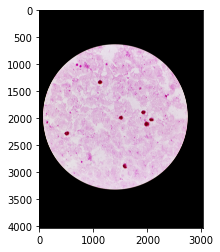

In [200]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
#img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
#img = cv2.flip(img, 1)
#img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

plt.imshow(img)

In [201]:
# cv2.circle(img, df_file['position'][240][0], 1, (0,255,0), 50)
# plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


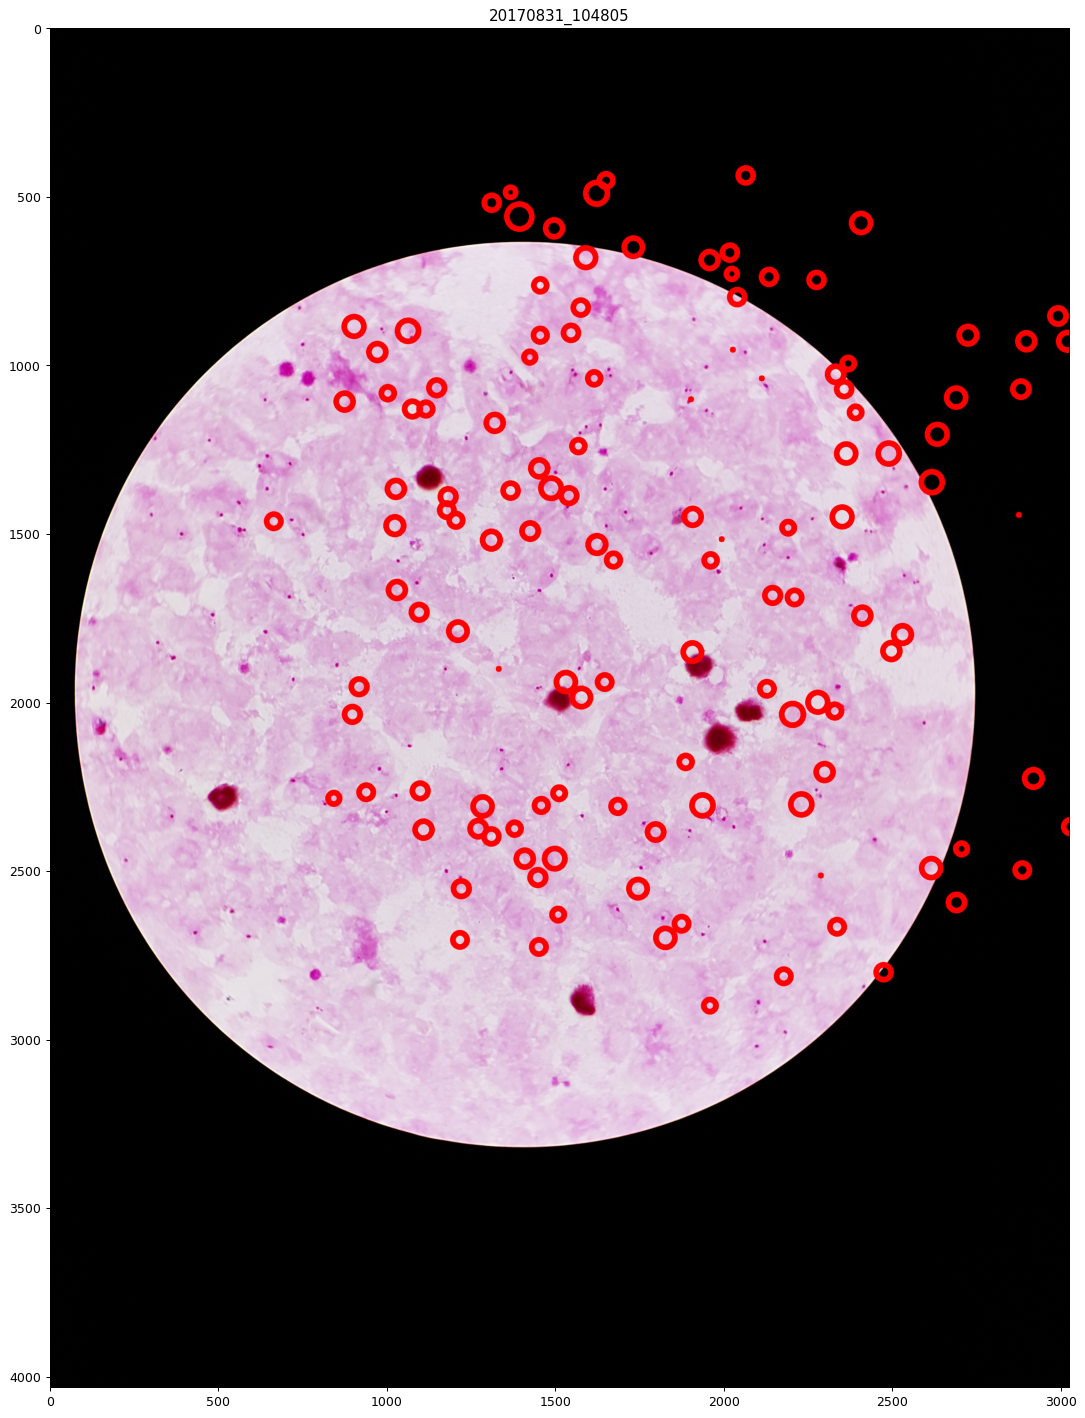

In [202]:
fig = plt.figure(1, figsize=(20,20), dpi=90)
df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row), axis = 1)
plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


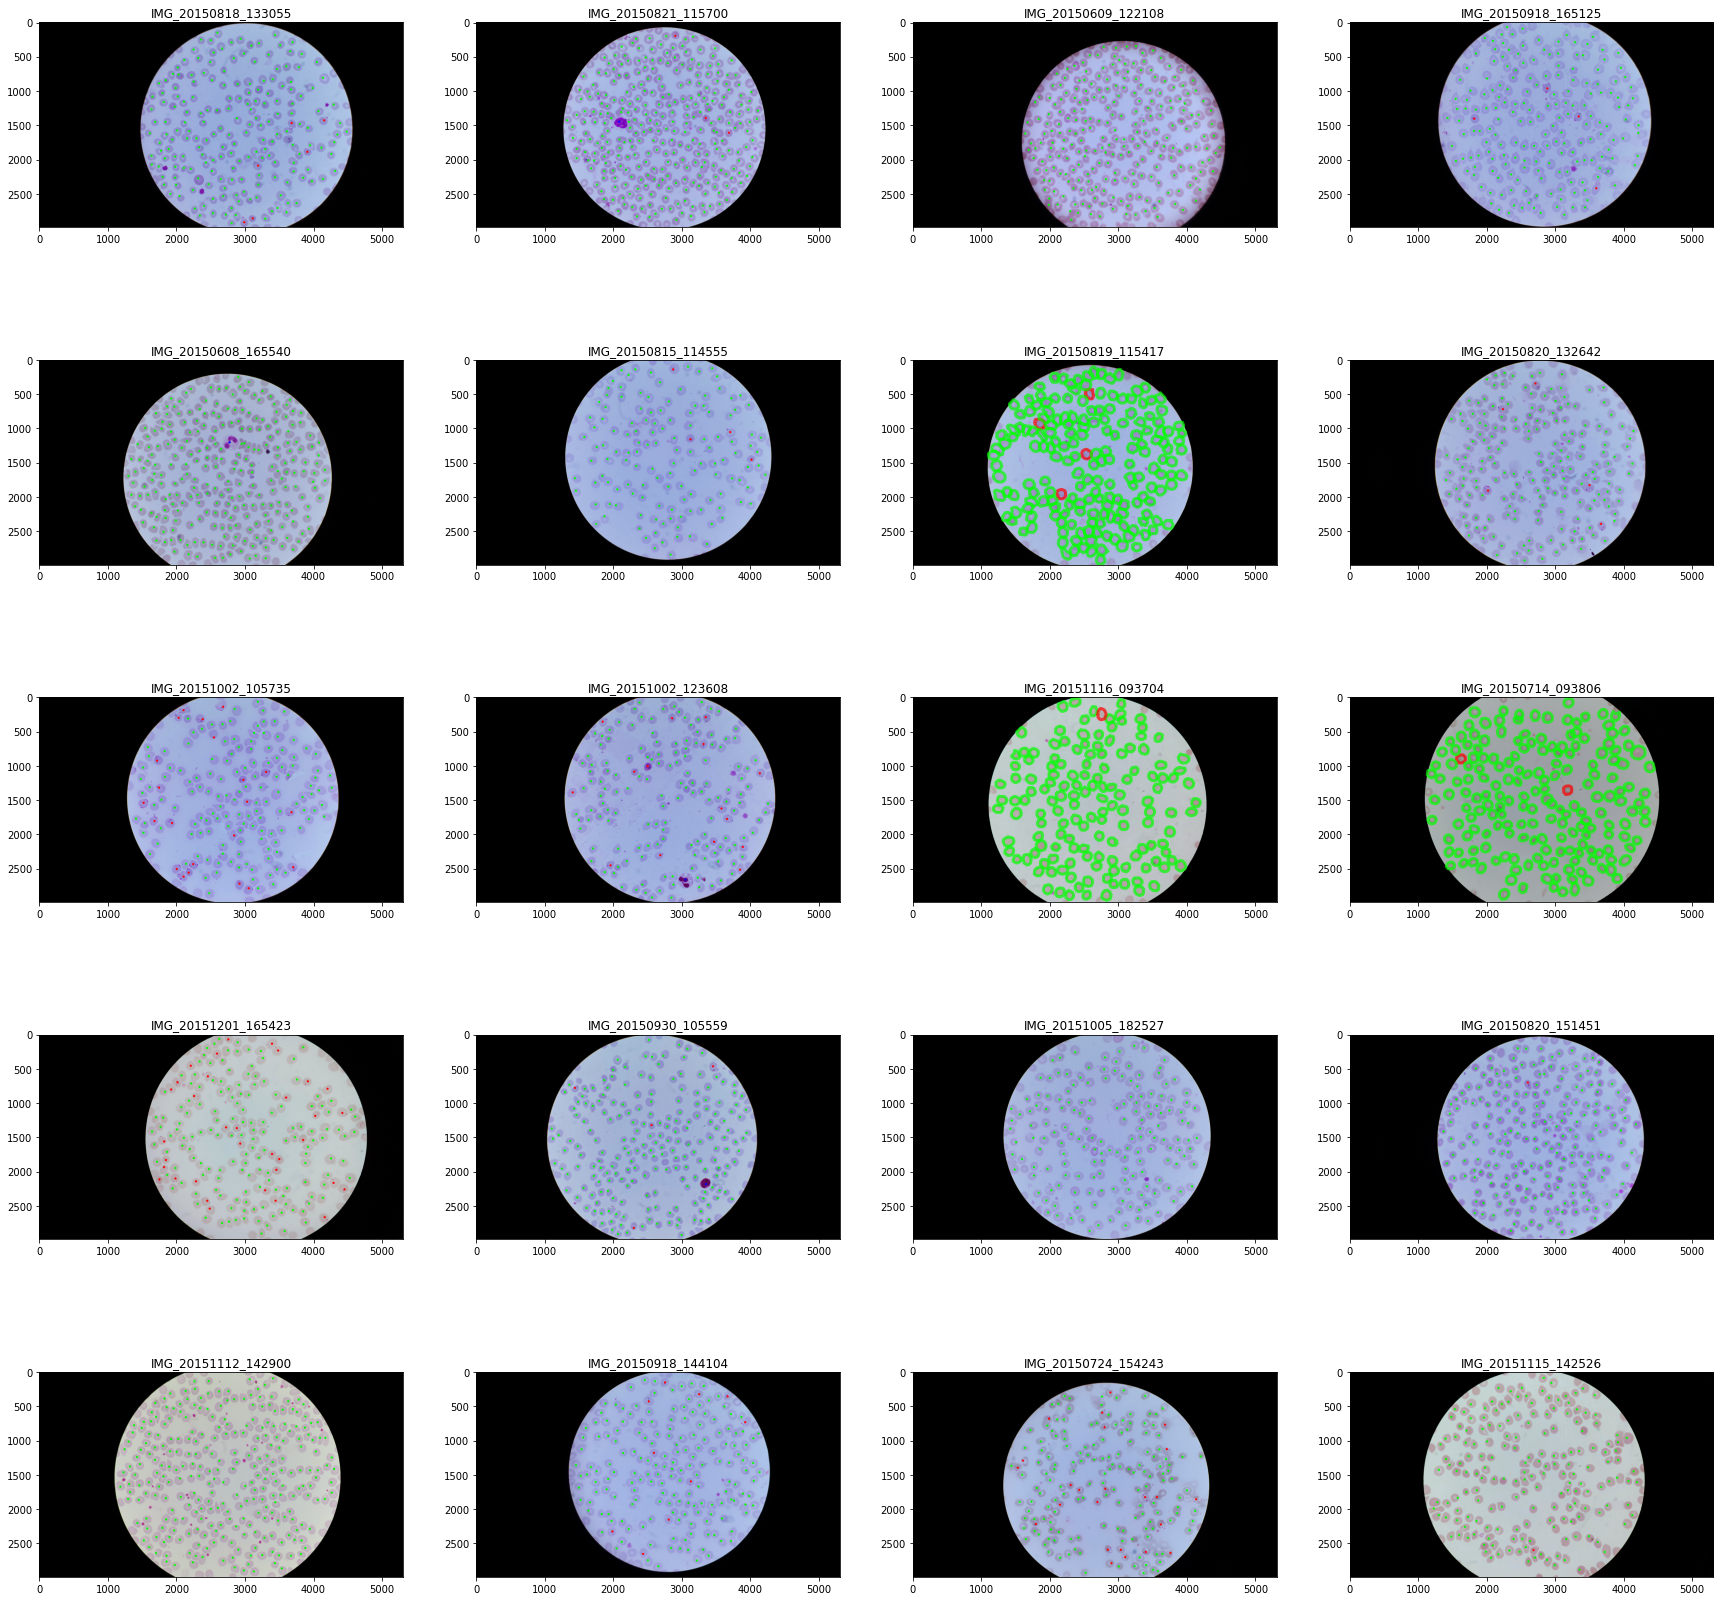

In [35]:
secure_random = random.SystemRandom()

w, h = 10, 10
fig=plt.figure(figsize=(30, 30))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    filename = secure_random.choice(df['filename'].unique())
    df_file = df[df['filename'] == filename]
    #print(filename)
    img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
    df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row = row, rows = rows, columns = columns, i = i, point_size= 30), axis = 1)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Polygons to mask

In [36]:
def poly_mask(row):
    poly = Polygon(row['position'])
    mask = poly.ravel().tolist()

In [37]:
filename =  'IMG_20150820_124943'

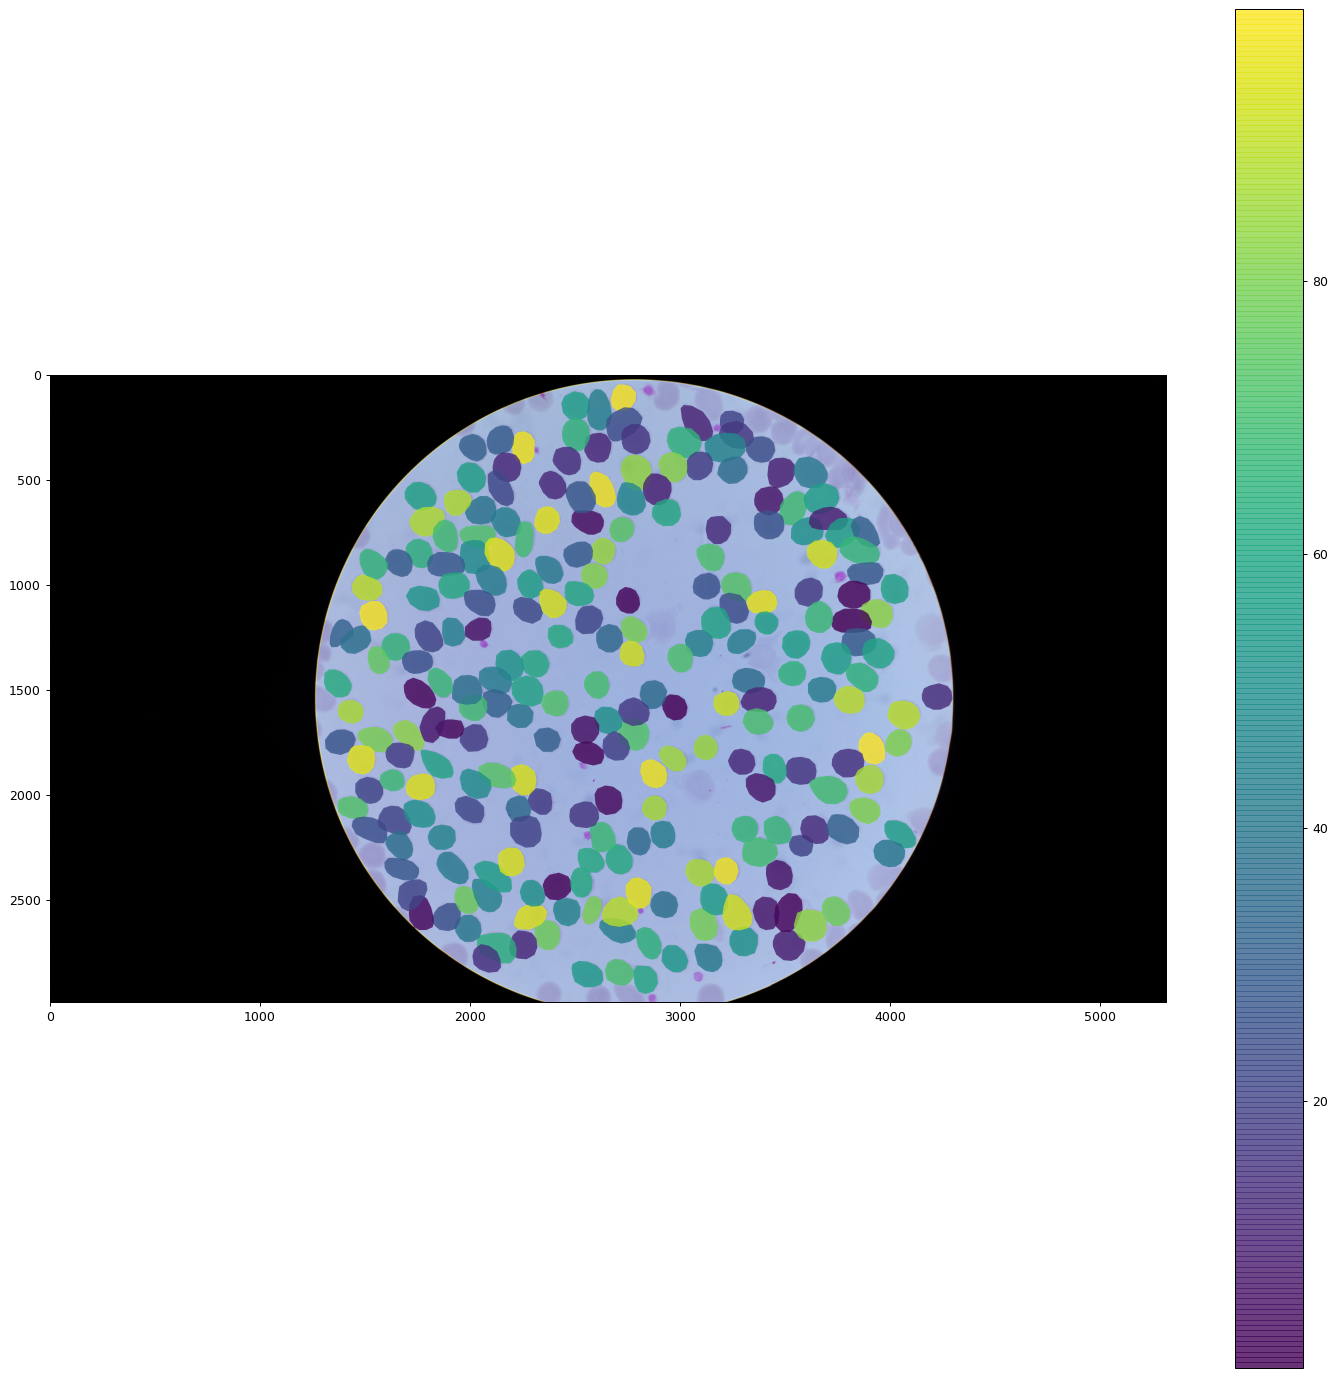

In [38]:
patches = []
patches = [ Polygon(poly) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position'] ]

img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)
empty_img = Image.new("L", [img.shape[1], img.shape[0]], 0)
mask = np.array(empty_img)

fig = plt.figure(1, figsize=(20,20), dpi=90)
ax = fig.add_subplot(111)

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.8)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
plt.imshow(img)

image shape:  <PIL.Image.Image image mode=1 size=5312x2988 at 0x7F94BAC22390>


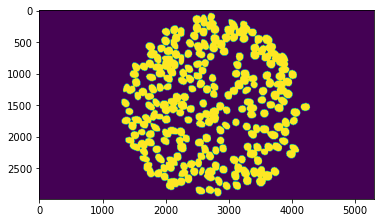

In [39]:
img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)

img = Image.new("L", [img.shape[1], img.shape[0]], 0)
img = img.convert('1')
print('image shape: ', img)
[ ImageDraw.Draw(img).polygon(poly, outline=1, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
mask = np.array(img)

plt.imshow(mask)

img.save('Images/polygon_mask.png')

In [40]:
filename =  'IMG_20150621_112043' #'IMG_20150623_134547' 
df_file = df[df['filename'] == filename]
df_file

Patient no - Cell no         cell     comment annotation_type  \
0                    2-1  Parasitized  No_comment         Polygon   
1                    2-2  Parasitized  No_comment         Polygon   
2                    2-3   Uninfected  No_comment         Polygon   
3                    2-4   Uninfected  No_comment         Polygon   
4                    2-5   Uninfected  No_comment         Polygon   
..                   ...          ...         ...             ...   
204                2-205   Uninfected  No_comment         Polygon   
205                2-206   Uninfected  No_comment         Polygon   
206                2-207   Uninfected  No_comment         Polygon   
207                2-208   Uninfected  No_comment         Polygon   
208                2-209   Uninfected  No_comment         Polygon   

    Number of points                                           position  \
0                 14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
1                 11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
2                 11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
3                 12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
4                 10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
..               ...                                                ...   
204               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
205               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
206               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
207               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
208               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                filename                                           txt_path  \
0    IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1    IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2    IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3    IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4    IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
..                   ...                                                ...   
204  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
205  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
206  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
207  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
208  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                                              img_path  \
0    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
..                                                 ...   
204  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
205  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
206  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
207  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
208  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                          bbx  patient_n_path  
0    [3575, 1304, 3727, 1432]               3  
1    [1441, 1202, 1568, 1307]               3  
2    [2856, 1398, 2960, 1541]               3  
3    [2982, 1460, 3091, 1578]               3  
4    [3043, 1651, 3169, 1788]               3  
..                        ...             ...  
204  [3289, 1194, 3419, 1331]               3  
205  [3346, 1375, 3496, 1515]               3  
206  [3259, 1511, 3400, 1647]               3  
207  [3104, 1532, 3255, 1679]               3  
208  [4162, 1631, 4342, 1758]               3  

[209 rows x 11 columns]

## Connected Components

In [41]:
def connected_component_label(img):
    # https://iq.opengenus.org/connected-component-labeling/
    # https://stackoverflow.com/questions/13572448/replace-values-of-a-numpy-index-array-with-values-of-a-list


    num_labels, labels = cv2.connectedComponents(img)
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    palette = np.arange(1, 179)
    list_rand_nums = np.random.randint(1,179, 179)
    # list_rand_nums gives the new values you wish palette to be mapped to.
    index = np.digitize(label_hue.ravel(), palette, right=True)
    random_hue = np.uint8(list_rand_nums[index].reshape(label_hue.shape))

    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([random_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    
    # Showing Original Image
    plt.imshow(mask)
    plt.axis("off")
    plt.title("Orginal Image")
    plt.show()
    
    #Showing Image after Component Labeling
    plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGRA2RGB))
    plt.axis('off')
    plt.title("Image after Component Labeling")
    plt.show()

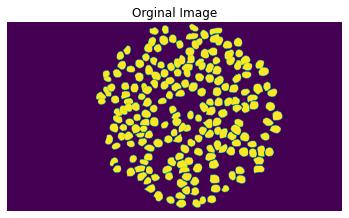

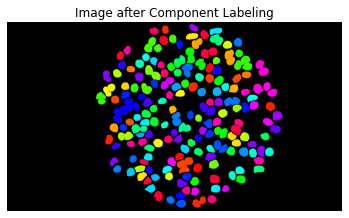

In [42]:
img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)
img = Image.new("L", [img.shape[1], img.shape[0]], 0)
#img = img.convert('1')
[ ImageDraw.Draw(img).polygon(poly, outline=0, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
mask = np.array(img)
connected_component_label(mask)

In [43]:
num_labels, labels = cv2.connectedComponents(mask)
print(len(labels[0]))
print(np.max(labels))

5312
175


In [44]:
df

Patient no - Cell no        cell     comment annotation_type  \
0                    3-1  Uninfected  No_comment         Polygon   
1                    3-2  Uninfected  No_comment         Polygon   
2                    3-3  Uninfected  No_comment         Polygon   
3                    3-4  Uninfected  No_comment         Polygon   
4                    3-5  Uninfected  No_comment         Polygon   
..                   ...         ...         ...             ...   
199                5-200  Uninfected  No_Comment           Point   
200                5-201  Uninfected  No_Comment           Point   
201                5-202  Uninfected  No_Comment           Point   
202                5-203  Uninfected  No_Comment           Point   
203                5-204  Uninfected  No_Comment           Point   

    Number of points                                           position  \
0                 14  [(2934, 38), (2955, 33), (2992, 35), (3015, 44...   
1                 15  [(3013, 141), (2993, 144), (2972, 157), (2956,...   
2                 14  [(2730, 135), (2704, 144), (2672, 165), (2661,...   
3                 14  [(2379, 137), (2353, 149), (2334, 169), (2332,...   
4                 14  [(2575, 140), (2548, 145), (2522, 161), (2500,...   
..               ...                                                ...   
199                1                                      [(2080, 643)]   
200                1                                      [(1790, 606)]   
201                1                                      [(1757, 756)]   
202                1                                      [(1860, 856)]   
203                1                                      [(1623, 683)]   

                filename                                           txt_path  \
0    IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1    IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2    IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3    IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4    IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
..                   ...                                                ...   
199  IMG_20151115_181859  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
200  IMG_20151115_181859  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
201  IMG_20151115_181859  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
202  IMG_20151115_181859  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
203  IMG_20151115_181859  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                                              img_path  \
0    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
..                                                 ...   
199  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
200  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
201  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
202  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
203  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                        bbx  patient_n_path  
0     [2905, 33, 3033, 131]              40  
1    [2951, 141, 3071, 272]              40  
2    [2658, 135, 2801, 276]              40  
3    [2332, 137, 2454, 265]              40  
4    [2499, 140, 2631, 272]              40  
..                      ...             ...  
199  [2010, 573, 2150, 713]             119  
200  [1720, 536, 1860, 676]             119  
201  [1687, 686, 1827, 826]             119  
202  [1790, 786, 1930, 926]             119  
203  [1553, 613, 1693, 753]             119  

[196934 rows x 11 columns]

# Cutting and tiling images and labels

(2988, 5312)


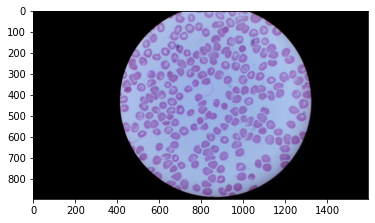

In [45]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
resize_factor = .3
print(img.shape[:2])
resized_img = cv2.resize(img, (int(round(img.shape[1] * resize_factor)), int(round(img.shape[0] * resize_factor))), interpolation=cv2.INTER_AREA)
plt.imshow(resized_img)

In [46]:
df_file.head()

Patient no - Cell no         cell     comment annotation_type  \
0                  2-1  Parasitized  No_comment         Polygon   
1                  2-2  Parasitized  No_comment         Polygon   
2                  2-3   Uninfected  No_comment         Polygon   
3                  2-4   Uninfected  No_comment         Polygon   
4                  2-5   Uninfected  No_comment         Polygon   

  Number of points                                           position  \
0               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
1               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
2               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
3               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
4               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   

              filename                                           txt_path  \
0  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                                            img_path  \
0  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                        bbx  patient_n_path  
0  [3575, 1304, 3727, 1432]               3  
1  [1441, 1202, 1568, 1307]               3  
2  [2856, 1398, 2960, 1541]               3  
3  [2982, 1460, 3091, 1578]               3  
4  [3043, 1651, 3169, 1788]               3

## Cut fit to circle

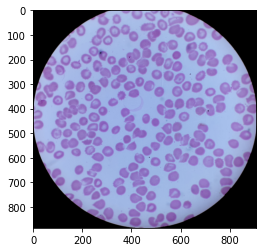

In [47]:
# select circle only
img_gray = rgb2gray(resized_img)
th = threshold_otsu(img_gray)
fg = img_gray>th
# Find the bounding box of those pixels
coords = np.array(np.nonzero(fg))
top_left = np.min(coords, axis=1)
bottom_right = np.max(coords, axis=1)

#set all under threshhold values to zero 
img_circle = resized_img*gray2rgb(fg)

img_cropped = img_circle[top_left[0]:bottom_right[0],
            top_left[1]:bottom_right[1]]

plt.imshow(img_cropped)

In [48]:
def adjust_poly_coord(poly_coords, removed_left, removed_top):
    '''returns a list of polgones with adjusted coordinates'''
    return [(poly[0] - removed_left, poly [1] - removed_top) for poly in poly_coords]
        
def circle_crop(img_path):
    '''returns a cropped image according to the circle as well as the removed top part and removed left part of the image'''
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)

    # select circle only
    img_gray = rgb2gray(img)
    th = threshold_otsu(img_gray)
    fg = img_gray>th
    # Find the bounding box of those pixels
    coords = np.array(np.nonzero(fg))
    min_coords = np.min(coords, axis=1) # [y1, x1]
    max_coords = np.max(coords, axis=1) # [y2, x2]
    
    print('min_coords:', min_coords)
    print('max_coords:', max_coords)
    
    if img_path in dict_poly:
        list_list_tuples_poly = dict_poly[img_path]
        list_tuples_poly = [item for sublist in list_list_tuples_poly for item in sublist]
        list_poly = list(sum(list_tuples_poly, ()))
        x = list_poly[0::2]
        y = list_poly[1::2]
        
        if min(y) < min_coords[0]:
            min_coords[0] = min(y)
        if min(x) < min_coords[1]:
            min_coords[1] = min(x)
        if max(y) > max_coords[0]:
            max_coords[0] = max(y)
        if max(x) > max_coords[1]:
            max_coords[1] = max(x)
            
        print('img_shape: ', img.shape)
        print('new min_coords:', min_coords)
        print('new max_coords:', max_coords)
        print('x min, x max: ', min(x), max(x))
        print('y min, y max: ', min(y), max(y))
    
    #set all under threshhold values to zero 
    img_circle = img*gray2rgb(fg)
    
    ''' image[start_row:end_row, start_column:end_column] e.g. image[30:250, 100:230] or [x1:x2, y1:y2]
    You can see that the waterfall goes vertically starting at about 30px and ending at around 250px.
    You can see that the waterfall goes horizontally from around 100px to around 230px. 
                '''

    img_cropped = img[min_coords[0]:max_coords[0],
                min_coords[1]:max_coords[1]]
    
    return img_cropped, min_coords[0], min_coords[1]

In [49]:
def adjust_coordinates(img_path, position):
    '''returns adjusted coordinates and fitted circle img path '''
    removed_top, removed_left, outname_im = dict_rmv_fit_to_circle[img_path]
    adjusted_polys = adjust_poly_coord(position, removed_left, removed_top)
    return adjusted_polys


In [50]:
def poly2mask(filename, img_path = 'img_path', out_path = '../data/masks', poly_position = 'position'):
    img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), img_path].iloc[-1], cv2.IMREAD_COLOR)
    img = Image.new("L", [img.shape[1], img.shape[0]], 0)
    img = img.convert('1')
    [ ImageDraw.Draw(img).polygon(poly, outline=0, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), poly_position]]

    
    if not os.path.isdir(out_path):
        os.makedirs(out_path)

    mask_path = f'{out_path}/mask_{filename}.png'
    img.save(mask_path)
    return mask_path

def poly2multimask(filename, img_path = 'img_path', out_path = '../data/fit_to_circle', poly_position = 'adjusted_position', outname_mask = False):
    # fill index number per polygon
    img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), img_path].iloc[-1], cv2.IMREAD_COLOR)
    np_img = np.zeros(shape=[img.shape[0], img.shape[1], 1], dtype=np.uint16)

    # This gets polygons filled with an index number
    for index, poly in enumerate(df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), poly_position]):
        poly = np.array(poly)
        rr, cc = polygon(poly[::,1], poly[::,0])
        np_img[rr, cc] = index
    
    #np_img = np_img.astype(np.uint16) if np_img.max()<2**16-1 else np_img.astype(np.uint32)
        
    if not os.path.isdir(out_path):
        os.makedirs(out_path)    
    
    if outname_mask:
        cv2.imwrite(outname_mask, np_img)
    else:    
        outname_mask = f'{outname_mask}/mask_{filename}.png'
        cv2.imwrite(outname_mask, np_img)
    return outname_mask

In [51]:
check_if_outdir_im_circle = os.path.isdir('../data/fit_to_circle')

if not check_if_outdir_im_circle:
    os.makedirs('../data/fit_to_circle')

In [52]:
 # we want to save all images and also create a dictionary with the pixels removed at the top and bottom
dict_rmv_fit_to_circle = {}
dict_patient_n = dict(zip(df['img_path'], df['patient_n_path']))
dict_filename = dict(zip(df['img_path'], df['filename']))
dict_poly = {}

for img_path in df['img_path'].unique():
    if not df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path), 'img_path'].empty:
        print('poly: ', img_path)
        dict_poly[img_path] = [poly for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path), 'position']]
        
    img_cropped, removed_top, removed_left = circle_crop(img_path)  
    patient_n_path = dict_patient_n[img_path]
    filename = dict_filename[img_path]
    outname_im = os.path.join('../data/fit_to_circle/cropped_P' + str(patient_n_path) + '_' + filename + '.png')
    
    print('saving: ', outname_im)
    cv2.imwrite(outname_im, img_cropped)
    
    dict_rmv_fit_to_circle[img_path] = [removed_top, removed_left, outname_im]
    

poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/221C79P40ThinF/Img/IMG_20150817_103139.jpg
min_coords: [   9 1282]
max_coords: [2987 4352]
img_shape:  (2988, 5312, 3)
new min_coords: [   9 1282]
new max_coords: [2987 4352]
x min, x max:  1398 4332
y min, y max:  33 2952
saving:  ../data/fit_to_circle/cropped_P40_IMG_20150817_103139.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/221C79P40ThinF/Img/IMG_20150817_103303.jpg
min_coords: [  65 1326]
max_coords: [2987 4300]
img_shape:  (2988, 5312, 3)
new min_coords: [  65 1326]
new max_coords: [2987 4300]
x min, x max:  1379 4289
y min, y max:  72 2921
saving:  ../data/fit_to_circle/cropped_P40_IMG_20150817_103303.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/221C79P40ThinF/Img/IMG_20150817_102702.jpg
min_coords: [  43 1313]
max_coords: [2987 4324]
img_shape:  (2988, 5312, 3)
new min_coords: [  43 1313]
new max_coords: [2987 4324]
x min, x max:  1370 4207
y min, y max:  65 2983
saving:  ../data/fit_to_circle/cropped

poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/323C231ThinF/Img/IMG_20151112_152234.jpg
min_coords: [   0 1047]
max_coords: [2987 4443]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1047]
new max_coords: [2987 4443]
x min, x max:  1067 4425
y min, y max:  21 2984
saving:  ../data/fit_to_circle/cropped_P202_IMG_20151112_152234.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/228C86P47ThinF/Img/IMG_20150820_124943.jpg
min_coords: [  25 1261]
max_coords: [2987 4295]
img_shape:  (2988, 5312, 3)
new min_coords: [  25 1261]
new max_coords: [2987 4297]
x min, x max:  1305 4297
y min, y max:  46 2948
saving:  ../data/fit_to_circle/cropped_P47_IMG_20150820_124943.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/228C86P47ThinF/Img/IMG_20150820_125057.jpg
min_coords: [  24 1259]
max_coords: [2987 4296]
img_shape:  (2988, 5312, 3)
new min_coords: [  24 1259]
new max_coords: [2987 4296]
x min, x max:  1273 4249
y min, y max:  62 2980
saving:  ../data/fit_to_circle/cropped_

poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/309C216ThinF/Img/IMG_20151106_135653.jpg
min_coords: [   0 1035]
max_coords: [2987 4375]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1035]
new max_coords: [2987 4375]
x min, x max:  1099 4330
y min, y max:  1 2981
saving:  ../data/fit_to_circle/cropped_P203_IMG_20151106_135653.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/309C216ThinF/Img/IMG_20151106_134733.jpg
min_coords: [   0 1029]
max_coords: [2987 4382]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1029]
new max_coords: [2987 4382]
x min, x max:  1063 4379
y min, y max:  13 2987
saving:  ../data/fit_to_circle/cropped_P203_IMG_20151106_134733.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/343C160P121ThinF/Img/IMG_20151116_093109.jpg
min_coords: [   0 1115]
max_coords: [2987 4264]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1115]
new max_coords: [2987 4264]
x min, x max:  1178 4258
y min, y max:  21 2980
saving:  ../data/fit_to_circle/cropped_

poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/306C213ThinF/Img/IMG_20151106_112853.jpg
min_coords: [   0 1037]
max_coords: [2987 4383]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1037]
new max_coords: [2987 4383]
x min, x max:  1060 4346
y min, y max:  31 2971
saving:  ../data/fit_to_circle/cropped_P204_IMG_20151106_112853.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/306C213ThinF/Img/IMG_20151106_112252.jpg
min_coords: [   0 1005]
max_coords: [2987 4409]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1005]
new max_coords: [2987 4409]
x min, x max:  1011 4393
y min, y max:  1 2986
saving:  ../data/fit_to_circle/cropped_P204_IMG_20151106_112252.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/306C213ThinF/Img/IMG_20151106_112759.jpg
min_coords: [  35 1086]
max_coords: [2987 4346]
img_shape:  (2988, 5312, 3)
new min_coords: [  35 1086]
new max_coords: [2987 4346]
x min, x max:  1154 4290
y min, y max:  99 2948
saving:  ../data/fit_to_circle/cropped_P204

poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/270C122P83ThinF/Img/IMG_20151002_144341.jpg
min_coords: [   0 1277]
max_coords: [2987 4379]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1277]
new max_coords: [2987 4379]
x min, x max:  1334 4295
y min, y max:  10 2972
saving:  ../data/fit_to_circle/cropped_P83_IMG_20151002_144341.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/270C122P83ThinF/Img/IMG_20151002_144855.jpg
min_coords: [   0 1296]
max_coords: [2987 4364]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1296]
new max_coords: [2987 4364]
x min, x max:  1317 4288
y min, y max:  30 2964
saving:  ../data/fit_to_circle/cropped_P83_IMG_20151002_144855.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/270C122P83ThinF/Img/IMG_20151002_145014.jpg
min_coords: [   0 1285]
max_coords: [2987 4378]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1285]
new max_coords: [2987 4378]
x min, x max:  1350 4346
y min, y max:  16 2966
saving:  ../data/fit_to_circle/crop

poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/208C67P28N_ThinF/Img/IMG_20150819_121456.jpg
min_coords: [  32 1036]
max_coords: [2987 4131]
img_shape:  (2988, 5312, 3)
new min_coords: [  32 1036]
new max_coords: [2987 4131]
x min, x max:  1149 4038
y min, y max:  55 2946
saving:  ../data/fit_to_circle/cropped_P28_IMG_20150819_121456.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/208C67P28N_ThinF/Img/IMG_20150819_115417.jpg
min_coords: [  73 1090]
max_coords: [2987 4082]
img_shape:  (2988, 5312, 3)
new min_coords: [  73 1090]
new max_coords: [2987 4082]
x min, x max:  1108 3998
y min, y max:  101 2986
saving:  ../data/fit_to_circle/cropped_P28_IMG_20150819_115417.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/208C67P28N_ThinF/Img/IMG_20150819_121240.jpg
min_coords: [  48 1058]
max_coords: [2987 4113]
img_shape:  (2988, 5312, 3)
new min_coords: [  48 1058]
new max_coords: [2987 4113]
x min, x max:  1176 3987
y min, y max:  53 2983
saving:  ../data/fit_to_circle/

poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/211C70P31_ThinF/Img/IMG_20150813_131022.jpg
min_coords: [  26 1089]
max_coords: [2987 4079]
img_shape:  (2988, 5312, 3)
new min_coords: [  26 1089]
new max_coords: [2987 4079]
x min, x max:  1301 4007
y min, y max:  130 2907
saving:  ../data/fit_to_circle/cropped_P31_IMG_20150813_131022.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/236C94P55ThinF/Img/IMG_20150821_165118.jpg
min_coords: [   0 1230]
max_coords: [2909 4172]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1230]
new max_coords: [2909 4172]
x min, x max:  1231 4145
y min, y max:  1 2895
saving:  ../data/fit_to_circle/cropped_P55_IMG_20150821_165118.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/236C94P55ThinF/Img/IMG_20150821_170403.jpg
min_coords: [   0 1232]
max_coords: [2907 4174]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1232]
new max_coords: [2907 4174]
x min, x max:  1267 4141
y min, y max:  59 2861
saving:  ../data/fit_to_circle/croppe

min_coords: [   0 1073]
max_coords: [2987 4421]
saving:  ../data/fit_to_circle/cropped_P211_IMG_20151112_144613.png
min_coords: [   0 1289]
max_coords: [2982 4395]
saving:  ../data/fit_to_circle/cropped_P64_IMG_20150918_165125.png
min_coords: [   0 1314]
max_coords: [2949 4337]
saving:  ../data/fit_to_circle/cropped_P64_IMG_20150918_164250.png
min_coords: [   0 1331]
max_coords: [2934 4318]
saving:  ../data/fit_to_circle/cropped_P64_IMG_20150918_164331.png
min_coords: [   0 1321]
max_coords: [2943 4330]
saving:  ../data/fit_to_circle/cropped_P64_IMG_20150918_165016.png
min_coords: [   0 1308]
max_coords: [2959 4361]
saving:  ../data/fit_to_circle/cropped_P64_IMG_20150918_164553.png
min_coords: [  0 998]
max_coords: [2987 4327]
saving:  ../data/fit_to_circle/cropped_P111_IMG_20151115_115805.png
min_coords: [  0 984]
max_coords: [2987 4341]
saving:  ../data/fit_to_circle/cropped_P111_IMG_20151115_115950.png
min_coords: [   0 1026]
max_coords: [2987 4299]
saving:  ../data/fit_to_circle/cr

min_coords: [   0 1072]
max_coords: [2987 4422]
saving:  ../data/fit_to_circle/cropped_P217_IMG_20151112_162940.png
min_coords: [   0 1090]
max_coords: [2987 4410]
saving:  ../data/fit_to_circle/cropped_P217_IMG_20151112_162759.png
min_coords: [   0 1079]
max_coords: [2987 4417]
saving:  ../data/fit_to_circle/cropped_P217_IMG_20151112_162909.png
min_coords: [   0 1110]
max_coords: [2987 4394]
saving:  ../data/fit_to_circle/cropped_P217_IMG_20151112_162843.png
min_coords: [   0 1087]
max_coords: [2987 4411]
saving:  ../data/fit_to_circle/cropped_P217_IMG_20151112_163036.png
min_coords: [   0 1088]
max_coords: [2987 4404]
saving:  ../data/fit_to_circle/cropped_P218_IMG_20151112_113915.png
min_coords: [   0 1087]
max_coords: [2987 4405]
saving:  ../data/fit_to_circle/cropped_P218_IMG_20151112_113953.png
min_coords: [   0 1044]
max_coords: [2987 4439]
saving:  ../data/fit_to_circle/cropped_P218_IMG_20151112_113735.png
min_coords: [   0 1039]
max_coords: [2987 4444]
saving:  ../data/fit_to_

min_coords: [   0 1299]
max_coords: [2987 4365]
saving:  ../data/fit_to_circle/cropped_P97_IMG_20151005_141803.png
min_coords: [   0 1319]
max_coords: [2986 4340]
saving:  ../data/fit_to_circle/cropped_P97_IMG_20151005_140538.png
min_coords: [   0 1295]
max_coords: [2987 4369]
saving:  ../data/fit_to_circle/cropped_P97_IMG_20151005_140646.png
min_coords: [   0 1324]
max_coords: [2985 4352]
saving:  ../data/fit_to_circle/cropped_P97_IMG_20151005_141321.png
min_coords: [   0 1324]
max_coords: [2941 4327]
saving:  ../data/fit_to_circle/cropped_P65_IMG_20150918_170850.png
min_coords: [   0 1328]
max_coords: [2937 4324]
saving:  ../data/fit_to_circle/cropped_P65_IMG_20150918_172214.png
min_coords: [   0 1344]
max_coords: [2923 4304]
saving:  ../data/fit_to_circle/cropped_P65_IMG_20150918_171751.png
min_coords: [   0 1328]
max_coords: [2939 4331]
saving:  ../data/fit_to_circle/cropped_P65_IMG_20150918_172053.png
min_coords: [   0 1300]
max_coords: [2970 4374]
saving:  ../data/fit_to_circle/c

min_coords: [  13 1051]
max_coords: [2987 4096]
saving:  ../data/fit_to_circle/cropped_P20_IMG_20150803_112733.png
min_coords: [   2 1020]
max_coords: [2987 4096]
saving:  ../data/fit_to_circle/cropped_P20_IMG_20150803_112858.png
min_coords: [   1 1022]
max_coords: [2987 4101]
saving:  ../data/fit_to_circle/cropped_P20_IMG_20150803_111333.png
min_coords: [   0 1031]
max_coords: [2987 4388]
saving:  ../data/fit_to_circle/cropped_P225_IMG_20151106_115440.png
min_coords: [   0 1025]
max_coords: [2987 4393]
saving:  ../data/fit_to_circle/cropped_P225_IMG_20151106_114526.png
min_coords: [  0 959]
max_coords: [2987 4446]
saving:  ../data/fit_to_circle/cropped_P225_IMG_20151106_114611.png
min_coords: [  28 1083]
max_coords: [2987 4349]
saving:  ../data/fit_to_circle/cropped_P225_IMG_20151106_114910.png
min_coords: [   0 1063]
max_coords: [2987 4367]
saving:  ../data/fit_to_circle/cropped_P225_IMG_20151106_131748.png
min_coords: [   0 1000]
max_coords: [2987 4408]
saving:  ../data/fit_to_circl

min_coords: [  37 1070]
max_coords: [2987 4074]
saving:  ../data/fit_to_circle/cropped_P71_IMG_20150930_110052.png
min_coords: [  36 1086]
max_coords: [2987 4337]
saving:  ../data/fit_to_circle/cropped_P228_IMG_20151106_154533.png
min_coords: [  41 1089]
max_coords: [2987 4335]
saving:  ../data/fit_to_circle/cropped_P228_IMG_20151106_154510.png
min_coords: [   0 1043]
max_coords: [2987 4374]
saving:  ../data/fit_to_circle/cropped_P228_IMG_20151106_153947.png
min_coords: [   7 1061]
max_coords: [2987 4360]
saving:  ../data/fit_to_circle/cropped_P228_IMG_20151106_154339.png
min_coords: [   7 1062]
max_coords: [2987 4360]
saving:  ../data/fit_to_circle/cropped_P228_IMG_20151106_154016.png
min_coords: [  77 1263]
max_coords: [2987 4219]
saving:  ../data/fit_to_circle/cropped_P52_IMG_20150821_123116.png
min_coords: [  72 1458]
max_coords: [2987 4464]
saving:  ../data/fit_to_circle/cropped_P52_IMG_20150821_124504.png
min_coords: [  78 1263]
max_coords: [2987 4219]
saving:  ../data/fit_to_cir

min_coords: [  73 1096]
max_coords: [2987 4087]
saving:  ../data/fit_to_circle/cropped_P30_IMG_20150819_140143.png
min_coords: [  68 1100]
max_coords: [2987 4095]
saving:  ../data/fit_to_circle/cropped_P30_IMG_20150819_135613.png
min_coords: [  42 1052]
max_coords: [2987 4123]
saving:  ../data/fit_to_circle/cropped_P30_IMG_20150819_135421.png
min_coords: [  67 1094]
max_coords: [2987 4094]
saving:  ../data/fit_to_circle/cropped_P30_IMG_20150819_135705.png
min_coords: [  72 1093]
max_coords: [2987 4088]
saving:  ../data/fit_to_circle/cropped_P30_IMG_20150819_140652.png
min_coords: [   0 1025]
max_coords: [2987 4386]
saving:  ../data/fit_to_circle/cropped_P230_IMG_20151106_133247.png
min_coords: [   0 1013]
max_coords: [2987 4398]
saving:  ../data/fit_to_circle/cropped_P230_IMG_20151106_133012.png
min_coords: [   0 1012]
max_coords: [2987 4398]
saving:  ../data/fit_to_circle/cropped_P230_IMG_20151106_133043.png
min_coords: [  0 980]
max_coords: [2987 4425]
saving:  ../data/fit_to_circle/

min_coords: [   0 1025]
max_coords: [2987 4119]
saving:  ../data/fit_to_circle/cropped_P74_IMG_20150930_134751.png
min_coords: [  29 1057]
max_coords: [2987 4079]
saving:  ../data/fit_to_circle/cropped_P74_IMG_20150930_134355.png
min_coords: [   0 1031]
max_coords: [2987 4109]
saving:  ../data/fit_to_circle/cropped_P74_IMG_20150930_134949.png
min_coords: [  45 1072]
max_coords: [2987 4064]
saving:  ../data/fit_to_circle/cropped_P74_IMG_20150930_134429.png
min_coords: [   0 1552]
max_coords: [2987 4784]
saving:  ../data/fit_to_circle/cropped_P139_IMG_20151201_153246.png
min_coords: [   0 1554]
max_coords: [2987 4777]
saving:  ../data/fit_to_circle/cropped_P139_IMG_20151201_153846.png
min_coords: [   0 1555]
max_coords: [2987 4778]
saving:  ../data/fit_to_circle/cropped_P139_IMG_20151201_151903.png
min_coords: [   0 1555]
max_coords: [2987 4776]
saving:  ../data/fit_to_circle/cropped_P139_IMG_20151201_154337.png
min_coords: [   0 1554]
max_coords: [2987 4786]
saving:  ../data/fit_to_circ

min_coords: [   0 1082]
max_coords: [2987 4410]
saving:  ../data/fit_to_circle/cropped_P236_IMG_20151112_113157.png
min_coords: [   0 1061]
max_coords: [2987 4428]
saving:  ../data/fit_to_circle/cropped_P236_IMG_20151112_111955.png
min_coords: [ 103 1191]
max_coords: [2987 4455]
saving:  ../data/fit_to_circle/cropped_P237_IMG_20151127_115247.png
min_coords: [  69 1157]
max_coords: [2987 4496]
saving:  ../data/fit_to_circle/cropped_P237_IMG_20151127_115545.png
min_coords: [  85 1173]
max_coords: [2987 4477]
saving:  ../data/fit_to_circle/cropped_P237_IMG_20151127_115328.png
min_coords: [  89 1178]
max_coords: [2987 4473]
saving:  ../data/fit_to_circle/cropped_P237_IMG_20151127_115223.png
min_coords: [  89 1176]
max_coords: [2987 4472]
saving:  ../data/fit_to_circle/cropped_P237_IMG_20151127_115306.png
min_coords: [  85 1486]
max_coords: [2987 4496]
saving:  ../data/fit_to_circle/cropped_P53_IMG_20150821_150718.png
min_coords: [ 109 1489]
max_coords: [2987 4453]
saving:  ../data/fit_to_c

min_coords: [   0 1354]
max_coords: [2987 4565]
saving:  ../data/fit_to_circle/cropped_P129_IMG_20151118_153739.png
min_coords: [ 108 1402]
max_coords: [2987 4390]
saving:  ../data/fit_to_circle/cropped_P9_IMG_20150721_161412.png
min_coords: [ 113 1408]
max_coords: [2987 4386]
saving:  ../data/fit_to_circle/cropped_P9_IMG_20150721_161055.png
min_coords: [  89 1390]
max_coords: [2987 4418]
saving:  ../data/fit_to_circle/cropped_P9_IMG_20150721_160944.png
min_coords: [ 108 1403]
max_coords: [2987 4390]
saving:  ../data/fit_to_circle/cropped_P9_IMG_20150721_161243.png
min_coords: [ 107 1452]
max_coords: [2987 4483]
saving:  ../data/fit_to_circle/cropped_P9_IMG_20150721_160406.png
min_coords: [   0 1521]
max_coords: [2987 4815]
saving:  ../data/fit_to_circle/cropped_P137_IMG_20151201_114035.png
min_coords: [   0 1559]
max_coords: [2987 4782]
saving:  ../data/fit_to_circle/cropped_P137_IMG_20151201_120845.png
min_coords: [   0 1560]
max_coords: [2987 4783]
saving:  ../data/fit_to_circle/cro

min_coords: [   0 1310]
max_coords: [2987 4350]
saving:  ../data/fit_to_circle/cropped_P96_IMG_20151005_123857.png
min_coords: [   0 1299]
max_coords: [2987 4363]
saving:  ../data/fit_to_circle/cropped_P96_IMG_20151005_123715.png
min_coords: [   0 1304]
max_coords: [2987 4351]
saving:  ../data/fit_to_circle/cropped_P96_IMG_20151005_124031.png
min_coords: [   0 1313]
max_coords: [2987 4345]
saving:  ../data/fit_to_circle/cropped_P96_IMG_20151005_123441.png
min_coords: [   0 1380]
max_coords: [2987 4568]
saving:  ../data/fit_to_circle/cropped_P133_IMG_20151119_154936.png
min_coords: [   0 1373]
max_coords: [2987 4585]
saving:  ../data/fit_to_circle/cropped_P133_IMG_20151119_155343.png
min_coords: [   0 1378]
max_coords: [2987 4576]
saving:  ../data/fit_to_circle/cropped_P133_IMG_20151119_155156.png
min_coords: [   0 1376]
max_coords: [2987 4577]
saving:  ../data/fit_to_circle/cropped_P133_IMG_20151119_155019.png
min_coords: [   0 1381]
max_coords: [2987 4569]
saving:  ../data/fit_to_circ

min_coords: [   0 1322]
max_coords: [2978 4328]
saving:  ../data/fit_to_circle/cropped_P79_IMG_20151002_104831.png
min_coords: [   1 1334]
max_coords: [2976 4319]
saving:  ../data/fit_to_circle/cropped_P79_IMG_20151002_105018.png
min_coords: [   0 1315]
max_coords: [2987 4336]
saving:  ../data/fit_to_circle/cropped_P84_IMG_20151002_151851.png
min_coords: [   0 1304]
max_coords: [2987 4354]
saving:  ../data/fit_to_circle/cropped_P84_IMG_20151002_152144.png
min_coords: [   0 1319]
max_coords: [2986 4333]
saving:  ../data/fit_to_circle/cropped_P84_IMG_20151002_150931.png
min_coords: [   0 1315]
max_coords: [2987 4341]
saving:  ../data/fit_to_circle/cropped_P84_IMG_20151002_151143.png
min_coords: [   0 1315]
max_coords: [2987 4341]
saving:  ../data/fit_to_circle/cropped_P84_IMG_20151002_151432.png
min_coords: [   0 1313]
max_coords: [2987 4339]
saving:  ../data/fit_to_circle/cropped_P91_IMG_20151004_135449.png
min_coords: [   0 1315]
max_coords: [2987 4349]
saving:  ../data/fit_to_circle/c

min_coords: [   0 1102]
max_coords: [2987 4289]
saving:  ../data/fit_to_circle/cropped_P119_IMG_20151115_181436.png
min_coords: [   0 1093]
max_coords: [2987 4299]
saving:  ../data/fit_to_circle/cropped_P119_IMG_20151115_181558.png
min_coords: [   0 1080]
max_coords: [2987 4312]
saving:  ../data/fit_to_circle/cropped_P119_IMG_20151115_181136.png
min_coords: [   0 1067]
max_coords: [2987 4332]
saving:  ../data/fit_to_circle/cropped_P119_IMG_20151115_181035.png
min_coords: [   0 1071]
max_coords: [2987 4329]
saving:  ../data/fit_to_circle/cropped_P119_IMG_20151115_181859.png


In [53]:
df['adjusted_position'] = df.apply(lambda row: adjust_coordinates(row.img_path, row.position), axis = 1) 
df['img_path_fit2circle'] = df['img_path'].apply(lambda x: dict_rmv_fit_to_circle[x][2])

In [101]:
# creating masks for Polygon set
dict_mask = {}

for img_path in df.loc[(df['annotation_type'] == 'Polygon'), 'img_path'].unique():
    patient_n_path = dict_patient_n[img_path]
    filename = dict_filename[img_path]
    outname_mask = os.path.join('../data/fit_to_circle/cropped_P' + str(patient_n_path) + '_' + filename + '_masks''.png')
    
    print('saving: ', outname_mask)
    outname_mask = poly2multimask(filename, 'img_path_fit2circle',  poly_position = 'adjusted_position', outname_mask = outname_mask)
    
    dict_mask[img_path] = outname_mask

saving:  ../data/fit_to_circle/cropped_P40_IMG_20150817_103139_masks.png
saving:  ../data/fit_to_circle/cropped_P40_IMG_20150817_103303_masks.png
saving:  ../data/fit_to_circle/cropped_P40_IMG_20150817_102702_masks.png
saving:  ../data/fit_to_circle/cropped_P40_IMG_20150817_102823_masks.png
saving:  ../data/fit_to_circle/cropped_P40_IMG_20150817_103901_masks.png
saving:  ../data/fit_to_circle/cropped_P13_IMG_20150725_123938_masks.png
saving:  ../data/fit_to_circle/cropped_P13_IMG_20150725_125213_masks.png
saving:  ../data/fit_to_circle/cropped_P13_IMG_20150725_125847_masks.png
saving:  ../data/fit_to_circle/cropped_P13_IMG_20150725_124606_masks.png
saving:  ../data/fit_to_circle/cropped_P13_IMG_20150725_124830_masks.png
saving:  ../data/fit_to_circle/cropped_P89_IMG_20151004_130810_masks.png
saving:  ../data/fit_to_circle/cropped_P89_IMG_20151004_130408_masks.png
saving:  ../data/fit_to_circle/cropped_P89_IMG_20151004_130549_masks.png
saving:  ../data/fit_to_circle/cropped_P89_IMG_2015

saving:  ../data/fit_to_circle/cropped_P29_IMG_20150819_133236_masks.png
saving:  ../data/fit_to_circle/cropped_P29_IMG_20150819_133350_masks.png
saving:  ../data/fit_to_circle/cropped_P29_IMG_20150819_134112_masks.png
saving:  ../data/fit_to_circle/cropped_P76_IMG_20150930_162315_masks.png
saving:  ../data/fit_to_circle/cropped_P76_IMG_20150930_161825_masks.png
saving:  ../data/fit_to_circle/cropped_P76_IMG_20150930_163018_masks.png
saving:  ../data/fit_to_circle/cropped_P76_IMG_20150930_163156_masks.png
saving:  ../data/fit_to_circle/cropped_P76_IMG_20150930_162038_masks.png
saving:  ../data/fit_to_circle/cropped_P28_IMG_20150819_121456_masks.png
saving:  ../data/fit_to_circle/cropped_P28_IMG_20150819_115417_masks.png
saving:  ../data/fit_to_circle/cropped_P28_IMG_20150819_121240_masks.png
saving:  ../data/fit_to_circle/cropped_P28_IMG_20150819_121053_masks.png
saving:  ../data/fit_to_circle/cropped_P28_IMG_20150819_115955_masks.png
saving:  ../data/fit_to_circle/cropped_P208_IMG_201

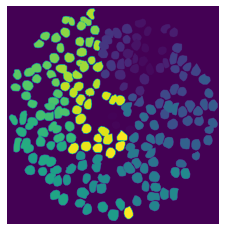

In [102]:
filename = 'IMG_20150621_112043'
img_path = 'img_path_fit2circle'
img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), img_path].iloc[-1], cv2.IMREAD_COLOR)
img = np.zeros(shape=[img.shape[1], img.shape[0], 1], dtype=np.uint8)

for index, poly in enumerate(df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'adjusted_position']):
    poly = np.array(poly)
    rr, cc = polygon(poly[::,0], poly[::,1])
    img[rr, cc] = index
    
plt.imshow(img)
plt.axis('off')
plt.show()

In [103]:
df.loc[(df['annotation_type'] == 'Polygon'), 'mask_path_fit2circle'] = df.loc[(df['annotation_type'] == 'Polygon'), 'img_path'].apply(lambda x: dict_mask[x])
df.head()

Patient no - Cell no        cell     comment annotation_type  \
0                  3-1  Uninfected  No_comment         Polygon   
1                  3-2  Uninfected  No_comment         Polygon   
2                  3-3  Uninfected  No_comment         Polygon   
3                  3-4  Uninfected  No_comment         Polygon   
4                  3-5  Uninfected  No_comment         Polygon   

  Number of points                                           position  \
0               14  [(2934, 38), (2955, 33), (2992, 35), (3015, 44...   
1               15  [(3013, 141), (2993, 144), (2972, 157), (2956,...   
2               14  [(2730, 135), (2704, 144), (2672, 165), (2661,...   
3               14  [(2379, 137), (2353, 149), (2334, 169), (2332,...   
4               14  [(2575, 140), (2548, 145), (2522, 161), (2500,...   

              filename                                           txt_path  \
0  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                                            img_path                     bbx  \
0  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   [2905, 33, 3033, 131]   
1  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2951, 141, 3071, 272]   
2  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2658, 135, 2801, 276]   
3  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2332, 137, 2454, 265]   
4  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2499, 140, 2631, 272]   

   patient_n_path                                  adjusted_position  \
0              40  [(1652, 29), (1673, 24), (1710, 26), (1733, 35...   
1              40  [(1731, 132), (1711, 135), (1690, 148), (1674,...   
2              40  [(1448, 126), (1422, 135), (1390, 156), (1379,...   
3              40  [(1097, 128), (1071, 140), (1052, 160), (1050,...   
4              40  [(1293, 131), (1266, 136), (1240, 152), (1218,...   

                                 img_path_fit2circle  \
0  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
1  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
2  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
3  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
4  ../data/fit_to_circle/cropped_P40_IMG_20150817...   

                                mask_path_fit2circle            adjusted_bbx  \
0  ../data/fit_to_circle/cropped_P40_IMG_20150817...   [1623, 24, 1751, 122]   
1  ../data/fit_to_circle/cropped_P40_IMG_20150817...  [1669, 132, 1789, 263]   
2  ../data/fit_to_circle/cropped_P40_IMG_20150817...  [1376, 126, 1519, 267]   
3  ../data/fit_to_circle/cropped_P40_IMG_20150817...  [1050, 128, 1172, 256]   
4  ../data/fit_to_circle/cropped_P40_IMG_20150817...  [1217, 131, 1349, 263]   

                                    mask_path train_test  
0  ../data/masks/mask_IMG_20150817_103139.png      train  
1  ../data/masks/mask_IMG_20150817_103139.png      train  
2  ../data/masks/mask_IMG_20150817_103139.png      train  
3  ../data/masks/mask_IMG_20150817_103139.png      train  
4  ../data/masks/mask_IMG_20150817_103139.png      train

In [104]:
def get_bbx(position, annotation_type, bb_pixel):
    if annotation_type == 'Polygon':
        poly_list = np.array([list(ele) for ele in position])
        x_min = np.nanmin(poly_list[:, 0])
        x_max = np.nanmax(poly_list[:, 0])
        y_min = np.nanmin(poly_list[:, 1])
        y_max = np.nanmax(poly_list[:, 1])
        return [x_min, y_min, x_max, y_max]
    if annotation_type == 'Point':
        point_list = np.array(position)
        x_min = int(point_list[:, 0] - 0.5 * bb_pixel)
        x_max = int(point_list[:, 0] + 0.5 * bb_pixel)
        y_min = int(point_list[:, 1] - 0.5 * bb_pixel)
        y_max = int(point_list[:, 1] + 0.5 * bb_pixel)
        return [x_min, y_min, x_max, y_max]

In [58]:
df['adjusted_bbx'] = df.apply(lambda row: get_bbx(row['adjusted_position'], row['annotation_type'], 150), axis = 1)

In [59]:
filename =  'IMG_20150623_134547' 
df_file = df[df['filename'] == filename]
df_file.head()

Patient no - Cell no         cell     comment annotation_type  \
0                  2-1  Parasitized  No_Comment           Point   
1                  2-2   Uninfected  No_Comment           Point   
2                  2-3   Uninfected  No_Comment           Point   
3                  2-4   Uninfected  No_Comment           Point   
4                  2-5   Uninfected  No_Comment           Point   

  Number of points        position             filename  \
0                1  [(1131, 1205)]  IMG_20150623_134547   
1                1  [(3804, 1277)]  IMG_20150623_134547   
2                1  [(1898, 1277)]  IMG_20150623_134547   
3                1  [(1818, 1350)]  IMG_20150623_134547   
4                1  [(1828, 1481)]  IMG_20150623_134547   

                                            txt_path  \
0  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   
1  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   
2  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   
3  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   
4  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   

                                            img_path  \
0  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   
1  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   
2  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   
3  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   
4  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   

                        bbx  patient_n_path adjusted_position  \
0  [1061, 1135, 1201, 1275]               5     [(131, 1171)]   
1  [3734, 1207, 3874, 1347]               5    [(2804, 1243)]   
2  [1828, 1207, 1968, 1347]               5     [(898, 1243)]   
3  [1748, 1280, 1888, 1420]               5     [(818, 1316)]   
4  [1758, 1411, 1898, 1551]               5     [(828, 1447)]   

                                 img_path_fit2circle mask_path_fit2circle  \
0  ../data/fit_to_circle/cropped_P5_IMG_20150623_...                  NaN   
1  ../data/fit_to_circle/cropped_P5_IMG_20150623_...                  NaN   
2  ../data/fit_to_circle/cropped_P5_IMG_20150623_...                  NaN   
3  ../data/fit_to_circle/cropped_P5_IMG_20150623_...                  NaN   
4  ../data/fit_to_circle/cropped_P5_IMG_20150623_...                  NaN   

               adjusted_bbx  
0     [56, 1096, 206, 1246]  
1  [2729, 1168, 2879, 1318]  
2    [823, 1168, 973, 1318]  
3    [743, 1241, 893, 1391]  
4    [753, 1372, 903, 1522]

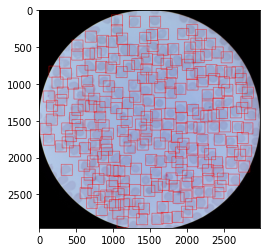

In [60]:
img = cv2.imread(df_file['img_path_fit2circle'].iloc[-1], cv2.IMREAD_COLOR)
img_with_box = bbv.draw_multiple_rectangles(img, df_file['adjusted_bbx'].tolist(), bbox_color = (255, 0, 0), thickness=3)
plt.imshow(img_with_box)

## Crop tiles

In [61]:
def plot_tiles(img, tile_w, tile_h):
    img_shape = img.shape
    tile_size = (tile_w, tile_h)
    offset = (tile_w, tile_h)

    for x in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
        #print(i)
        for y in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            #print(j)
            #print((offset[1]*i, min(offset[1]*i+tile_size[1], img_shape[0])), (offset[0]*j, min(offset[0]*j+tile_size[0], img_shape[1])))
            x_min = min(offset[1] * x + tile_size[1], img_shape[0])
            x_max = offset[1] * x
            y_min = min(offset[0] * y + tile_size[0], img_shape[1])
            y_max = offset[0]*y
            cv2.rectangle(img, (x_max, x_min), (y_max, y_min), (0, 0, 255), 3)
            #cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
            # Debugging the tiles
            #cv2.imwrite("debug_" + str(i) + "_" + str(j) + ".png", cropped_img)
    plt.imshow(crop_img)

def crop_tiles(img, tile_w, tile_h):
    img_shape = img.shape
    tile_size = (tile_w, tile_h)
    offset = (tile_w, tile_h)
    for x in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
        for y in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            x_min = offset[1] * x
            x_max = min(offset[1] * x + tile_size[1], img_shape[0])
            y_min = offset[0]*y
            y_max = min(offset[0] * y + tile_size[0], img_shape[1])
            crop_image = img[x_min : x_min + tile_w, y_min: y_min + tile_h]
            cv2.imwrite(f'../cropped/{x_min}_{x_max}_{y_min}_{y_max}.png', crop_image) 
    #plt.imshow(crop_image)


In [62]:
crop_tiles(img_cropped, 256, 256)

In [63]:
def convert_labels(path, x1, y1, x2, y2):
    """
    Definition: Parses label files to extract label and bounding box
        coordinates.  Converts (x1, y1, x1, y2) KITTI format to
        (x, y, width, height) normalized YOLO format.
    """
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin
    size = get_img_shape(path)
    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)
    dw = 1./size[1]
    dh = 1./size[0]
    x = (xmin + xmax)/2.0
    y = (ymin + ymax)/2.0
    w = xmax - xmin
    h = ymax - ymin
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [64]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list
        order: [x1, y1, x2, y2] 
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : list
        order: [x1, y1, x2, y2]
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [65]:
def get_intersection_percent(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list
        order: [x1, y1, x2, y2] 
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : list
        order: [x1, y1, x2, y2]
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [66]:
get_intersection_percent( [0, 0, 10, 10], [0, 0, 20, 20])

1.0

In [67]:
###############################################################################
def slice_img(input_im, input_mask, 
                     filename,
                    outdir_im, 
                     outdir_mask,
                     outdir_label,
                      classes_dic, 
                     category, 
                     box_coords, resize_factor = 1,
                  sliceHeight=256, sliceWidth=256,
                  zero_frac_thresh=0, overlap=0, pad=0, verbose = False,
                  box_coords_dir='', yolt_coords_dir='', create_mask = False):
    '''
    ADAPTED FROM YOLT/SCRIPTS/SLICE_IM.PY
    Assume input_im is rgb
    Slice large image into smaller pieces,
    ignore slices with a percentage null greater then zero_fract_thresh'''
    
    if verbose == True:
        print('############# slice_img #############')
    img = cv2.imread(input_im, 1)  # color
    if create_mask:
        mask = cv2.imread(input_mask, 0)
    category_num = [classes_dic[k] for k in category] 

    resized_img = cv2.resize(img, (int(round(img.shape[1] * resize_factor)), int(round(img.shape[0] * resize_factor))))
    if create_mask == True:
        resized_mask = cv2.resize(mask, (int(round(mask.shape[1] * resize_factor)), int(round(mask.shape[0] * resize_factor))))
    resized_box_coords = np.array(np.round(np.array(box_coords) * np.array(resize_factor)).astype(int))


    im_h, im_w = resized_img.shape[:2]
    if verbose:
        print('im_h', im_h)
        print('im_w', im_w)

    win_size = sliceHeight*sliceWidth

    # if slice sizes are large than image, pad the edges
    if sliceHeight > im_h:
        pad = sliceHeight - im_h
    if sliceWidth > im_w:
        pad = max(pad, sliceWidth - im_w)
    # pad the edge of the image with black pixels
    if pad > 0:
        border_color = (0, 0, 0)
        resized_img = cv2.copyMakeBorder(resized_img, pad, pad, pad, pad,
                                   cv2.BORDER_CONSTANT, value=border_color)
        if create_mask == True:
            resized_mask = cv2.copyMakeBorder(resized_img, pad, pad, pad, pad,
                                cv2.BORDER_CONSTANT, value=border_color)

    t0 = time.time()
    n_ims = 0
    n_ims_nonull = 0
    dx = int((1. - overlap) * sliceWidth)
    dy = int((1. - overlap) * sliceHeight)
    if verbose:
        print('dx', dx)
        print('dy', dy)
    dict_yolo = {}
    dict_bbx = {}
    max_annot = 0

    for y in range(0, im_h, dy):  # sliceHeight:
        for x in range(0, im_w, dx):  # sliceWidth:
            n_ims += 1
            # extract image
            # make sure we don't go past the edge of the image
            if y + sliceHeight > im_h:
                y0 = im_h - sliceHeight
            else:
                y0 = y
            if x + sliceWidth > im_w:
                x0 = im_w - sliceWidth
            else:
                x0 = x

            window_c = resized_img[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            if create_mask == True:
                window_mask = resized_mask[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
##           gt_c = gt_image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
#             gt_c = image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            win_h, win_w = window_c.shape[:2]
    
            outname_part = 'slice_' + filename + \
            '_' + str(y0) + '_' + str(x0) + \
            '_' + str(win_h) + '_' + str(win_w) + \
            '_' + str(pad)

            if create_mask == True:
                outname_mask_part = 'slice_mask_' + filename + \
                    '_' + str(y0) + '_' + str(x0) + \
                    '_' + str(win_h) + '_' + str(win_w) + \
                    '_' + str(pad)
        

            # get black and white image
            window = cv2.cvtColor(window_c, cv2.COLOR_BGR2GRAY)

            # find threshold of image that's not black
            # https://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html?highlight=threshold
            ret, thresh1 = cv2.threshold(window, 2, 255, cv2.THRESH_BINARY)
            non_zero_counts = cv2.countNonZero(thresh1)
            zero_counts = win_size - non_zero_counts
            zero_frac = float(zero_counts) / win_size
            # skip if image is mostly empty
            if zero_frac >= zero_frac_thresh:
                if verbose:
                    print("Zero frac too high at:", zero_frac)
                continue
                
            new_box_coords = []
            yolt_coords = []
            annot_count = 0

            for box, cat in zip(resized_box_coords, category_num):
                cut_box = 0
                percent_in_cut_img = get_intersection_percent(box, [x0, y0, x0 + sliceWidth, y0 + sliceHeight])

                if percent_in_cut_img > 0.75:   
                    resized_box_cat = np.asarray([box[0] - x0, box[1] - y0, box[2] - x0, box[3] - y0, cat])
                    new_box_coords.append(resized_box_cat)
                    annot_count += 1
                    # Input to convert: image size: (w,h), box: [x0, x1, y0, y1]
                    #print(box)
                    yolt_co_i = convert((win_w, win_h), box)
                    yolt_coords.append(yolt_co_i)

                    
            if annot_count > max_annot:
                max_annot = annot_count

            #  save
            outname_im = os.path.join(outdir_im, outname_part + '.png')
            if create_mask == True:
                outname_mask = os.path.join(outdir_mask, outname_mask_part + '.png')
            txt_outpath = os.path.join(outdir_label, outname_part + '.txt')

            dict_yolo[outname_im] = yolt_coords
            dict_bbx[outname_im] = new_box_coords
          

            # save yolt ims
            if verbose:
                print("image output:", outname_im)
            cv2.imwrite(outname_im, window_c)
            if create_mask == True:
                cv2.imwrite(outname_mask, window_mask)

            # save yolt labels
            txt_outfile = open(txt_outpath, "w+")
            if verbose:
                print("txt output:" + txt_outpath)
            for bb in yolt_coords:
                outstring = str(category_num) + " " + \
                    " ".join([str(a) for a in bb]) + '\n'
                if verbose:
                    print("outstring:", outstring)
                txt_outfile.write(outstring)
            txt_outfile.close()

            # if desired, save coords files
            # save box coords dictionary so that yolt_eval.py can read it
            if len(box_coords_dir) > 0:
                coords_dic = gt_dic_from_box_coords(box_coords)
                outname_pkl = os.path.join(
                    box_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(coords_dic, open(outname_pkl, 'wb'), protocol=2)
            if len(yolt_coords_dir) > 0:
                outname_pkl = os.path.join(
                    yolt_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(yolt_coords, open(outname_pkl, 'wb'), protocol=2)

            n_ims_nonull += 1

    if verbose:
        print("Num slices:", n_ims, "Num non-null slices:", n_ims_nonull,
              "sliceHeight", sliceHeight, "sliceWidth", sliceWidth)
        print("Time to slice", input_im, time.time()-t0, "seconds")

    return dict_yolo, dict_bbx, max_annot

def convert(size, box):
    '''Input = image size: (w,h), box: [x0, x1, y0, y1]'''
    dw = 1./size[0]
    dh = 1./size[1]
    xmid = (box[0] + box[1])/2.0
    ymid = (box[2] + box[3])/2.0
    w0 = box[1] - box[0]
    h0 = box[3] - box[2]
    x = xmid*dw
    y = ymid*dh
    w = w0*dw
    h = h0*dh
    return (x, y, w, h)

In [68]:
def cut_images(df,
                slice_height = 256,
                slice_width = 256,
                resize_factor = 0.3,
                classes_dic = {'Uninfected': 0, 'Parasitized': 1, 'White_Blood_Cell': 2},
                zero_frac_thresh = 0.9, 
                overlap = 0, 
                pad = 0,
                verbose=False):
    
    
    dict_mask = {}
    dict_bbxs = {}
    total_max_annot = 0
    mask_path = ''
    outdir_mask = ''

    for filename in df['filename'].unique():
        create_mask = False
        if df.loc[(df['filename'] == filename),'annotation_type'].iloc[-1] ==  'Polygon':
            # first we create a black and white mask where the polygons are white
            mask_path = poly2mask(filename)
            dict_mask[filename] = mask_path
            # now lets slice the images (and bbx although we will proabaly not use them)
            filename = df.loc[(df['filename'] == filename),'filename'].iloc[-1]
            img_path = df.loc[(df['filename'] == filename),'img_path'].iloc[-1]

            if not os.path.isdir('../data/cropped'):
                os.makedirs('../data/cropped')

            outdir_im = f'../data/cropped/{filename}/img'
            outdir_mask = f'../data/cropped/{filename}/mask'
            outdir_label = f'../data/cropped/{filename}/labels'
            check_if_outdir_im = os.path.isdir(outdir_im)
            check_if_outdir_mask = os.path.isdir(outdir_mask)
            check_if_outdir_label = os.path.isdir(outdir_label)

            if not check_if_outdir_im:
                os.makedirs(outdir_im)
            if not check_if_outdir_mask:
                os.makedirs(outdir_mask)
            if not check_if_outdir_label:
                os.makedirs(outdir_label)
            create_mask = True

        else: 
            # now lets slice the images (and bbx although we will proabaly not use them)
            filename = df.loc[(df['filename'] == filename),'filename'].iloc[-1]
            img_path = df.loc[(df['filename'] == filename),'img_path'].iloc[-1]

            if not os.path.isdir('../data/cropped'):
                os.makedirs('../data/cropped')

            outdir_im = f'../data/cropped/{filename}/img'
            outdir_label = f'../data/cropped/{filename}/labels'
            check_if_outdir_im = os.path.isdir(outdir_im)
            check_if_outdir_label = os.path.isdir(outdir_label)

            if not check_if_outdir_im:
                os.makedirs(outdir_im)
            if not check_if_outdir_label:
                os.makedirs(outdir_label)


        box_coords = df.loc[(df['filename'] == filename),'bbx'].tolist()
        category = df.loc[(df['filename'] == filename),'cell'].tolist()

        dict_yolo, dict_bbx, \
            max_annot = slice_img(img_path, mask_path, 
                                filename,
                                outdir_im, 
                                outdir_mask, 
                                outdir_label,
                                classes_dic, 
                                category, 
                                box_coords, 
                            sliceHeight= slice_height, sliceWidth=slice_width,
                            resize_factor = resize_factor,
                            zero_frac_thresh = zero_frac_thresh, overlap = overlap, pad = pad, verbose=False,
                            box_coords_dir='', yolt_coords_dir='', create_mask = create_mask)

        if max_annot > total_max_annot:
            total_max_annot = max_annot
            
        dict_bbxs.update(dict_bbx)
            
        print('filename: ', filename, ', len dict_bbx: ', len(dict_bbxs))

    return dict_yolo, dict_bbxs, dict_mask, total_max_annot

In [69]:
#df_para = df.loc[(df['cell'] == 'Parasitized')].reset_index(drop=True)
df_para = df

In [70]:
df.loc[(df['cell'] == 'Parasitized') & (df['filename'] == 'IMG_20151116_110921')]

Patient no - Cell no         cell     comment annotation_type  \
0                    2-1  Parasitized  No_Comment           Point   
111                2-112  Parasitized  No_Comment           Point   

    Number of points        position             filename  \
0                  1  [(3338, 2542)]  IMG_20151116_110921   
111                1  [(2416, 2038)]  IMG_20151116_110921   

                                              txt_path  \
0    ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
111  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                                              img_path  \
0    ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
111  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                          bbx  patient_n_path adjusted_position  \
0    [3268, 2472, 3408, 2612]             124    [(1991, 2542)]   
111  [2346, 1968, 2486, 2108]             124    [(1069, 2038)]   

                                   img_path_fit2circle mask_path_fit2circle  \
0    ../data/fit_to_circle/cropped_P124_IMG_2015111...                  NaN   
111  ../data/fit_to_circle/cropped_P124_IMG_2015111...                  NaN   

                 adjusted_bbx  
0    [1916, 2467, 2066, 2617]  
111   [994, 1963, 1144, 2113]

In [71]:
#dict_yolo, dict_bbxs, dict_mask, total_max_annot = cut_images(df_para, classes_dic = {'Parasitized': 1})
dict_yolo, dict_bbxs, dict_mask, total_max_annot = cut_images(df)

filename:  IMG_20150817_103139 , len dict_bbx:  15
filename:  IMG_20150817_103303 , len dict_bbx:  29
filename:  IMG_20150817_102702 , len dict_bbx:  43
filename:  IMG_20150817_102823 , len dict_bbx:  58
filename:  IMG_20150817_103901 , len dict_bbx:  73
filename:  IMG_20150725_123938 , len dict_bbx:  89
filename:  IMG_20150725_125213 , len dict_bbx:  105
filename:  IMG_20150725_125847 , len dict_bbx:  121
filename:  IMG_20150725_124606 , len dict_bbx:  137
filename:  IMG_20150725_124830 , len dict_bbx:  153
filename:  IMG_20151004_130810 , len dict_bbx:  167
filename:  IMG_20151004_130408 , len dict_bbx:  181
filename:  IMG_20151004_130549 , len dict_bbx:  195
filename:  IMG_20151004_131030 , len dict_bbx:  209
filename:  IMG_20151004_131129 , len dict_bbx:  223
filename:  IMG_20151029_162934 , len dict_bbx:  240
filename:  IMG_20151029_162357 , len dict_bbx:  257
filename:  IMG_20151029_162605 , len dict_bbx:  274
filename:  IMG_20151029_162439 , len dict_bbx:  291
filename:  IMG_201

filename:  IMG_20150813_163120 , len dict_bbx:  2491
filename:  IMG_20150813_161634 , len dict_bbx:  2506
filename:  IMG_20150813_162554 , len dict_bbx:  2521
filename:  IMG_20150813_162146 , len dict_bbx:  2536
filename:  IMG_20151119_143039 , len dict_bbx:  2553
filename:  IMG_20151118_163539 , len dict_bbx:  2569
filename:  IMG_20151119_143212 , len dict_bbx:  2585
filename:  IMG_20151118_172913 , len dict_bbx:  2601
filename:  IMG_20151118_173039 , len dict_bbx:  2619
filename:  IMG_20151115_151211 , len dict_bbx:  2635
filename:  IMG_20151115_150057 , len dict_bbx:  2652
filename:  IMG_20151115_151015 , len dict_bbx:  2668
filename:  IMG_20151115_150925 , len dict_bbx:  2684
filename:  IMG_20151115_150728 , len dict_bbx:  2700
filename:  IMG_20151112_144652 , len dict_bbx:  2717
filename:  IMG_20151112_144147 , len dict_bbx:  2733
filename:  IMG_20151112_144222 , len dict_bbx:  2750
filename:  IMG_20151112_144534 , len dict_bbx:  2767
filename:  IMG_20151112_144613 , len dict_bbx:

filename:  IMG_20151002_133540 , len dict_bbx:  5024
filename:  IMG_20151002_133427 , len dict_bbx:  5038
filename:  IMG_20151002_133158 , len dict_bbx:  5052
filename:  IMG_20151002_132926 , len dict_bbx:  5066
filename:  IMG_20151005_141946 , len dict_bbx:  5080
filename:  IMG_20151005_141803 , len dict_bbx:  5094
filename:  IMG_20151005_140538 , len dict_bbx:  5108
filename:  IMG_20151005_140646 , len dict_bbx:  5122
filename:  IMG_20151005_141321 , len dict_bbx:  5136
filename:  IMG_20150918_170850 , len dict_bbx:  5150
filename:  IMG_20150918_172214 , len dict_bbx:  5164
filename:  IMG_20150918_171751 , len dict_bbx:  5178
filename:  IMG_20150918_172053 , len dict_bbx:  5192
filename:  IMG_20150918_171154 , len dict_bbx:  5208
filename:  IMG_20150609_122034 , len dict_bbx:  5223
filename:  IMG_20150609_122227 , len dict_bbx:  5242
filename:  IMG_20150609_122108 , len dict_bbx:  5257
filename:  IMG_20150609_122006 , len dict_bbx:  5272
filename:  IMG_20150609_122020 , len dict_bbx:

filename:  IMG_20150821_124504 , len dict_bbx:  7476
filename:  IMG_20150821_123314 , len dict_bbx:  7491
filename:  IMG_20150821_124937 , len dict_bbx:  7506
filename:  IMG_20150821_124739 , len dict_bbx:  7521
filename:  IMG_20151005_183338 , len dict_bbx:  7535
filename:  IMG_20151005_182257 , len dict_bbx:  7551
filename:  IMG_20151005_182822 , len dict_bbx:  7565
filename:  IMG_20151005_182410 , len dict_bbx:  7579
filename:  IMG_20151005_182527 , len dict_bbx:  7593
filename:  IMG_20150609_122547 , len dict_bbx:  7608
filename:  IMG_20150609_122327 , len dict_bbx:  7627
filename:  IMG_20150609_121955 , len dict_bbx:  7646
filename:  IMG_20150609_122421 , len dict_bbx:  7661
filename:  IMG_20150609_122725 , len dict_bbx:  7678
filename:  IMG_20151119_120111 , len dict_bbx:  7695
filename:  IMG_20151119_120019 , len dict_bbx:  7712
filename:  IMG_20151119_120150 , len dict_bbx:  7729
filename:  IMG_20151119_115918 , len dict_bbx:  7746
filename:  IMG_20151119_120233 , len dict_bbx:

filename:  IMG_20151116_102655 , len dict_bbx:  9977
filename:  IMG_20151116_104451 , len dict_bbx:  9993
filename:  IMG_20151116_104342 , len dict_bbx:  10009
filename:  IMG_20151116_102751 , len dict_bbx:  10025
filename:  IMG_20150821_115846 , len dict_bbx:  10040
filename:  IMG_20150821_115310 , len dict_bbx:  10055
filename:  IMG_20150821_120044 , len dict_bbx:  10070
filename:  IMG_20150821_115700 , len dict_bbx:  10085
filename:  IMG_20150821_115056 , len dict_bbx:  10100
filename:  IMG_20150818_164008 , len dict_bbx:  10116
filename:  IMG_20150818_163551 , len dict_bbx:  10132
filename:  IMG_20150818_164702 , len dict_bbx:  10148
filename:  IMG_20150818_163419 , len dict_bbx:  10164
filename:  IMG_20150818_164408 , len dict_bbx:  10180
filename:  IMG_20151203_150222 , len dict_bbx:  10199
filename:  IMG_20151203_150322 , len dict_bbx:  10218
filename:  IMG_20151203_150132 , len dict_bbx:  10237
filename:  IMG_20151203_150408 , len dict_bbx:  10256
filename:  IMG_20151203_150557

filename:  IMG_20150930_102716 , len dict_bbx:  12424
filename:  IMG_20150930_103214 , len dict_bbx:  12440
filename:  IMG_20150815_163225 , len dict_bbx:  12456
filename:  IMG_20150815_162935 , len dict_bbx:  12472
filename:  IMG_20150815_163147 , len dict_bbx:  12488
filename:  IMG_20150815_163015 , len dict_bbx:  12504
filename:  IMG_20150815_163059 , len dict_bbx:  12520
filename:  IMG_20151015_155149 , len dict_bbx:  12537
filename:  IMG_20151015_163142 , len dict_bbx:  12553
filename:  IMG_20151015_155004 , len dict_bbx:  12569
filename:  IMG_20151015_160529 , len dict_bbx:  12586
filename:  IMG_20151015_160908 , len dict_bbx:  12603
filename:  IMG_20150724_153313 , len dict_bbx:  12618
filename:  IMG_20150724_155046 , len dict_bbx:  12633
filename:  IMG_20150724_155557 , len dict_bbx:  12648
filename:  IMG_20150724_154330 , len dict_bbx:  12663
filename:  IMG_20150724_154243 , len dict_bbx:  12678
filename:  IMG_20151115_190642 , len dict_bbx:  12694
filename:  IMG_20151115_1855

filename:  IMG_20151115_153831 , len dict_bbx:  14765
filename:  IMG_20151115_154022 , len dict_bbx:  14781
filename:  IMG_20151115_155104 , len dict_bbx:  14797
filename:  IMG_20151115_154435 , len dict_bbx:  14813
filename:  IMG_20151115_154313 , len dict_bbx:  14829
filename:  IMG_20150614_131553 , len dict_bbx:  14844
filename:  IMG_20150614_131417 , len dict_bbx:  14859
filename:  IMG_20150614_131529 , len dict_bbx:  14875
filename:  IMG_20150614_131457 , len dict_bbx:  14890
filename:  IMG_20150614_131318 , len dict_bbx:  14905
filename:  IMG_20150918_145422 , len dict_bbx:  14919
filename:  IMG_20150918_144823 , len dict_bbx:  14933
filename:  IMG_20150918_144348 , len dict_bbx:  14947
filename:  IMG_20150918_145042 , len dict_bbx:  14961
filename:  IMG_20150918_144104 , len dict_bbx:  14975
filename:  IMG_20150817_124418 , len dict_bbx:  14990
filename:  IMG_20150817_123824 , len dict_bbx:  15005
filename:  IMG_20150817_123500 , len dict_bbx:  15019
filename:  IMG_20150817_1236

In [72]:
df['mask_path'] = df['filename'].map(dict_mask)

In [73]:
len(dict_bbxs.keys())

15381

In [74]:
# same as above however this time checking for image slice with most parasites

imgs_name = keys = np.array(list(dict_bbxs.keys()))
true_boxes = np.zeros((imgs_name.shape[0], total_max_annot, 5))
print('imgs_name.shape: ', imgs_name.shape)
print('max_annot: ', total_max_annot)
print('true_boxes shape: ', true_boxes.shape)

max_parasitized = {}
            
for key, boxes in dict_bbxs.items():
    count_para = 0
    boxes = np.asarray(boxes)
    idx = int(np.where(imgs_name == key)[0])
    print('boxes shape: ', boxes.shape)
    print('key: ', key)
    print('index in list: ', idx)

    if len(boxes) != 0:
        for box in boxes:
            if box[4] == 1:
                count_para += 1
    max_parasitized[idx] = count_para
    
    if len(boxes) == 0:
        boxes = np.asarray([[0,0,0,0,0]])
    true_boxes[idx, :boxes.shape[0], :5] = boxes

imgs_name.shape:  (15381,)
max_annot:  35
true_boxes shape:  (15381, 35, 5)
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_0_512_256_256_0.png
index in list:  0
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_0_768_256_256_0.png
index in list:  1
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_0_1024_256_256_0.png
index in list:  2
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_256_256_256_256_0.png
index in list:  3
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_256_512_256_256_0.png
index in list:  4
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_256_768_256_256_0.png
index in list:  5
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_256_1024_256_256_0.png
index in l

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150725_125213/img/slice_IMG_20150725_125213_640_512_256_256_0.png
index in list:  102
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150725_125213/img/slice_IMG_20150725_125213_640_768_256_256_0.png
index in list:  103
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150725_125213/img/slice_IMG_20150725_125213_640_1024_256_256_0.png
index in list:  104
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_0_256_256_256_0.png
index in list:  105
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_0_512_256_256_0.png
index in list:  106
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_0_768_256_256_0.png
index in list:  107
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_0_1024_256_256_0.png
index in list:  108
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150725_1

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151004_130408/img/slice_IMG_20151004_130408_512_768_256_256_0.png
index in list:  176
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151004_130408/img/slice_IMG_20151004_130408_512_1024_256_256_0.png
index in list:  177
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151004_130408/img/slice_IMG_20151004_130408_640_512_256_256_0.png
index in list:  178
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151004_130408/img/slice_IMG_20151004_130408_640_768_256_256_0.png
index in list:  179
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151004_130408/img/slice_IMG_20151004_130408_640_1024_256_256_0.png
index in list:  180
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151004_130549/img/slice_IMG_20151004_130549_0_512_256_256_0.png
index in list:  181
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151004_130549/img/slice_IMG_20151004_130549_0_768_256_256_0.png
index in list:  182
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151

boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_512_512_256_256_0.png
index in list:  284
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_512_768_256_256_0.png
index in list:  285
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_512_1024_256_256_0.png
index in list:  286
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_640_256_256_256_0.png
index in list:  287
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_640_512_256_256_0.png
index in list:  288
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_640_768_256_256_0.png
index in list:  289
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_640_1024_256_256_0.png
index in list:  290
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151112_153106/img/slice_IMG_20151112_153106_512_768_256_256_0.png
index in list:  353
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151112_153106/img/slice_IMG_20151112_153106_512_1024_256_256_0.png
index in list:  354
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151112_153106/img/slice_IMG_20151112_153106_640_256_256_256_0.png
index in list:  355
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151112_153106/img/slice_IMG_20151112_153106_640_512_256_256_0.png
index in list:  356
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151112_153106/img/slice_IMG_20151112_153106_640_768_256_256_0.png
index in list:  357
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151112_153106/img/slice_IMG_20151112_153106_640_1024_256_256_0.png
index in list:  358
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151112_153147/img/slice_IMG_20151112_153147_0_256_256_256_0.png
index in list:  359
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20

boxes shape:  (32, 5)
key:  ../data/cropped/IMG_20150820_124259/img/slice_IMG_20150820_124259_256_512_256_256_0.png
index in list:  457
boxes shape:  (27, 5)
key:  ../data/cropped/IMG_20150820_124259/img/slice_IMG_20150820_124259_256_768_256_256_0.png
index in list:  458
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150820_124259/img/slice_IMG_20150820_124259_256_1024_256_256_0.png
index in list:  459
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150820_124259/img/slice_IMG_20150820_124259_512_256_256_256_0.png
index in list:  460
boxes shape:  (27, 5)
key:  ../data/cropped/IMG_20150820_124259/img/slice_IMG_20150820_124259_512_512_256_256_0.png
index in list:  461
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150820_124259/img/slice_IMG_20150820_124259_512_768_256_256_0.png
index in list:  462
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150820_124259/img/slice_IMG_20150820_124259_512_1024_256_256_0.png
index in list:  463
boxes shape:  (0,)
key:  ../data/cropped/IMG_20

boxes shape:  (0,)
key:  ../data/cropped/IMG_20151203_153410/img/slice_IMG_20151203_153410_640_1280_256_256_0.png
index in list:  523
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151203_152841/img/slice_IMG_20151203_152841_0_512_256_256_0.png
index in list:  524
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151203_152841/img/slice_IMG_20151203_152841_0_768_256_256_0.png
index in list:  525
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151203_152841/img/slice_IMG_20151203_152841_0_1024_256_256_0.png
index in list:  526
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151203_152841/img/slice_IMG_20151203_152841_256_256_256_256_0.png
index in list:  527
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151203_152841/img/slice_IMG_20151203_152841_256_512_256_256_0.png
index in list:  528
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151203_152841/img/slice_IMG_20151203_152841_256_768_256_256_0.png
index in list:  529
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151203_15

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_0_768_256_256_0.png
index in list:  627
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_0_1024_256_256_0.png
index in list:  628
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_256_256_256_256_0.png
index in list:  629
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_256_512_256_256_0.png
index in list:  630
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_256_768_256_256_0.png
index in list:  631
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_256_1024_256_256_0.png
index in list:  632
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_512_256_256_256_0.png
index in list:  633
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150

boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151004_104441/img/slice_IMG_20151004_104441_256_512_256_256_0.png
index in list:  703
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151004_104441/img/slice_IMG_20151004_104441_256_768_256_256_0.png
index in list:  704
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151004_104441/img/slice_IMG_20151004_104441_256_1024_256_256_0.png
index in list:  705
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151004_104441/img/slice_IMG_20151004_104441_512_256_256_256_0.png
index in list:  706
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151004_104441/img/slice_IMG_20151004_104441_512_512_256_256_0.png
index in list:  707
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151004_104441/img/slice_IMG_20151004_104441_512_768_256_256_0.png
index in list:  708
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151004_104441/img/slice_IMG_20151004_104441_512_1024_256_256_0.png
index in list:  709
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_512_512_256_256_0.png
index in list:  818
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_512_768_256_256_0.png
index in list:  819
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_512_1024_256_256_0.png
index in list:  820
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_640_256_256_256_0.png
index in list:  821
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_640_512_256_256_0.png
index in list:  822
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_640_768_256_256_0.png
index in list:  823
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_640_1024_256_256_0.png
index in list:  824
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150820_162153/img/slice_IMG_20150820_162153_0_1024_256_256_0.png
index in list:  890
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150820_162153/img/slice_IMG_20150820_162153_256_256_256_256_0.png
index in list:  891
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150820_162153/img/slice_IMG_20150820_162153_256_512_256_256_0.png
index in list:  892
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150820_162153/img/slice_IMG_20150820_162153_256_768_256_256_0.png
index in list:  893
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150820_162153/img/slice_IMG_20150820_162153_256_1024_256_256_0.png
index in list:  894
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150820_162153/img/slice_IMG_20150820_162153_512_256_256_256_0.png
index in list:  895
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150820_162153/img/slice_IMG_20150820_162153_512_512_256_256_0.png
index in list:  896
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_201

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151201_141604/img/slice_IMG_20151201_141604_640_1024_256_256_0.png
index in list:  1003
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151201_141604/img/slice_IMG_20151201_141604_640_1280_256_256_0.png
index in list:  1004
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151201_142846/img/slice_IMG_20151201_142846_0_512_256_256_0.png
index in list:  1005
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151201_142846/img/slice_IMG_20151201_142846_0_768_256_256_0.png
index in list:  1006
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151201_142846/img/slice_IMG_20151201_142846_0_1024_256_256_0.png
index in list:  1007
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151201_142846/img/slice_IMG_20151201_142846_0_1280_256_256_0.png
index in list:  1008
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151201_142846/img/slice_IMG_20151201_142846_256_256_256_256_0.png
index in list:  1009
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_201

boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150918_141129/img/slice_IMG_20150918_141129_640_1024_256_256_0.png
index in list:  1072
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150918_141351/img/slice_IMG_20150918_141351_0_512_256_256_0.png
index in list:  1073
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150918_141351/img/slice_IMG_20150918_141351_0_768_256_256_0.png
index in list:  1074
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150918_141351/img/slice_IMG_20150918_141351_0_1024_256_256_0.png
index in list:  1075
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150918_141351/img/slice_IMG_20150918_141351_256_256_256_256_0.png
index in list:  1076
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150918_141351/img/slice_IMG_20150918_141351_256_512_256_256_0.png
index in list:  1077
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150918_141351/img/slice_IMG_20150918_141351_256_768_256_256_0.png
index in list:  1078
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151106_112759/img/slice_IMG_20151106_112759_256_1024_256_256_0.png
index in list:  1189
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151106_112759/img/slice_IMG_20151106_112759_512_256_256_256_0.png
index in list:  1190
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151106_112759/img/slice_IMG_20151106_112759_512_512_256_256_0.png
index in list:  1191
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151106_112759/img/slice_IMG_20151106_112759_512_768_256_256_0.png
index in list:  1192
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151106_112759/img/slice_IMG_20151106_112759_512_1024_256_256_0.png
index in list:  1193
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151106_112759/img/slice_IMG_20151106_112759_640_256_256_256_0.png
index in list:  1194
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151106_112759/img/slice_IMG_20151106_112759_640_512_256_256_0.png
index in list:  1195
boxes shape:  (23, 5)
key:  ../data/crop

boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150621_112116/img/slice_IMG_20150621_112116_256_512_256_256_0.png
index in list:  1262
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150621_112116/img/slice_IMG_20150621_112116_256_768_256_256_0.png
index in list:  1263
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150621_112116/img/slice_IMG_20150621_112116_256_1024_256_256_0.png
index in list:  1264
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150621_112116/img/slice_IMG_20150621_112116_256_1280_256_256_0.png
index in list:  1265
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150621_112116/img/slice_IMG_20150621_112116_512_256_256_256_0.png
index in list:  1266
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150621_112116/img/slice_IMG_20150621_112116_512_512_256_256_0.png
index in list:  1267
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150621_112116/img/slice_IMG_20150621_112116_512_768_256_256_0.png
index in list:  1268
boxes shape:  (14, 5)
key:  ../data/cropp

boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151106_105834/img/slice_IMG_20151106_105834_256_512_256_256_0.png
index in list:  1369
boxes shape:  (28, 5)
key:  ../data/cropped/IMG_20151106_105834/img/slice_IMG_20151106_105834_256_768_256_256_0.png
index in list:  1370
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151106_105834/img/slice_IMG_20151106_105834_256_1024_256_256_0.png
index in list:  1371
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151106_105834/img/slice_IMG_20151106_105834_512_256_256_256_0.png
index in list:  1372
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151106_105834/img/slice_IMG_20151106_105834_512_512_256_256_0.png
index in list:  1373
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20151106_105834/img/slice_IMG_20151106_105834_512_768_256_256_0.png
index in list:  1374
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151106_105834/img/slice_IMG_20151106_105834_512_1024_256_256_0.png
index in list:  1375
boxes shape:  (7, 5)
key:  ../data/crop

boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20151112_164723/img/slice_IMG_20151112_164723_512_768_256_256_0.png
index in list:  1439
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151112_164723/img/slice_IMG_20151112_164723_512_1024_256_256_0.png
index in list:  1440
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151112_164723/img/slice_IMG_20151112_164723_640_256_256_256_0.png
index in list:  1441
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151112_164723/img/slice_IMG_20151112_164723_640_512_256_256_0.png
index in list:  1442
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_164723/img/slice_IMG_20151112_164723_640_768_256_256_0.png
index in list:  1443
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151112_164723/img/slice_IMG_20151112_164723_640_1024_256_256_0.png
index in list:  1444
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151112_165055/img/slice_IMG_20151112_165055_0_256_256_256_0.png
index in list:  1445
boxes shape:  (22, 5)
key:  ../data/cropped

boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151002_144855/img/slice_IMG_20151002_144855_640_1024_256_256_0.png
index in list:  1555
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151002_145014/img/slice_IMG_20151002_145014_0_256_256_256_0.png
index in list:  1556
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151002_145014/img/slice_IMG_20151002_145014_0_512_256_256_0.png
index in list:  1557
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151002_145014/img/slice_IMG_20151002_145014_0_768_256_256_0.png
index in list:  1558
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151002_145014/img/slice_IMG_20151002_145014_0_1024_256_256_0.png
index in list:  1559
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151002_145014/img/slice_IMG_20151002_145014_256_256_256_256_0.png
index in list:  1560
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151002_145014/img/slice_IMG_20151002_145014_256_512_256_256_0.png
index in list:  1561
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151

boxes shape:  (0,)
key:  ../data/cropped/IMG_20151112_131546/img/slice_IMG_20151112_131546_256_1280_256_256_0.png
index in list:  1628
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151112_131546/img/slice_IMG_20151112_131546_512_256_256_256_0.png
index in list:  1629
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151112_131546/img/slice_IMG_20151112_131546_512_512_256_256_0.png
index in list:  1630
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151112_131546/img/slice_IMG_20151112_131546_512_768_256_256_0.png
index in list:  1631
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151112_131546/img/slice_IMG_20151112_131546_512_1024_256_256_0.png
index in list:  1632
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151112_131546/img/slice_IMG_20151112_131546_640_256_256_256_0.png
index in list:  1633
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151112_131546/img/slice_IMG_20151112_131546_640_512_256_256_0.png
index in list:  1634
boxes shape:  (20, 5)
key:  ../data/cropped/

boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151005_121048/img/slice_IMG_20151005_121048_512_1024_256_256_0.png
index in list:  1737
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151005_121048/img/slice_IMG_20151005_121048_640_512_256_256_0.png
index in list:  1738
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151005_121048/img/slice_IMG_20151005_121048_640_768_256_256_0.png
index in list:  1739
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151005_121048/img/slice_IMG_20151005_121048_640_1024_256_256_0.png
index in list:  1740
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150819_133447/img/slice_IMG_20150819_133447_0_256_256_256_0.png
index in list:  1741
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150819_133447/img/slice_IMG_20150819_133447_0_512_256_256_0.png
index in list:  1742
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150819_133447/img/slice_IMG_20150819_133447_0_768_256_256_0.png
index in list:  1743
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150819_134112/img/slice_IMG_20150819_134112_0_768_256_256_0.png
index in list:  1807
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150819_134112/img/slice_IMG_20150819_134112_0_1024_256_256_0.png
index in list:  1808
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150819_134112/img/slice_IMG_20150819_134112_256_256_256_256_0.png
index in list:  1809
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150819_134112/img/slice_IMG_20150819_134112_256_512_256_256_0.png
index in list:  1810
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150819_134112/img/slice_IMG_20150819_134112_256_768_256_256_0.png
index in list:  1811
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150819_134112/img/slice_IMG_20150819_134112_256_1024_256_256_0.png
index in list:  1812
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150819_134112/img/slice_IMG_20150819_134112_512_256_256_256_0.png
index in list:  1813
boxes shape:  (14, 5)
key:  ../data/cropped/I

boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150819_115417/img/slice_IMG_20150819_115417_640_768_256_256_0.png
index in list:  1923
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150819_115417/img/slice_IMG_20150819_115417_640_1024_256_256_0.png
index in list:  1924
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150819_121240/img/slice_IMG_20150819_121240_0_256_256_256_0.png
index in list:  1925
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150819_121240/img/slice_IMG_20150819_121240_0_512_256_256_0.png
index in list:  1926
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150819_121240/img/slice_IMG_20150819_121240_0_768_256_256_0.png
index in list:  1927
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150819_121240/img/slice_IMG_20150819_121240_0_1024_256_256_0.png
index in list:  1928
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150819_121240/img/slice_IMG_20150819_121240_256_256_256_256_0.png
index in list:  1929
boxes shape:  (33, 5)
key:  ../data/cropped/IMG_201

boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150611_104510/img/slice_IMG_20150611_104510_512_256_256_256_0.png
index in list:  1996
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150611_104510/img/slice_IMG_20150611_104510_512_512_256_256_0.png
index in list:  1997
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150611_104510/img/slice_IMG_20150611_104510_512_768_256_256_0.png
index in list:  1998
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150611_104510/img/slice_IMG_20150611_104510_512_1024_256_256_0.png
index in list:  1999
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150611_104510/img/slice_IMG_20150611_104510_640_256_256_256_0.png
index in list:  2000
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150611_104510/img/slice_IMG_20150611_104510_640_512_256_256_0.png
index in list:  2001
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150611_104510/img/slice_IMG_20150611_104510_640_768_256_256_0.png
index in list:  2002
boxes shape:  (17, 5)
key:  ../data/croppe

boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151207_114653/img/slice_IMG_20151207_114653_256_512_256_256_0.png
index in list:  2105
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151207_114653/img/slice_IMG_20151207_114653_256_768_256_256_0.png
index in list:  2106
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151207_114653/img/slice_IMG_20151207_114653_256_1024_256_256_0.png
index in list:  2107
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151207_114653/img/slice_IMG_20151207_114653_512_256_256_256_0.png
index in list:  2108
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151207_114653/img/slice_IMG_20151207_114653_512_512_256_256_0.png
index in list:  2109
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151207_114653/img/slice_IMG_20151207_114653_512_768_256_256_0.png
index in list:  2110
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151207_114653/img/slice_IMG_20151207_114653_512_1024_256_256_0.png
index in list:  2111
boxes shape:  (2, 5)
key:  ../data/cropp

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150714_093806/img/slice_IMG_20150714_093806_512_512_256_256_0.png
index in list:  2178
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150714_093806/img/slice_IMG_20150714_093806_512_768_256_256_0.png
index in list:  2179
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150714_093806/img/slice_IMG_20150714_093806_512_1024_256_256_0.png
index in list:  2180
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150714_093806/img/slice_IMG_20150714_093806_512_1280_256_256_0.png
index in list:  2181
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150714_093806/img/slice_IMG_20150714_093806_640_256_256_256_0.png
index in list:  2182
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150714_093806/img/slice_IMG_20150714_093806_640_512_256_256_0.png
index in list:  2183
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150714_093806/img/slice_IMG_20150714_093806_640_768_256_256_0.png
index in list:  2184
boxes shape:  (11, 5)
key:  ../data/cropp

boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150813_131022/img/slice_IMG_20150813_131022_256_1024_256_256_0.png
index in list:  2293
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150813_131022/img/slice_IMG_20150813_131022_512_256_256_256_0.png
index in list:  2294
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150813_131022/img/slice_IMG_20150813_131022_512_512_256_256_0.png
index in list:  2295
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150813_131022/img/slice_IMG_20150813_131022_512_768_256_256_0.png
index in list:  2296
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150813_131022/img/slice_IMG_20150813_131022_512_1024_256_256_0.png
index in list:  2297
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150813_131022/img/slice_IMG_20150813_131022_640_256_256_256_0.png
index in list:  2298
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150813_131022/img/slice_IMG_20150813_131022_640_512_256_256_0.png
index in list:  2299
boxes shape:  (11, 5)
key:  ../data/cropped

boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150821_165519/img/slice_IMG_20150821_165519_0_1024_256_256_0.png
index in list:  2368
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150821_165519/img/slice_IMG_20150821_165519_256_256_256_256_0.png
index in list:  2369
boxes shape:  (32, 5)
key:  ../data/cropped/IMG_20150821_165519/img/slice_IMG_20150821_165519_256_512_256_256_0.png
index in list:  2370
boxes shape:  (27, 5)
key:  ../data/cropped/IMG_20150821_165519/img/slice_IMG_20150821_165519_256_768_256_256_0.png
index in list:  2371
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150821_165519/img/slice_IMG_20150821_165519_256_1024_256_256_0.png
index in list:  2372
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150821_165519/img/slice_IMG_20150821_165519_512_256_256_256_0.png
index in list:  2373
boxes shape:  (30, 5)
key:  ../data/cropped/IMG_20150821_165519/img/slice_IMG_20150821_165519_512_512_256_256_0.png
index in list:  2374
boxes shape:  (23, 5)
key:  ../data/croppe

boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150813_163120/img/slice_IMG_20150813_163120_256_512_256_256_0.png
index in list:  2480
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150813_163120/img/slice_IMG_20150813_163120_256_768_256_256_0.png
index in list:  2481
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150813_163120/img/slice_IMG_20150813_163120_256_1024_256_256_0.png
index in list:  2482
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150813_163120/img/slice_IMG_20150813_163120_512_256_256_256_0.png
index in list:  2483
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150813_163120/img/slice_IMG_20150813_163120_512_512_256_256_0.png
index in list:  2484
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150813_163120/img/slice_IMG_20150813_163120_512_768_256_256_0.png
index in list:  2485
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150813_163120/img/slice_IMG_20150813_163120_512_1024_256_256_0.png
index in list:  2486
boxes shape:  (2, 5)
key:  ../data/cropp

boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151118_163539/img/slice_IMG_20151118_163539_0_1024_256_256_0.png
index in list:  2555
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151118_163539/img/slice_IMG_20151118_163539_256_256_256_256_0.png
index in list:  2556
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151118_163539/img/slice_IMG_20151118_163539_256_512_256_256_0.png
index in list:  2557
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151118_163539/img/slice_IMG_20151118_163539_256_768_256_256_0.png
index in list:  2558
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151118_163539/img/slice_IMG_20151118_163539_256_1024_256_256_0.png
index in list:  2559
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151118_163539/img/slice_IMG_20151118_163539_256_1280_256_256_0.png
index in list:  2560
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151118_163539/img/slice_IMG_20151118_163539_512_256_256_256_0.png
index in list:  2561
boxes shape:  (21, 5)
key:  ../data/cropped

boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151115_151015/img/slice_IMG_20151115_151015_640_256_256_256_0.png
index in list:  2664
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151115_151015/img/slice_IMG_20151115_151015_640_512_256_256_0.png
index in list:  2665
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151115_151015/img/slice_IMG_20151115_151015_640_768_256_256_0.png
index in list:  2666
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151115_151015/img/slice_IMG_20151115_151015_640_1024_256_256_0.png
index in list:  2667
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151115_150925/img/slice_IMG_20151115_150925_0_256_256_256_0.png
index in list:  2668
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151115_150925/img/slice_IMG_20151115_150925_0_512_256_256_0.png
index in list:  2669
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151115_150925/img/slice_IMG_20151115_150925_0_768_256_256_0.png
index in list:  2670
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151112_144147/img/slice_IMG_20151112_144147_640_1024_256_256_0.png
index in list:  2732
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151112_144222/img/slice_IMG_20151112_144222_0_256_256_256_0.png
index in list:  2733
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151112_144222/img/slice_IMG_20151112_144222_0_512_256_256_0.png
index in list:  2734
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_144222/img/slice_IMG_20151112_144222_0_768_256_256_0.png
index in list:  2735
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151112_144222/img/slice_IMG_20151112_144222_0_1024_256_256_0.png
index in list:  2736
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151112_144222/img/slice_IMG_20151112_144222_256_256_256_256_0.png
index in list:  2737
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151112_144222/img/slice_IMG_20151112_144222_256_512_256_256_0.png
index in list:  2738
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150918_164553/img/slice_IMG_20150918_164553_0_1024_256_256_0.png
index in list:  2845
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150918_164553/img/slice_IMG_20150918_164553_256_256_256_256_0.png
index in list:  2846
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150918_164553/img/slice_IMG_20150918_164553_256_512_256_256_0.png
index in list:  2847
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150918_164553/img/slice_IMG_20150918_164553_256_768_256_256_0.png
index in list:  2848
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150918_164553/img/slice_IMG_20150918_164553_256_1024_256_256_0.png
index in list:  2849
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150918_164553/img/slice_IMG_20150918_164553_512_256_256_256_0.png
index in list:  2850
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150918_164553/img/slice_IMG_20150918_164553_512_512_256_256_0.png
index in list:  2851
boxes shape:  (19, 5)
key:  ../data/cropped/

boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151115_115922/img/slice_IMG_20151115_115922_640_512_256_256_0.png
index in list:  2918
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151115_115922/img/slice_IMG_20151115_115922_640_768_256_256_0.png
index in list:  2919
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151115_115922/img/slice_IMG_20151115_115922_640_1024_256_256_0.png
index in list:  2920
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151115_120244/img/slice_IMG_20151115_120244_0_256_256_256_0.png
index in list:  2921
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151115_120244/img/slice_IMG_20151115_120244_0_512_256_256_0.png
index in list:  2922
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151115_120244/img/slice_IMG_20151115_120244_0_768_256_256_0.png
index in list:  2923
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151115_120244/img/slice_IMG_20151115_120244_0_1024_256_256_0.png
index in list:  2924
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20

boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150917_151320/img/slice_IMG_20150917_151320_256_256_256_256_0.png
index in list:  3034
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150917_151320/img/slice_IMG_20150917_151320_256_512_256_256_0.png
index in list:  3035
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150917_151320/img/slice_IMG_20150917_151320_256_768_256_256_0.png
index in list:  3036
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150917_151320/img/slice_IMG_20150917_151320_256_1024_256_256_0.png
index in list:  3037
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150917_151320/img/slice_IMG_20150917_151320_512_256_256_256_0.png
index in list:  3038
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150917_151320/img/slice_IMG_20150917_151320_512_512_256_256_0.png
index in list:  3039
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150917_151320/img/slice_IMG_20150917_151320_512_768_256_256_0.png
index in list:  3040
boxes shape:  (11, 5)
key:  ../data/croppe

boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150614_125703/img/slice_IMG_20150614_125703_256_256_256_256_0.png
index in list:  3105
boxes shape:  (27, 5)
key:  ../data/cropped/IMG_20150614_125703/img/slice_IMG_20150614_125703_256_512_256_256_0.png
index in list:  3106
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150614_125703/img/slice_IMG_20150614_125703_256_768_256_256_0.png
index in list:  3107
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150614_125703/img/slice_IMG_20150614_125703_256_1024_256_256_0.png
index in list:  3108
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150614_125703/img/slice_IMG_20150614_125703_512_256_256_256_0.png
index in list:  3109
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150614_125703/img/slice_IMG_20150614_125703_512_512_256_256_0.png
index in list:  3110
boxes shape:  (27, 5)
key:  ../data/cropped/IMG_20150614_125703/img/slice_IMG_20150614_125703_512_768_256_256_0.png
index in list:  3111
boxes shape:  (22, 5)
key:  ../data/croppe

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151029_151017/img/slice_IMG_20151029_151017_0_768_256_256_0.png
index in list:  3216
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151029_151017/img/slice_IMG_20151029_151017_0_1024_256_256_0.png
index in list:  3217
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151029_151017/img/slice_IMG_20151029_151017_256_256_256_256_0.png
index in list:  3218
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151029_151017/img/slice_IMG_20151029_151017_256_512_256_256_0.png
index in list:  3219
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151029_151017/img/slice_IMG_20151029_151017_256_768_256_256_0.png
index in list:  3220
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151029_151017/img/slice_IMG_20151029_151017_256_1024_256_256_0.png
index in list:  3221
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151029_151017/img/slice_IMG_20151029_151017_256_1280_256_256_0.png
index in list:  3222
boxes shape:  (7, 5)
key:  ../data/cropped/IMG

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150606_103630/img/slice_IMG_20150606_103630_640_768_256_256_0.png
index in list:  3288
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150606_103630/img/slice_IMG_20150606_103630_640_1024_256_256_0.png
index in list:  3289
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150606_103413/img/slice_IMG_20150606_103413_0_512_256_256_0.png
index in list:  3290
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150606_103413/img/slice_IMG_20150606_103413_0_768_256_256_0.png
index in list:  3291
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150606_103413/img/slice_IMG_20150606_103413_256_256_256_256_0.png
index in list:  3292
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150606_103413/img/slice_IMG_20150606_103413_256_512_256_256_0.png
index in list:  3293
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150606_103413/img/slice_IMG_20150606_103413_256_768_256_256_0.png
index in list:  3294
boxes shape:  (25, 5)
key:  ../data/cropped/I

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151127_104748/img/slice_IMG_20151127_104748_640_512_256_256_0.png
index in list:  3403
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151127_104748/img/slice_IMG_20151127_104748_640_768_256_256_0.png
index in list:  3404
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151127_104748/img/slice_IMG_20151127_104748_640_1024_256_256_0.png
index in list:  3405
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151127_105345/img/slice_IMG_20151127_105345_0_512_256_256_0.png
index in list:  3406
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151127_105345/img/slice_IMG_20151127_105345_0_768_256_256_0.png
index in list:  3407
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151127_105345/img/slice_IMG_20151127_105345_0_1024_256_256_0.png
index in list:  3408
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151127_105345/img/slice_IMG_20151127_105345_256_256_256_256_0.png
index in list:  3409
boxes shape:  (23, 5)
key:  ../data/cropped/IMG

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151127_105320/img/slice_IMG_20151127_105320_640_1024_256_256_0.png
index in list:  3473
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150821_171631/img/slice_IMG_20150821_171631_0_256_256_256_0.png
index in list:  3474
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150821_171631/img/slice_IMG_20150821_171631_0_512_256_256_0.png
index in list:  3475
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150821_171631/img/slice_IMG_20150821_171631_0_768_256_256_0.png
index in list:  3476
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150821_171631/img/slice_IMG_20150821_171631_0_1024_256_256_0.png
index in list:  3477
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150821_171631/img/slice_IMG_20150821_171631_256_256_256_256_0.png
index in list:  3478
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150821_171631/img/slice_IMG_20150821_171631_256_512_256_256_0.png
index in list:  3479
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151207_124208/img/slice_IMG_20151207_124208_640_768_256_256_0.png
index in list:  3585
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151207_124208/img/slice_IMG_20151207_124208_640_1024_256_256_0.png
index in list:  3586
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151207_124358/img/slice_IMG_20151207_124358_0_256_256_256_0.png
index in list:  3587
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151207_124358/img/slice_IMG_20151207_124358_0_512_256_256_0.png
index in list:  3588
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151207_124358/img/slice_IMG_20151207_124358_0_768_256_256_0.png
index in list:  3589
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151207_124358/img/slice_IMG_20151207_124358_0_1024_256_256_0.png
index in list:  3590
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151207_124358/img/slice_IMG_20151207_124358_256_0_256_256_0.png
index in list:  3591
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_2015120

boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151203_141004/img/slice_IMG_20151203_141004_0_1024_256_256_0.png
index in list:  3658
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151203_141004/img/slice_IMG_20151203_141004_256_256_256_256_0.png
index in list:  3659
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151203_141004/img/slice_IMG_20151203_141004_256_512_256_256_0.png
index in list:  3660
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151203_141004/img/slice_IMG_20151203_141004_256_768_256_256_0.png
index in list:  3661
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151203_141004/img/slice_IMG_20151203_141004_256_1024_256_256_0.png
index in list:  3662
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151203_141004/img/slice_IMG_20151203_141004_256_1280_256_256_0.png
index in list:  3663
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151203_141004/img/slice_IMG_20151203_141004_256_1338_256_256_0.png
index in list:  3664
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151029_164248/img/slice_IMG_20151029_164248_0_256_256_256_0.png
index in list:  3763
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151029_164248/img/slice_IMG_20151029_164248_0_512_256_256_0.png
index in list:  3764
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151029_164248/img/slice_IMG_20151029_164248_0_768_256_256_0.png
index in list:  3765
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151029_164248/img/slice_IMG_20151029_164248_0_1024_256_256_0.png
index in list:  3766
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151029_164248/img/slice_IMG_20151029_164248_256_256_256_256_0.png
index in list:  3767
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151029_164248/img/slice_IMG_20151029_164248_256_512_256_256_0.png
index in list:  3768
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151029_164248/img/slice_IMG_20151029_164248_256_768_256_256_0.png
index in list:  3769
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20

boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151115_101156/img/slice_IMG_20151115_101156_256_256_256_256_0.png
index in list:  3837
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151115_101156/img/slice_IMG_20151115_101156_256_512_256_256_0.png
index in list:  3838
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151115_101156/img/slice_IMG_20151115_101156_256_768_256_256_0.png
index in list:  3839
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151115_101156/img/slice_IMG_20151115_101156_256_1024_256_256_0.png
index in list:  3840
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151115_101156/img/slice_IMG_20151115_101156_256_1280_256_256_0.png
index in list:  3841
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151115_101156/img/slice_IMG_20151115_101156_256_1338_256_256_0.png
index in list:  3842
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151115_101156/img/slice_IMG_20151115_101156_512_256_256_256_0.png
index in list:  3843
boxes shape:  (10, 5)
key:  ../data/cropped/

boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151112_162909/img/slice_IMG_20151112_162909_256_1280_256_256_0.png
index in list:  3951
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151112_162909/img/slice_IMG_20151112_162909_512_256_256_256_0.png
index in list:  3952
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_162909/img/slice_IMG_20151112_162909_512_512_256_256_0.png
index in list:  3953
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151112_162909/img/slice_IMG_20151112_162909_512_768_256_256_0.png
index in list:  3954
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151112_162909/img/slice_IMG_20151112_162909_512_1024_256_256_0.png
index in list:  3955
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151112_162909/img/slice_IMG_20151112_162909_640_256_256_256_0.png
index in list:  3956
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151112_162909/img/slice_IMG_20151112_162909_640_512_256_256_0.png
index in list:  3957
boxes shape:  (19, 5)
key:  ../data/cropp

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151112_113953/img/slice_IMG_20151112_113953_512_1024_256_256_0.png
index in list:  4023
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151112_113953/img/slice_IMG_20151112_113953_640_256_256_256_0.png
index in list:  4024
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_113953/img/slice_IMG_20151112_113953_640_512_256_256_0.png
index in list:  4025
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_113953/img/slice_IMG_20151112_113953_640_768_256_256_0.png
index in list:  4026
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151112_113953/img/slice_IMG_20151112_113953_640_1024_256_256_0.png
index in list:  4027
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151112_113735/img/slice_IMG_20151112_113735_0_256_256_256_0.png
index in list:  4028
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_113735/img/slice_IMG_20151112_113735_0_512_256_256_0.png
index in list:  4029
boxes shape:  (25, 5)
key:  ../data/cropped/IMG

boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151119_153347/img/slice_IMG_20151119_153347_256_1280_256_256_0.png
index in list:  4135
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151119_153347/img/slice_IMG_20151119_153347_256_1338_256_256_0.png
index in list:  4136
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151119_153347/img/slice_IMG_20151119_153347_512_256_256_256_0.png
index in list:  4137
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151119_153347/img/slice_IMG_20151119_153347_512_512_256_256_0.png
index in list:  4138
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151119_153347/img/slice_IMG_20151119_153347_512_768_256_256_0.png
index in list:  4139
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151119_153347/img/slice_IMG_20151119_153347_512_1024_256_256_0.png
index in list:  4140
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151119_153347/img/slice_IMG_20151119_153347_512_1280_256_256_0.png
index in list:  4141
boxes shape:  (9, 5)
key:  ../data/croppe

boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151112_160635/img/slice_IMG_20151112_160635_512_1024_256_256_0.png
index in list:  4208
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151112_160635/img/slice_IMG_20151112_160635_640_256_256_256_0.png
index in list:  4209
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151112_160635/img/slice_IMG_20151112_160635_640_512_256_256_0.png
index in list:  4210
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_160635/img/slice_IMG_20151112_160635_640_768_256_256_0.png
index in list:  4211
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151112_160635/img/slice_IMG_20151112_160635_640_1024_256_256_0.png
index in list:  4212
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151112_161119/img/slice_IMG_20151112_161119_0_256_256_256_0.png
index in list:  4213
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_161119/img/slice_IMG_20151112_161119_0_512_256_256_0.png
index in list:  4214
boxes shape:  (25, 5)
key:  ../data/cropped/IMG

boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151115_124323/img/slice_IMG_20151115_124323_256_256_256_256_0.png
index in list:  4323
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151115_124323/img/slice_IMG_20151115_124323_256_512_256_256_0.png
index in list:  4324
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151115_124323/img/slice_IMG_20151115_124323_256_768_256_256_0.png
index in list:  4325
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151115_124323/img/slice_IMG_20151115_124323_256_1024_256_256_0.png
index in list:  4326
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151115_124323/img/slice_IMG_20151115_124323_512_256_256_256_0.png
index in list:  4327
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151115_124323/img/slice_IMG_20151115_124323_512_512_256_256_0.png
index in list:  4328
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151115_124323/img/slice_IMG_20151115_124323_512_768_256_256_0.png
index in list:  4329
boxes shape:  (9, 5)
key:  ../data/cropped

boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151115_124032/img/slice_IMG_20151115_124032_512_768_256_256_0.png
index in list:  4393
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151115_124032/img/slice_IMG_20151115_124032_512_1024_256_256_0.png
index in list:  4394
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151115_124032/img/slice_IMG_20151115_124032_640_256_256_256_0.png
index in list:  4395
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151115_124032/img/slice_IMG_20151115_124032_640_512_256_256_0.png
index in list:  4396
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151115_124032/img/slice_IMG_20151115_124032_640_768_256_256_0.png
index in list:  4397
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151115_124032/img/slice_IMG_20151115_124032_640_1024_256_256_0.png
index in list:  4398
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150803_144003/img/slice_IMG_20150803_144003_0_256_256_256_0.png
index in list:  4399
boxes shape:  (17, 5)
key:  ../data/cropped/

boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_512_1024_256_256_0.png
index in list:  4508
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_640_256_256_256_0.png
index in list:  4509
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_640_512_256_256_0.png
index in list:  4510
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_640_768_256_256_0.png
index in list:  4511
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_640_1024_256_256_0.png
index in list:  4512
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151112_104118/img/slice_IMG_20151112_104118_0_256_256_256_0.png
index in list:  4513
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151112_104118/img/slice_IMG_20151112_104118_0_512_256_256_0.png
index in list:  4514
boxes shape:  (23, 5)
key:  ../data/cropped/I

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151106_152003/img/slice_IMG_20151106_152003_640_1024_256_256_0.png
index in list:  4579
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151106_151514/img/slice_IMG_20151106_151514_0_256_256_256_0.png
index in list:  4580
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151106_151514/img/slice_IMG_20151106_151514_0_512_256_256_0.png
index in list:  4581
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151106_151514/img/slice_IMG_20151106_151514_0_768_256_256_0.png
index in list:  4582
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151106_151514/img/slice_IMG_20151106_151514_0_1024_256_256_0.png
index in list:  4583
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151106_151514/img/slice_IMG_20151106_151514_256_256_256_256_0.png
index in list:  4584
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151106_151514/img/slice_IMG_20151106_151514_256_512_256_256_0.png
index in list:  4585
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_

boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_512_512_256_256_0.png
index in list:  4688
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_512_768_256_256_0.png
index in list:  4689
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_512_1024_256_256_0.png
index in list:  4690
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_512_1280_256_256_0.png
index in list:  4691
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_640_256_256_256_0.png
index in list:  4692
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_640_512_256_256_0.png
index in list:  4693
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_640_768_256_256_0.png
index in list:  4694
boxes shape:  (20, 5)
key:  ../data/cropp

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151117_194932/img/slice_IMG_20151117_194932_256_1280_256_256_0.png
index in list:  4759
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151117_194932/img/slice_IMG_20151117_194932_512_256_256_256_0.png
index in list:  4760
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151117_194932/img/slice_IMG_20151117_194932_512_512_256_256_0.png
index in list:  4761
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151117_194932/img/slice_IMG_20151117_194932_512_768_256_256_0.png
index in list:  4762
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151117_194932/img/slice_IMG_20151117_194932_512_1024_256_256_0.png
index in list:  4763
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151117_194932/img/slice_IMG_20151117_194932_512_1280_256_256_0.png
index in list:  4764
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151117_194932/img/slice_IMG_20151117_194932_640_512_256_256_0.png
index in list:  4765
boxes shape:  (18, 5)
key:  ../data/cropped

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151130_125501/img/slice_IMG_20151130_125501_640_512_256_256_0.png
index in list:  4872
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151130_125501/img/slice_IMG_20151130_125501_640_768_256_256_0.png
index in list:  4873
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151130_125501/img/slice_IMG_20151130_125501_640_1024_256_256_0.png
index in list:  4874
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151130_125501/img/slice_IMG_20151130_125501_640_1280_256_256_0.png
index in list:  4875
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151130_125408/img/slice_IMG_20151130_125408_0_512_256_256_0.png
index in list:  4876
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151130_125408/img/slice_IMG_20151130_125408_0_768_256_256_0.png
index in list:  4877
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151130_125408/img/slice_IMG_20151130_125408_0_1024_256_256_0.png
index in list:  4878
boxes shape:  (2, 5)
key:  ../data/cropped/IM

boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150622_110115/img/slice_IMG_20150622_110115_512_512_256_256_0.png
index in list:  4941
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150622_110115/img/slice_IMG_20150622_110115_512_768_256_256_0.png
index in list:  4942
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150622_110115/img/slice_IMG_20150622_110115_512_1024_256_256_0.png
index in list:  4943
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150622_110115/img/slice_IMG_20150622_110115_512_1280_256_256_0.png
index in list:  4944
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150622_110115/img/slice_IMG_20150622_110115_640_512_256_256_0.png
index in list:  4945
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150622_110115/img/slice_IMG_20150622_110115_640_768_256_256_0.png
index in list:  4946
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150622_110115/img/slice_IMG_20150622_110115_640_1024_256_256_0.png
index in list:  4947
boxes shape:  (8, 5)
key:  ../data/cropped/I

boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151002_132926/img/slice_IMG_20151002_132926_0_512_256_256_0.png
index in list:  5052
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151002_132926/img/slice_IMG_20151002_132926_0_768_256_256_0.png
index in list:  5053
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151002_132926/img/slice_IMG_20151002_132926_0_1024_256_256_0.png
index in list:  5054
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151002_132926/img/slice_IMG_20151002_132926_256_256_256_256_0.png
index in list:  5055
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151002_132926/img/slice_IMG_20151002_132926_256_512_256_256_0.png
index in list:  5056
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151002_132926/img/slice_IMG_20151002_132926_256_768_256_256_0.png
index in list:  5057
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151002_132926/img/slice_IMG_20151002_132926_256_1024_256_256_0.png
index in list:  5058
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_201

index in list:  5124
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151005_141321/img/slice_IMG_20151005_141321_256_256_256_256_0.png
index in list:  5125
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151005_141321/img/slice_IMG_20151005_141321_256_512_256_256_0.png
index in list:  5126
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151005_141321/img/slice_IMG_20151005_141321_256_768_256_256_0.png
index in list:  5127
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151005_141321/img/slice_IMG_20151005_141321_256_1024_256_256_0.png
index in list:  5128
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151005_141321/img/slice_IMG_20151005_141321_512_256_256_256_0.png
index in list:  5129
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151005_141321/img/slice_IMG_20151005_141321_512_512_256_256_0.png
index in list:  5130
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151005_141321/img/slice_IMG_20151005_141321_512_768_256_256_0.png
index in list:  5131
boxes shape:  (7, 5)
ke

boxes shape:  (0,)
key:  ../data/cropped/IMG_20150609_122227/img/slice_IMG_20150609_122227_256_256_256_256_0.png
index in list:  5226
boxes shape:  (27, 5)
key:  ../data/cropped/IMG_20150609_122227/img/slice_IMG_20150609_122227_256_512_256_256_0.png
index in list:  5227
boxes shape:  (28, 5)
key:  ../data/cropped/IMG_20150609_122227/img/slice_IMG_20150609_122227_256_768_256_256_0.png
index in list:  5228
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150609_122227/img/slice_IMG_20150609_122227_256_1024_256_256_0.png
index in list:  5229
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150609_122227/img/slice_IMG_20150609_122227_256_1280_256_256_0.png
index in list:  5230
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150609_122227/img/slice_IMG_20150609_122227_256_1338_256_256_0.png
index in list:  5231
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150609_122227/img/slice_IMG_20150609_122227_512_256_256_256_0.png
index in list:  5232
boxes shape:  (28, 5)
key:  ../data/cropped/IM

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151115_142526/img/slice_IMG_20151115_142526_512_768_256_256_0.png
index in list:  5297
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151115_142526/img/slice_IMG_20151115_142526_512_1024_256_256_0.png
index in list:  5298
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151115_142526/img/slice_IMG_20151115_142526_640_256_256_256_0.png
index in list:  5299
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151115_142526/img/slice_IMG_20151115_142526_640_512_256_256_0.png
index in list:  5300
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151115_142526/img/slice_IMG_20151115_142526_640_768_256_256_0.png
index in list:  5301
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151115_142526/img/slice_IMG_20151115_142526_640_1024_256_256_0.png
index in list:  5302
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151115_143051/img/slice_IMG_20151115_143051_0_256_256_256_0.png
index in list:  5303
boxes shape:  (15, 5)
key:  ../data/cropped/I

boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150924_225004/img/slice_IMG_20150924_225004_512_512_256_256_0.png
index in list:  5408
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150924_225004/img/slice_IMG_20150924_225004_512_768_256_256_0.png
index in list:  5409
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150924_225004/img/slice_IMG_20150924_225004_512_1024_256_256_0.png
index in list:  5410
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150924_225004/img/slice_IMG_20150924_225004_640_256_256_256_0.png
index in list:  5411
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150924_225004/img/slice_IMG_20150924_225004_640_512_256_256_0.png
index in list:  5412
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150924_225004/img/slice_IMG_20150924_225004_640_768_256_256_0.png
index in list:  5413
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150924_225004/img/slice_IMG_20150924_225004_640_1024_256_256_0.png
index in list:  5414
boxes shape:  (1, 5)
key:  ../data/croppe

boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151016_154719/img/slice_IMG_20151016_154719_512_1280_256_256_0.png
index in list:  5476
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151016_154719/img/slice_IMG_20151016_154719_640_256_256_256_0.png
index in list:  5477
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151016_154719/img/slice_IMG_20151016_154719_640_512_256_256_0.png
index in list:  5478
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151016_154719/img/slice_IMG_20151016_154719_640_768_256_256_0.png
index in list:  5479
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151016_154719/img/slice_IMG_20151016_154719_640_1024_256_256_0.png
index in list:  5480
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151016_154756/img/slice_IMG_20151016_154756_0_256_256_256_0.png
index in list:  5481
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151016_154756/img/slice_IMG_20151016_154756_0_512_256_256_0.png
index in list:  5482
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150818_142948/img/slice_IMG_20150818_142948_512_256_256_256_0.png
index in list:  5589
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150818_142948/img/slice_IMG_20150818_142948_512_512_256_256_0.png
index in list:  5590
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150818_142948/img/slice_IMG_20150818_142948_512_768_256_256_0.png
index in list:  5591
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150818_142948/img/slice_IMG_20150818_142948_512_1024_256_256_0.png
index in list:  5592
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150818_142948/img/slice_IMG_20150818_142948_512_1280_256_256_0.png
index in list:  5593
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150818_142948/img/slice_IMG_20150818_142948_640_512_256_256_0.png
index in list:  5594
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150818_142948/img/slice_IMG_20150818_142948_640_768_256_256_0.png
index in list:  5595
boxes shape:  (15, 5)
key:  ../data/cropp

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151005_225528/img/slice_IMG_20151005_225528_256_1024_256_256_0.png
index in list:  5662
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151005_225528/img/slice_IMG_20151005_225528_512_256_256_256_0.png
index in list:  5663
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151005_225528/img/slice_IMG_20151005_225528_512_512_256_256_0.png
index in list:  5664
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151005_225528/img/slice_IMG_20151005_225528_512_768_256_256_0.png
index in list:  5665
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151005_225528/img/slice_IMG_20151005_225528_512_1024_256_256_0.png
index in list:  5666
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151005_225528/img/slice_IMG_20151005_225528_640_512_256_256_0.png
index in list:  5667
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151005_225528/img/slice_IMG_20151005_225528_640_768_256_256_0.png
index in list:  5668
boxes shape:  (3, 5)
key:  ../data/cropp

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151201_172057/img/slice_IMG_20151201_172057_256_1280_256_256_0.png
index in list:  5772
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151201_172057/img/slice_IMG_20151201_172057_256_1338_256_256_0.png
index in list:  5773
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151201_172057/img/slice_IMG_20151201_172057_512_512_256_256_0.png
index in list:  5774
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151201_172057/img/slice_IMG_20151201_172057_512_768_256_256_0.png
index in list:  5775
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151201_172057/img/slice_IMG_20151201_172057_512_1024_256_256_0.png
index in list:  5776
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151201_172057/img/slice_IMG_20151201_172057_512_1280_256_256_0.png
index in list:  5777
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151201_172057/img/slice_IMG_20151201_172057_512_1338_256_256_0.png
index in list:  5778
boxes shape:  (7, 5)
key:  ../data/cropp

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151201_171905/img/slice_IMG_20151201_171905_256_1280_256_256_0.png
index in list:  5848
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151201_171905/img/slice_IMG_20151201_171905_256_1338_256_256_0.png
index in list:  5849
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151201_171905/img/slice_IMG_20151201_171905_512_512_256_256_0.png
index in list:  5850
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151201_171905/img/slice_IMG_20151201_171905_512_768_256_256_0.png
index in list:  5851
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151201_171905/img/slice_IMG_20151201_171905_512_1024_256_256_0.png
index in list:  5852
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151201_171905/img/slice_IMG_20151201_171905_512_1280_256_256_0.png
index in list:  5853
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151201_171905/img/slice_IMG_20151201_171905_512_1338_256_256_0.png
index in list:  5854
boxes shape:  (9, 5)
key:  ../data/cropp

boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151127_160539/img/slice_IMG_20151127_160539_0_1024_256_256_0.png
index in list:  5958
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151127_160539/img/slice_IMG_20151127_160539_256_256_256_256_0.png
index in list:  5959
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151127_160539/img/slice_IMG_20151127_160539_256_512_256_256_0.png
index in list:  5960
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151127_160539/img/slice_IMG_20151127_160539_256_768_256_256_0.png
index in list:  5961
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151127_160539/img/slice_IMG_20151127_160539_256_1024_256_256_0.png
index in list:  5962
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151127_160539/img/slice_IMG_20151127_160539_256_1280_256_256_0.png
index in list:  5963
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151127_160539/img/slice_IMG_20151127_160539_512_256_256_256_0.png
index in list:  5964
boxes shape:  (12, 5)
key:  ../data/cropped

boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151112_154251/img/slice_IMG_20151112_154251_512_768_256_256_0.png
index in list:  6035
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_154251/img/slice_IMG_20151112_154251_512_1024_256_256_0.png
index in list:  6036
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151112_154251/img/slice_IMG_20151112_154251_640_256_256_256_0.png
index in list:  6037
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151112_154251/img/slice_IMG_20151112_154251_640_512_256_256_0.png
index in list:  6038
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_154251/img/slice_IMG_20151112_154251_640_768_256_256_0.png
index in list:  6039
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151112_154251/img/slice_IMG_20151112_154251_640_1024_256_256_0.png
index in list:  6040
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151112_154424/img/slice_IMG_20151112_154424_0_256_256_256_0.png
index in list:  6041
boxes shape:  (25, 5)
key:  ../data/cropped

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150918_150842/img/slice_IMG_20150918_150842_512_512_256_256_0.png
index in list:  6146
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150918_150842/img/slice_IMG_20150918_150842_512_768_256_256_0.png
index in list:  6147
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150918_150842/img/slice_IMG_20150918_150842_512_1024_256_256_0.png
index in list:  6148
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150918_150842/img/slice_IMG_20150918_150842_640_512_256_256_0.png
index in list:  6149
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150918_150842/img/slice_IMG_20150918_150842_640_768_256_256_0.png
index in list:  6150
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150918_150842/img/slice_IMG_20150918_150842_640_1024_256_256_0.png
index in list:  6151
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150918_151149/img/slice_IMG_20150918_151149_0_512_256_256_0.png
index in list:  6152
boxes shape:  (7, 5)
key:  ../data/cropped/IMG

boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150803_112733/img/slice_IMG_20150803_112733_640_256_256_256_0.png
index in list:  6224
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150803_112733/img/slice_IMG_20150803_112733_640_512_256_256_0.png
index in list:  6225
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150803_112733/img/slice_IMG_20150803_112733_640_768_256_256_0.png
index in list:  6226
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150803_112733/img/slice_IMG_20150803_112733_640_1024_256_256_0.png
index in list:  6227
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150803_112858/img/slice_IMG_20150803_112858_0_256_256_256_0.png
index in list:  6228
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150803_112858/img/slice_IMG_20150803_112858_0_512_256_256_0.png
index in list:  6229
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150803_112858/img/slice_IMG_20150803_112858_0_768_256_256_0.png
index in list:  6230
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151106_131748/img/slice_IMG_20151106_131748_640_256_256_256_0.png
index in list:  6338
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151106_131748/img/slice_IMG_20151106_131748_640_512_256_256_0.png
index in list:  6339
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151106_131748/img/slice_IMG_20151106_131748_640_768_256_256_0.png
index in list:  6340
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151106_131748/img/slice_IMG_20151106_131748_640_1024_256_256_0.png
index in list:  6341
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151106_144001/img/slice_IMG_20151106_144001_0_256_256_256_0.png
index in list:  6342
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151106_144001/img/slice_IMG_20151106_144001_0_512_256_256_0.png
index in list:  6343
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151106_144001/img/slice_IMG_20151106_144001_0_768_256_256_0.png
index in list:  6344
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151106_143940/img/slice_IMG_20151106_143940_640_1024_256_256_0.png
index in list:  6409
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_0_256_256_256_0.png
index in list:  6410
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_0_512_256_256_0.png
index in list:  6411
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_0_768_256_256_0.png
index in list:  6412
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_0_1024_256_256_0.png
index in list:  6413
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_256_256_256_256_0.png
index in list:  6414
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_256_512_256_256_0.png
index in list:  6415
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150717_173515/img/slice_IMG_20150717_173515_256_256_256_256_0.png
index in list:  6516
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150717_173515/img/slice_IMG_20150717_173515_256_512_256_256_0.png
index in list:  6517
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150717_173515/img/slice_IMG_20150717_173515_256_768_256_256_0.png
index in list:  6518
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150717_173515/img/slice_IMG_20150717_173515_256_1024_256_256_0.png
index in list:  6519
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150717_173515/img/slice_IMG_20150717_173515_512_256_256_256_0.png
index in list:  6520
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150717_173515/img/slice_IMG_20150717_173515_512_512_256_256_0.png
index in list:  6521
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150717_173515/img/slice_IMG_20150717_173515_512_768_256_256_0.png
index in list:  6522
boxes shape:  (5, 5)
key:  ../data/cropped/

boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150818_112518/img/slice_IMG_20150818_112518_640_512_256_256_0.png
index in list:  6590
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150818_112518/img/slice_IMG_20150818_112518_640_768_256_256_0.png
index in list:  6591
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150818_112518/img/slice_IMG_20150818_112518_640_1024_256_256_0.png
index in list:  6592
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150818_112704/img/slice_IMG_20150818_112704_0_512_256_256_0.png
index in list:  6593
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150818_112704/img/slice_IMG_20150818_112704_0_768_256_256_0.png
index in list:  6594
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150818_112704/img/slice_IMG_20150818_112704_0_1024_256_256_0.png
index in list:  6595
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150818_112704/img/slice_IMG_20150818_112704_256_256_256_256_0.png
index in list:  6596
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151116_100959/img/slice_IMG_20151116_100959_512_1024_256_256_0.png
index in list:  6700
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151116_100959/img/slice_IMG_20151116_100959_640_256_256_256_0.png
index in list:  6701
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151116_100959/img/slice_IMG_20151116_100959_640_512_256_256_0.png
index in list:  6702
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151116_100959/img/slice_IMG_20151116_100959_640_768_256_256_0.png
index in list:  6703
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151116_100959/img/slice_IMG_20151116_100959_640_1024_256_256_0.png
index in list:  6704
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151116_100724/img/slice_IMG_20151116_100724_0_256_256_256_0.png
index in list:  6705
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151116_100724/img/slice_IMG_20151116_100724_0_512_256_256_0.png
index in list:  6706
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_201

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151112_150753/img/slice_IMG_20151112_150753_0_1024_256_256_0.png
index in list:  6774
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151112_150753/img/slice_IMG_20151112_150753_256_256_256_256_0.png
index in list:  6775
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20151112_150753/img/slice_IMG_20151112_150753_256_512_256_256_0.png
index in list:  6776
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_150753/img/slice_IMG_20151112_150753_256_768_256_256_0.png
index in list:  6777
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151112_150753/img/slice_IMG_20151112_150753_256_1024_256_256_0.png
index in list:  6778
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151112_150753/img/slice_IMG_20151112_150753_512_256_256_256_0.png
index in list:  6779
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151112_150753/img/slice_IMG_20151112_150753_512_512_256_256_0.png
index in list:  6780
boxes shape:  (22, 5)
key:  ../data/croppe

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150726_114918/img/slice_IMG_20150726_114918_0_768_256_256_0.png
index in list:  6883
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150726_114918/img/slice_IMG_20150726_114918_0_1024_256_256_0.png
index in list:  6884
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150726_114918/img/slice_IMG_20150726_114918_256_256_256_256_0.png
index in list:  6885
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150726_114918/img/slice_IMG_20150726_114918_256_512_256_256_0.png
index in list:  6886
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150726_114918/img/slice_IMG_20150726_114918_256_768_256_256_0.png
index in list:  6887
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150726_114918/img/slice_IMG_20150726_114918_256_1024_256_256_0.png
index in list:  6888
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150726_114918/img/slice_IMG_20150726_114918_256_1280_256_256_0.png
index in list:  6889
boxes shape:  (1, 5)
key:  ../data/cropped/IM

boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150728_113006/img/slice_IMG_20150728_113006_256_1024_256_256_0.png
index in list:  6953
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150728_113006/img/slice_IMG_20150728_113006_512_256_256_256_0.png
index in list:  6954
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150728_113006/img/slice_IMG_20150728_113006_512_512_256_256_0.png
index in list:  6955
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150728_113006/img/slice_IMG_20150728_113006_512_768_256_256_0.png
index in list:  6956
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150728_113006/img/slice_IMG_20150728_113006_512_1024_256_256_0.png
index in list:  6957
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150728_113006/img/slice_IMG_20150728_113006_640_256_256_256_0.png
index in list:  6958
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150728_113006/img/slice_IMG_20150728_113006_640_512_256_256_0.png
index in list:  6959
boxes shape:  (21, 5)
key:  ../data/cropp

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150924_221632/img/slice_IMG_20150924_221632_640_1024_256_256_0.png
index in list:  7056
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151115_135832/img/slice_IMG_20151115_135832_0_256_256_256_0.png
index in list:  7057
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151115_135832/img/slice_IMG_20151115_135832_0_512_256_256_0.png
index in list:  7058
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151115_135832/img/slice_IMG_20151115_135832_0_768_256_256_0.png
index in list:  7059
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151115_135832/img/slice_IMG_20151115_135832_0_1024_256_256_0.png
index in list:  7060
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151115_135832/img/slice_IMG_20151115_135832_256_256_256_256_0.png
index in list:  7061
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151115_135832/img/slice_IMG_20151115_135832_256_512_256_256_0.png
index in list:  7062
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151115_135911/img/slice_IMG_20151115_135911_0_768_256_256_0.png
index in list:  7126
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151115_135911/img/slice_IMG_20151115_135911_0_1024_256_256_0.png
index in list:  7127
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151115_135911/img/slice_IMG_20151115_135911_256_256_256_256_0.png
index in list:  7128
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151115_135911/img/slice_IMG_20151115_135911_256_512_256_256_0.png
index in list:  7129
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20151115_135911/img/slice_IMG_20151115_135911_256_768_256_256_0.png
index in list:  7130
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151115_135911/img/slice_IMG_20151115_135911_256_1024_256_256_0.png
index in list:  7131
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151115_135911/img/slice_IMG_20151115_135911_512_256_256_256_0.png
index in list:  7132
boxes shape:  (19, 5)
key:  ../data/cropped/I

boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151005_171116/img/slice_IMG_20151005_171116_256_768_256_256_0.png
index in list:  7234
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151005_171116/img/slice_IMG_20151005_171116_256_1024_256_256_0.png
index in list:  7235
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151005_171116/img/slice_IMG_20151005_171116_512_256_256_256_0.png
index in list:  7236
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151005_171116/img/slice_IMG_20151005_171116_512_512_256_256_0.png
index in list:  7237
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151005_171116/img/slice_IMG_20151005_171116_512_768_256_256_0.png
index in list:  7238
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151005_171116/img/slice_IMG_20151005_171116_512_1024_256_256_0.png
index in list:  7239
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151005_171116/img/slice_IMG_20151005_171116_640_512_256_256_0.png
index in list:  7240
boxes shape:  (19, 5)
key:  ../data/crop

boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150930_105559/img/slice_IMG_20150930_105559_256_768_256_256_0.png
index in list:  7307
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150930_105559/img/slice_IMG_20150930_105559_256_1024_256_256_0.png
index in list:  7308
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150930_105559/img/slice_IMG_20150930_105559_512_256_256_256_0.png
index in list:  7309
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150930_105559/img/slice_IMG_20150930_105559_512_512_256_256_0.png
index in list:  7310
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150930_105559/img/slice_IMG_20150930_105559_512_768_256_256_0.png
index in list:  7311
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150930_105559/img/slice_IMG_20150930_105559_512_1024_256_256_0.png
index in list:  7312
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150930_105559/img/slice_IMG_20150930_105559_640_256_256_256_0.png
index in list:  7313
boxes shape:  (20, 5)
key:  ../data/cropp

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151106_154339/img/slice_IMG_20151106_154339_256_256_256_256_0.png
index in list:  7417
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151106_154339/img/slice_IMG_20151106_154339_256_512_256_256_0.png
index in list:  7418
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151106_154339/img/slice_IMG_20151106_154339_256_768_256_256_0.png
index in list:  7419
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151106_154339/img/slice_IMG_20151106_154339_256_1024_256_256_0.png
index in list:  7420
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151106_154339/img/slice_IMG_20151106_154339_512_256_256_256_0.png
index in list:  7421
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151106_154339/img/slice_IMG_20151106_154339_512_512_256_256_0.png
index in list:  7422
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151106_154339/img/slice_IMG_20151106_154339_512_768_256_256_0.png
index in list:  7423
boxes shape:  (19, 5)
key:  ../data/croppe

boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150821_123314/img/slice_IMG_20150821_123314_512_512_256_256_0.png
index in list:  7484
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150821_123314/img/slice_IMG_20150821_123314_512_768_256_256_0.png
index in list:  7485
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150821_123314/img/slice_IMG_20150821_123314_512_1024_256_256_0.png
index in list:  7486
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150821_123314/img/slice_IMG_20150821_123314_640_256_256_256_0.png
index in list:  7487
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150821_123314/img/slice_IMG_20150821_123314_640_512_256_256_0.png
index in list:  7488
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150821_123314/img/slice_IMG_20150821_123314_640_768_256_256_0.png
index in list:  7489
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150821_123314/img/slice_IMG_20150821_123314_640_1024_256_256_0.png
index in list:  7490
boxes shape:  (11, 5)
key:  ../data/crop

boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150609_122547/img/slice_IMG_20150609_122547_0_1024_256_256_0.png
index in list:  7595
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150609_122547/img/slice_IMG_20150609_122547_256_512_256_256_0.png
index in list:  7596
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150609_122547/img/slice_IMG_20150609_122547_256_768_256_256_0.png
index in list:  7597
boxes shape:  (28, 5)
key:  ../data/cropped/IMG_20150609_122547/img/slice_IMG_20150609_122547_256_1024_256_256_0.png
index in list:  7598
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150609_122547/img/slice_IMG_20150609_122547_256_1280_256_256_0.png
index in list:  7599
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150609_122547/img/slice_IMG_20150609_122547_512_512_256_256_0.png
index in list:  7600
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150609_122547/img/slice_IMG_20150609_122547_512_768_256_256_0.png
index in list:  7601
boxes shape:  (21, 5)
key:  ../data/croppe

boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150609_122725/img/slice_IMG_20150609_122725_256_1280_256_256_0.png
index in list:  7667
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150609_122725/img/slice_IMG_20150609_122725_512_256_256_256_0.png
index in list:  7668
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150609_122725/img/slice_IMG_20150609_122725_512_512_256_256_0.png
index in list:  7669
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150609_122725/img/slice_IMG_20150609_122725_512_768_256_256_0.png
index in list:  7670
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150609_122725/img/slice_IMG_20150609_122725_512_1024_256_256_0.png
index in list:  7671
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150609_122725/img/slice_IMG_20150609_122725_512_1280_256_256_0.png
index in list:  7672
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150609_122725/img/slice_IMG_20150609_122725_512_1338_256_256_0.png
index in list:  7673
boxes shape:  (18, 5)
key:  ../data/cropp

boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151130_155110/img/slice_IMG_20151130_155110_512_1280_256_256_0.png
index in list:  7777
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151130_155110/img/slice_IMG_20151130_155110_512_1338_256_256_0.png
index in list:  7778
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151130_155110/img/slice_IMG_20151130_155110_640_512_256_256_0.png
index in list:  7779
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151130_155110/img/slice_IMG_20151130_155110_640_768_256_256_0.png
index in list:  7780
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151130_155110/img/slice_IMG_20151130_155110_640_1024_256_256_0.png
index in list:  7781
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151130_155110/img/slice_IMG_20151130_155110_640_1280_256_256_0.png
index in list:  7782
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151130_155011/img/slice_IMG_20151130_155011_0_512_256_256_0.png
index in list:  7783
boxes shape:  (16, 5)
key:  ../data/cropped

key:  ../data/cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_640_512_256_256_0.png
index in list:  7856
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_640_768_256_256_0.png
index in list:  7857
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_640_1024_256_256_0.png
index in list:  7858
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_640_1280_256_256_0.png
index in list:  7859
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150924_103636/img/slice_IMG_20150924_103636_0_256_256_256_0.png
index in list:  7860
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150924_103636/img/slice_IMG_20150924_103636_0_512_256_256_0.png
index in list:  7861
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150924_103636/img/slice_IMG_20150924_103636_0_768_256_256_0.png
index in list:  7862
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150924_103636/img/slic

boxes shape:  (0,)
key:  ../data/cropped/IMG_20151116_114404/img/slice_IMG_20151116_114404_512_1280_256_256_0.png
index in list:  7969
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151116_114404/img/slice_IMG_20151116_114404_640_512_256_256_0.png
index in list:  7970
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151116_114404/img/slice_IMG_20151116_114404_640_768_256_256_0.png
index in list:  7971
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151116_114404/img/slice_IMG_20151116_114404_640_1024_256_256_0.png
index in list:  7972
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151116_113651/img/slice_IMG_20151116_113651_0_512_256_256_0.png
index in list:  7973
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151116_113651/img/slice_IMG_20151116_113651_0_768_256_256_0.png
index in list:  7974
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151116_113651/img/slice_IMG_20151116_113651_0_1024_256_256_0.png
index in list:  7975
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_201

boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150821_163640/img/slice_IMG_20150821_163640_256_768_256_256_0.png
index in list:  8045
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150821_163640/img/slice_IMG_20150821_163640_256_1024_256_256_0.png
index in list:  8046
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150821_163640/img/slice_IMG_20150821_163640_512_256_256_256_0.png
index in list:  8047
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150821_163640/img/slice_IMG_20150821_163640_512_512_256_256_0.png
index in list:  8048
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150821_163640/img/slice_IMG_20150821_163640_512_768_256_256_0.png
index in list:  8049
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150821_163640/img/slice_IMG_20150821_163640_512_1024_256_256_0.png
index in list:  8050
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150821_163640/img/slice_IMG_20150821_163640_640_256_256_256_0.png
index in list:  8051
boxes shape:  (17, 5)
key:  ../data/cropped

boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151203_103326/img/slice_IMG_20151203_103326_0_1024_256_256_0.png
index in list:  8160
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151203_103326/img/slice_IMG_20151203_103326_256_256_256_256_0.png
index in list:  8161
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151203_103326/img/slice_IMG_20151203_103326_256_512_256_256_0.png
index in list:  8162
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151203_103326/img/slice_IMG_20151203_103326_256_768_256_256_0.png
index in list:  8163
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151203_103326/img/slice_IMG_20151203_103326_256_1024_256_256_0.png
index in list:  8164
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151203_103326/img/slice_IMG_20151203_103326_256_1280_256_256_0.png
index in list:  8165
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151203_103326/img/slice_IMG_20151203_103326_256_1338_256_256_0.png
index in list:  8166
boxes shape:  (3, 5)
key:  ../data/cropped/IM

boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150818_152455/img/slice_IMG_20150818_152455_256_1024_256_256_0.png
index in list:  8235
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150818_152455/img/slice_IMG_20150818_152455_256_1280_256_256_0.png
index in list:  8236
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150818_152455/img/slice_IMG_20150818_152455_512_256_256_256_0.png
index in list:  8237
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150818_152455/img/slice_IMG_20150818_152455_512_512_256_256_0.png
index in list:  8238
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150818_152455/img/slice_IMG_20150818_152455_512_768_256_256_0.png
index in list:  8239
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150818_152455/img/slice_IMG_20150818_152455_512_1024_256_256_0.png
index in list:  8240
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150818_152455/img/slice_IMG_20150818_152455_512_1280_256_256_0.png
index in list:  8241
boxes shape:  (13, 5)
key:  ../data/croppe

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150602_111510/img/slice_IMG_20150602_111510_0_512_256_256_0.png
index in list:  8344
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150602_111510/img/slice_IMG_20150602_111510_0_768_256_256_0.png
index in list:  8345
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150602_111510/img/slice_IMG_20150602_111510_0_1024_256_256_0.png
index in list:  8346
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150602_111510/img/slice_IMG_20150602_111510_256_256_256_256_0.png
index in list:  8347
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150602_111510/img/slice_IMG_20150602_111510_256_512_256_256_0.png
index in list:  8348
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150602_111510/img/slice_IMG_20150602_111510_256_768_256_256_0.png
index in list:  8349
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150602_111510/img/slice_IMG_20150602_111510_256_1024_256_256_0.png
index in list:  8350
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20

boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151117_172859/img/slice_IMG_20151117_172859_256_512_256_256_0.png
index in list:  8412
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151117_172859/img/slice_IMG_20151117_172859_256_768_256_256_0.png
index in list:  8413
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151117_172859/img/slice_IMG_20151117_172859_256_1024_256_256_0.png
index in list:  8414
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151117_172859/img/slice_IMG_20151117_172859_256_1280_256_256_0.png
index in list:  8415
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151117_172859/img/slice_IMG_20151117_172859_512_256_256_256_0.png
index in list:  8416
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151117_172859/img/slice_IMG_20151117_172859_512_512_256_256_0.png
index in list:  8417
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151117_172859/img/slice_IMG_20151117_172859_512_768_256_256_0.png
index in list:  8418
boxes shape:  (16, 5)
key:  ../data/cropp

boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151127_135512/img/slice_IMG_20151127_135512_640_768_256_256_0.png
index in list:  8523
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151127_135512/img/slice_IMG_20151127_135512_640_1024_256_256_0.png
index in list:  8524
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150819_140143/img/slice_IMG_20150819_140143_0_256_256_256_0.png
index in list:  8525
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150819_140143/img/slice_IMG_20150819_140143_0_512_256_256_0.png
index in list:  8526
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150819_140143/img/slice_IMG_20150819_140143_0_768_256_256_0.png
index in list:  8527
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150819_140143/img/slice_IMG_20150819_140143_0_1024_256_256_0.png
index in list:  8528
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150819_140143/img/slice_IMG_20150819_140143_256_256_256_256_0.png
index in list:  8529
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_256_768_256_256_0.png
index in list:  8595
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_256_1024_256_256_0.png
index in list:  8596
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_512_256_256_256_0.png
index in list:  8597
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_512_512_256_256_0.png
index in list:  8598
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_512_768_256_256_0.png
index in list:  8599
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_512_1024_256_256_0.png
index in list:  8600
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_640_256_256_256_0.png
index in list:  8601
boxes shape:  (17, 5)
key:  ../data/crop

boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151004_153930/img/slice_IMG_20151004_153930_0_1024_256_256_0.png
index in list:  8706
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151004_153930/img/slice_IMG_20151004_153930_256_256_256_256_0.png
index in list:  8707
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151004_153930/img/slice_IMG_20151004_153930_256_512_256_256_0.png
index in list:  8708
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151004_153930/img/slice_IMG_20151004_153930_256_768_256_256_0.png
index in list:  8709
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151004_153930/img/slice_IMG_20151004_153930_256_1024_256_256_0.png
index in list:  8710
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151004_153930/img/slice_IMG_20151004_153930_512_256_256_256_0.png
index in list:  8711
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151004_153930/img/slice_IMG_20151004_153930_512_512_256_256_0.png
index in list:  8712
boxes shape:  (11, 5)
key:  ../data/cropped/I

boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151203_134229/img/slice_IMG_20151203_134229_256_1338_256_256_0.png
index in list:  8770
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151203_134229/img/slice_IMG_20151203_134229_512_256_256_256_0.png
index in list:  8771
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151203_134229/img/slice_IMG_20151203_134229_512_512_256_256_0.png
index in list:  8772
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151203_134229/img/slice_IMG_20151203_134229_512_768_256_256_0.png
index in list:  8773
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151203_134229/img/slice_IMG_20151203_134229_512_1024_256_256_0.png
index in list:  8774
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151203_134229/img/slice_IMG_20151203_134229_512_1280_256_256_0.png
index in list:  8775
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151203_134229/img/slice_IMG_20151203_134229_512_1338_256_256_0.png
index in list:  8776
boxes shape:  (2, 5)
key:  ../data/cropped/

boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150930_150145/img/slice_IMG_20150930_150145_640_768_256_256_0.png
index in list:  8882
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150930_150145/img/slice_IMG_20150930_150145_640_1024_256_256_0.png
index in list:  8883
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150930_150013/img/slice_IMG_20150930_150013_0_512_256_256_0.png
index in list:  8884
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150930_150013/img/slice_IMG_20150930_150013_0_768_256_256_0.png
index in list:  8885
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150930_150013/img/slice_IMG_20150930_150013_0_1024_256_256_0.png
index in list:  8886
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150930_150013/img/slice_IMG_20150930_150013_256_256_256_256_0.png
index in list:  8887
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150930_150013/img/slice_IMG_20150930_150013_256_512_256_256_0.png
index in list:  8888
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_

boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_135818/img/slice_IMG_20151112_135818_640_512_256_256_0.png
index in list:  8956
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151112_135818/img/slice_IMG_20151112_135818_640_768_256_256_0.png
index in list:  8957
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151112_135818/img/slice_IMG_20151112_135818_640_1024_256_256_0.png
index in list:  8958
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151112_135158/img/slice_IMG_20151112_135158_0_256_256_256_0.png
index in list:  8959
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151112_135158/img/slice_IMG_20151112_135158_0_512_256_256_0.png
index in list:  8960
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151112_135158/img/slice_IMG_20151112_135158_0_768_256_256_0.png
index in list:  8961
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151112_135158/img/slice_IMG_20151112_135158_0_1024_256_256_0.png
index in list:  8962
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (0,)
key:  ../data/cropped/IMG_20151127_153350/img/slice_IMG_20151127_153350_512_1280_256_256_0.png
index in list:  9072
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151127_153350/img/slice_IMG_20151127_153350_640_256_256_256_0.png
index in list:  9073
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151127_153350/img/slice_IMG_20151127_153350_640_512_256_256_0.png
index in list:  9074
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151127_153350/img/slice_IMG_20151127_153350_640_768_256_256_0.png
index in list:  9075
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151127_153350/img/slice_IMG_20151127_153350_640_1024_256_256_0.png
index in list:  9076
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151127_153521/img/slice_IMG_20151127_153521_0_512_256_256_0.png
index in list:  9077
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151127_153521/img/slice_IMG_20151127_153521_0_768_256_256_0.png
index in list:  9078
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150604_115238/img/slice_IMG_20150604_115238_0_512_256_256_0.png
index in list:  9139
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150604_115238/img/slice_IMG_20150604_115238_0_768_256_256_0.png
index in list:  9140
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150604_115238/img/slice_IMG_20150604_115238_0_1024_256_256_0.png
index in list:  9141
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150604_115238/img/slice_IMG_20150604_115238_256_256_256_256_0.png
index in list:  9142
boxes shape:  (28, 5)
key:  ../data/cropped/IMG_20150604_115238/img/slice_IMG_20150604_115238_256_512_256_256_0.png
index in list:  9143
boxes shape:  (28, 5)
key:  ../data/cropped/IMG_20150604_115238/img/slice_IMG_20150604_115238_256_768_256_256_0.png
index in list:  9144
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150604_115238/img/slice_IMG_20150604_115238_256_1024_256_256_0.png
index in list:  9145
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151005_221931/img/slice_IMG_20151005_221931_640_1024_256_256_0.png
index in list:  9257
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151005_222255/img/slice_IMG_20151005_222255_0_512_256_256_0.png
index in list:  9258
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151005_222255/img/slice_IMG_20151005_222255_0_768_256_256_0.png
index in list:  9259
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151005_222255/img/slice_IMG_20151005_222255_0_1024_256_256_0.png
index in list:  9260
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151005_222255/img/slice_IMG_20151005_222255_256_256_256_256_0.png
index in list:  9261
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151005_222255/img/slice_IMG_20151005_222255_256_512_256_256_0.png
index in list:  9262
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151005_222255/img/slice_IMG_20151005_222255_256_768_256_256_0.png
index in list:  9263
boxes shape:  (11, 5)
key:  ../data/cropped/IMG

boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151106_142147/img/slice_IMG_20151106_142147_0_256_256_256_0.png
index in list:  9330
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151106_142147/img/slice_IMG_20151106_142147_0_512_256_256_0.png
index in list:  9331
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151106_142147/img/slice_IMG_20151106_142147_0_768_256_256_0.png
index in list:  9332
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151106_142147/img/slice_IMG_20151106_142147_0_1024_256_256_0.png
index in list:  9333
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151106_142147/img/slice_IMG_20151106_142147_256_256_256_256_0.png
index in list:  9334
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151106_142147/img/slice_IMG_20151106_142147_256_512_256_256_0.png
index in list:  9335
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151106_142147/img/slice_IMG_20151106_142147_256_768_256_256_0.png
index in list:  9336
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20

boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151004_133703/img/slice_IMG_20151004_133703_512_768_256_256_0.png
index in list:  9445
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151004_133703/img/slice_IMG_20151004_133703_512_1024_256_256_0.png
index in list:  9446
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151004_133703/img/slice_IMG_20151004_133703_640_512_256_256_0.png
index in list:  9447
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151004_133703/img/slice_IMG_20151004_133703_640_768_256_256_0.png
index in list:  9448
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151004_133703/img/slice_IMG_20151004_133703_640_1024_256_256_0.png
index in list:  9449
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151004_133538/img/slice_IMG_20151004_133538_0_512_256_256_0.png
index in list:  9450
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151004_133538/img/slice_IMG_20151004_133538_0_768_256_256_0.png
index in list:  9451
boxes shape:  (7, 5)
key:  ../data/cropped/IMG

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151127_141325/img/slice_IMG_20151127_141325_0_512_256_256_0.png
index in list:  9515
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151127_141325/img/slice_IMG_20151127_141325_0_768_256_256_0.png
index in list:  9516
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151127_141325/img/slice_IMG_20151127_141325_0_1024_256_256_0.png
index in list:  9517
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151127_141325/img/slice_IMG_20151127_141325_256_256_256_256_0.png
index in list:  9518
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151127_141325/img/slice_IMG_20151127_141325_256_512_256_256_0.png
index in list:  9519
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151127_141325/img/slice_IMG_20151127_141325_256_768_256_256_0.png
index in list:  9520
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151127_141325/img/slice_IMG_20151127_141325_256_1024_256_256_0.png
index in list:  9521
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_

boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150930_134614/img/slice_IMG_20150930_134614_512_512_256_256_0.png
index in list:  9633
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150930_134614/img/slice_IMG_20150930_134614_512_768_256_256_0.png
index in list:  9634
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150930_134614/img/slice_IMG_20150930_134614_512_1024_256_256_0.png
index in list:  9635
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150930_134614/img/slice_IMG_20150930_134614_640_256_256_256_0.png
index in list:  9636
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150930_134614/img/slice_IMG_20150930_134614_640_512_256_256_0.png
index in list:  9637
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150930_134614/img/slice_IMG_20150930_134614_640_768_256_256_0.png
index in list:  9638
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150930_134614/img/slice_IMG_20150930_134614_640_1024_256_256_0.png
index in list:  9639
boxes shape:  (3, 5)
key:  ../data/cropped

boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150930_134429/img/slice_IMG_20150930_134429_640_1024_256_256_0.png
index in list:  9703
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151201_153246/img/slice_IMG_20151201_153246_0_512_256_256_0.png
index in list:  9704
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151201_153246/img/slice_IMG_20151201_153246_0_768_256_256_0.png
index in list:  9705
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151201_153246/img/slice_IMG_20151201_153246_0_1024_256_256_0.png
index in list:  9706
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151201_153246/img/slice_IMG_20151201_153246_0_1280_256_256_0.png
index in list:  9707
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151201_153246/img/slice_IMG_20151201_153246_256_256_256_256_0.png
index in list:  9708
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151201_153246/img/slice_IMG_20151201_153246_256_512_256_256_0.png
index in list:  9709
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_201512

boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150608_162922/img/slice_IMG_20150608_162922_256_768_256_256_0.png
index in list:  9819
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150608_162922/img/slice_IMG_20150608_162922_256_1024_256_256_0.png
index in list:  9820
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150608_162922/img/slice_IMG_20150608_162922_512_256_256_256_0.png
index in list:  9821
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150608_162922/img/slice_IMG_20150608_162922_512_512_256_256_0.png
index in list:  9822
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150608_162922/img/slice_IMG_20150608_162922_512_768_256_256_0.png
index in list:  9823
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150608_162922/img/slice_IMG_20150608_162922_512_1024_256_256_0.png
index in list:  9824
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150608_162922/img/slice_IMG_20150608_162922_640_256_256_256_0.png
index in list:  9825
boxes shape:  (20, 5)
key:  ../data/cropp

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150930_143129/img/slice_IMG_20150930_143129_640_768_256_256_0.png
index in list:  9886
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150930_143129/img/slice_IMG_20150930_143129_640_1024_256_256_0.png
index in list:  9887
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150930_143411/img/slice_IMG_20150930_143411_0_512_256_256_0.png
index in list:  9888
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150930_143411/img/slice_IMG_20150930_143411_0_768_256_256_0.png
index in list:  9889
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150930_143411/img/slice_IMG_20150930_143411_0_1024_256_256_0.png
index in list:  9890
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150930_143411/img/slice_IMG_20150930_143411_256_256_256_256_0.png
index in list:  9891
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150930_143411/img/slice_IMG_20150930_143411_256_512_256_256_0.png
index in list:  9892
boxes shape:  (25, 5)
key:  ../data/cropped/IM

boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151116_104342/img/slice_IMG_20151116_104342_512_256_256_256_0.png
index in list:  10001
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151116_104342/img/slice_IMG_20151116_104342_512_512_256_256_0.png
index in list:  10002
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151116_104342/img/slice_IMG_20151116_104342_512_768_256_256_0.png
index in list:  10003
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151116_104342/img/slice_IMG_20151116_104342_512_1024_256_256_0.png
index in list:  10004
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151116_104342/img/slice_IMG_20151116_104342_512_1280_256_256_0.png
index in list:  10005
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151116_104342/img/slice_IMG_20151116_104342_640_512_256_256_0.png
index in list:  10006
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151116_104342/img/slice_IMG_20151116_104342_640_768_256_256_0.png
index in list:  10007
boxes shape:  (9, 5)
key:  ../data

boxes shape:  (0,)
key:  ../data/cropped/IMG_20150821_120044/img/slice_IMG_20150821_120044_640_256_256_256_0.png
index in list:  10066
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150821_120044/img/slice_IMG_20150821_120044_640_512_256_256_0.png
index in list:  10067
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150821_120044/img/slice_IMG_20150821_120044_640_768_256_256_0.png
index in list:  10068
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150821_120044/img/slice_IMG_20150821_120044_640_1024_256_256_0.png
index in list:  10069
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150821_115700/img/slice_IMG_20150821_115700_0_512_256_256_0.png
index in list:  10070
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150821_115700/img/slice_IMG_20150821_115700_0_768_256_256_0.png
index in list:  10071
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150821_115700/img/slice_IMG_20150821_115700_0_1024_256_256_0.png
index in list:  10072
boxes shape:  (10, 5)
key:  ../data/cropped

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151203_150222/img/slice_IMG_20151203_150222_0_768_256_256_0.png
index in list:  10181
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151203_150222/img/slice_IMG_20151203_150222_0_1024_256_256_0.png
index in list:  10182
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151203_150222/img/slice_IMG_20151203_150222_256_256_256_256_0.png
index in list:  10183
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151203_150222/img/slice_IMG_20151203_150222_256_512_256_256_0.png
index in list:  10184
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151203_150222/img/slice_IMG_20151203_150222_256_768_256_256_0.png
index in list:  10185
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151203_150222/img/slice_IMG_20151203_150222_256_1024_256_256_0.png
index in list:  10186
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151203_150222/img/slice_IMG_20151203_150222_256_1280_256_256_0.png
index in list:  10187
boxes shape:  (1, 5)
key:  ../data/crop

boxes shape:  (0,)
key:  ../data/cropped/IMG_20151203_150408/img/slice_IMG_20151203_150408_640_256_256_256_0.png
index in list:  10251
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151203_150408/img/slice_IMG_20151203_150408_640_512_256_256_0.png
index in list:  10252
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151203_150408/img/slice_IMG_20151203_150408_640_768_256_256_0.png
index in list:  10253
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151203_150408/img/slice_IMG_20151203_150408_640_1024_256_256_0.png
index in list:  10254
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151203_150408/img/slice_IMG_20151203_150408_640_1280_256_256_0.png
index in list:  10255
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151203_150557/img/slice_IMG_20151203_150557_0_512_256_256_0.png
index in list:  10256
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151203_150557/img/slice_IMG_20151203_150557_0_768_256_256_0.png
index in list:  10257
boxes shape:  (11, 5)
key:  ../data/cropped

boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150820_150724/img/slice_IMG_20150820_150724_0_768_256_256_0.png
index in list:  10372
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150820_150724/img/slice_IMG_20150820_150724_0_1024_256_256_0.png
index in list:  10373
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150820_150724/img/slice_IMG_20150820_150724_256_256_256_256_0.png
index in list:  10374
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150820_150724/img/slice_IMG_20150820_150724_256_512_256_256_0.png
index in list:  10375
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150820_150724/img/slice_IMG_20150820_150724_256_768_256_256_0.png
index in list:  10376
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150820_150724/img/slice_IMG_20150820_150724_256_1024_256_256_0.png
index in list:  10377
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150820_150724/img/slice_IMG_20150820_150724_512_256_256_256_0.png
index in list:  10378
boxes shape:  (23, 5)
key:  ../data/cr

boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151130_205756/img/slice_IMG_20151130_205756_256_1338_256_256_0.png
index in list:  10440
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151130_205756/img/slice_IMG_20151130_205756_512_256_256_256_0.png
index in list:  10441
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151130_205756/img/slice_IMG_20151130_205756_512_512_256_256_0.png
index in list:  10442
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151130_205756/img/slice_IMG_20151130_205756_512_768_256_256_0.png
index in list:  10443
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151130_205756/img/slice_IMG_20151130_205756_512_1024_256_256_0.png
index in list:  10444
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151130_205756/img/slice_IMG_20151130_205756_512_1280_256_256_0.png
index in list:  10445
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151130_205756/img/slice_IMG_20151130_205756_512_1338_256_256_0.png
index in list:  10446
boxes shape:  (4, 5)
key:  ../data/c

boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150820_132327/img/slice_IMG_20150820_132327_0_1024_256_256_0.png
index in list:  10561
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150820_132327/img/slice_IMG_20150820_132327_256_256_256_256_0.png
index in list:  10562
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150820_132327/img/slice_IMG_20150820_132327_256_512_256_256_0.png
index in list:  10563
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150820_132327/img/slice_IMG_20150820_132327_256_768_256_256_0.png
index in list:  10564
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150820_132327/img/slice_IMG_20150820_132327_256_1024_256_256_0.png
index in list:  10565
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150820_132327/img/slice_IMG_20150820_132327_512_256_256_256_0.png
index in list:  10566
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150820_132327/img/slice_IMG_20150820_132327_512_512_256_256_0.png
index in list:  10567
boxes shape:  (18, 5)
key:  ../data/c

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150930_112430/img/slice_IMG_20150930_112430_256_1024_256_256_0.png
index in list:  10629
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150930_112430/img/slice_IMG_20150930_112430_512_256_256_256_0.png
index in list:  10630
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150930_112430/img/slice_IMG_20150930_112430_512_512_256_256_0.png
index in list:  10631
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150930_112430/img/slice_IMG_20150930_112430_512_768_256_256_0.png
index in list:  10632
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150930_112430/img/slice_IMG_20150930_112430_512_1024_256_256_0.png
index in list:  10633
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150930_112430/img/slice_IMG_20150930_112430_640_256_256_256_0.png
index in list:  10634
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150930_112430/img/slice_IMG_20150930_112430_640_512_256_256_0.png
index in list:  10635
boxes shape:  (17, 5)
key:  ../data

boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_256_1024_256_256_0.png
index in list:  10750
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_512_256_256_256_0.png
index in list:  10751
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_512_512_256_256_0.png
index in list:  10752
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_512_768_256_256_0.png
index in list:  10753
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_512_1024_256_256_0.png
index in list:  10754
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_640_512_256_256_0.png
index in list:  10755
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_640_768_256_256_0.png
index in list:  10756
boxes shape:  (2, 5)
key:  ../data/c

boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151112_113157/img/slice_IMG_20151112_113157_512_256_256_256_0.png
index in list:  10817
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151112_113157/img/slice_IMG_20151112_113157_512_512_256_256_0.png
index in list:  10818
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151112_113157/img/slice_IMG_20151112_113157_512_768_256_256_0.png
index in list:  10819
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151112_113157/img/slice_IMG_20151112_113157_512_1024_256_256_0.png
index in list:  10820
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151112_113157/img/slice_IMG_20151112_113157_640_256_256_256_0.png
index in list:  10821
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151112_113157/img/slice_IMG_20151112_113157_640_512_256_256_0.png
index in list:  10822
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_113157/img/slice_IMG_20151112_113157_640_768_256_256_0.png
index in list:  10823
boxes shape:  (12, 5)
key:  ../dat

boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150821_150718/img/slice_IMG_20150821_150718_256_1280_256_256_0.png
index in list:  10934
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150821_150718/img/slice_IMG_20150821_150718_512_256_256_256_0.png
index in list:  10935
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150821_150718/img/slice_IMG_20150821_150718_512_512_256_256_0.png
index in list:  10936
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150821_150718/img/slice_IMG_20150821_150718_512_768_256_256_0.png
index in list:  10937
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150821_150718/img/slice_IMG_20150821_150718_512_1024_256_256_0.png
index in list:  10938
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150821_150718/img/slice_IMG_20150821_150718_512_1280_256_256_0.png
index in list:  10939
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150821_150718/img/slice_IMG_20150821_150718_640_512_256_256_0.png
index in list:  10940
boxes shape:  (23, 5)
key:  ../data/cr

boxes shape:  (32, 5)
key:  ../data/cropped/IMG_20150821_150457/img/slice_IMG_20150821_150457_640_768_256_256_0.png
index in list:  11003
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150821_150457/img/slice_IMG_20150821_150457_640_1024_256_256_0.png
index in list:  11004
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150930_171558/img/slice_IMG_20150930_171558_0_512_256_256_0.png
index in list:  11005
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150930_171558/img/slice_IMG_20150930_171558_0_768_256_256_0.png
index in list:  11006
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150930_171558/img/slice_IMG_20150930_171558_0_1024_256_256_0.png
index in list:  11007
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150930_171558/img/slice_IMG_20150930_171558_256_256_256_256_0.png
index in list:  11008
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150930_171558/img/slice_IMG_20150930_171558_256_512_256_256_0.png
index in list:  11009
boxes shape:  (17, 5)
key:  ../data/crop

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151115_163915/img/slice_IMG_20151115_163915_0_512_256_256_0.png
index in list:  11124
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151115_163915/img/slice_IMG_20151115_163915_0_768_256_256_0.png
index in list:  11125
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151115_163915/img/slice_IMG_20151115_163915_0_1024_256_256_0.png
index in list:  11126
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151115_163915/img/slice_IMG_20151115_163915_256_256_256_256_0.png
index in list:  11127
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151115_163915/img/slice_IMG_20151115_163915_256_512_256_256_0.png
index in list:  11128
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151115_163915/img/slice_IMG_20151115_163915_256_768_256_256_0.png
index in list:  11129
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151115_163915/img/slice_IMG_20151115_163915_256_1024_256_256_0.png
index in list:  11130
boxes shape:  (5, 5)
key:  ../data/cropp

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_256_1280_256_256_0.png
index in list:  11195
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_256_1338_256_256_0.png
index in list:  11196
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_512_256_256_256_0.png
index in list:  11197
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_512_512_256_256_0.png
index in list:  11198
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_512_768_256_256_0.png
index in list:  11199
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_512_1024_256_256_0.png
index in list:  11200
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_512_1280_256_256_0.png
index in list:  11201
boxes shape:  (20, 5)
key:  ../data/cr

boxes shape:  (0,)
key:  ../data/cropped/IMG_20151201_222119/img/slice_IMG_20151201_222119_256_256_256_256_0.png
index in list:  11312
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151201_222119/img/slice_IMG_20151201_222119_256_512_256_256_0.png
index in list:  11313
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151201_222119/img/slice_IMG_20151201_222119_256_768_256_256_0.png
index in list:  11314
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151201_222119/img/slice_IMG_20151201_222119_256_1024_256_256_0.png
index in list:  11315
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151201_222119/img/slice_IMG_20151201_222119_256_1280_256_256_0.png
index in list:  11316
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151201_222119/img/slice_IMG_20151201_222119_256_1338_256_256_0.png
index in list:  11317
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151201_222119/img/slice_IMG_20151201_222119_512_512_256_256_0.png
index in list:  11318
boxes shape:  (13, 5)
key:  ../data/c

boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151201_223357/img/slice_IMG_20151201_223357_512_1338_256_256_0.png
index in list:  11379
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151201_223357/img/slice_IMG_20151201_223357_640_512_256_256_0.png
index in list:  11380
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151201_223357/img/slice_IMG_20151201_223357_640_768_256_256_0.png
index in list:  11381
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151201_223357/img/slice_IMG_20151201_223357_640_1024_256_256_0.png
index in list:  11382
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151201_223357/img/slice_IMG_20151201_223357_640_1280_256_256_0.png
index in list:  11383
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151201_223208/img/slice_IMG_20151201_223208_0_512_256_256_0.png
index in list:  11384
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151201_223208/img/slice_IMG_20151201_223208_0_768_256_256_0.png
index in list:  11385
boxes shape:  (6, 5)
key:  ../data/crop

boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150820_105301/img/slice_IMG_20150820_105301_640_256_256_256_0.png
index in list:  11498
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150820_105301/img/slice_IMG_20150820_105301_640_512_256_256_0.png
index in list:  11499
boxes shape:  (27, 5)
key:  ../data/cropped/IMG_20150820_105301/img/slice_IMG_20150820_105301_640_768_256_256_0.png
index in list:  11500
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150820_105301/img/slice_IMG_20150820_105301_640_1024_256_256_0.png
index in list:  11501
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150820_105154/img/slice_IMG_20150820_105154_0_512_256_256_0.png
index in list:  11502
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150820_105154/img/slice_IMG_20150820_105154_0_768_256_256_0.png
index in list:  11503
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150820_105154/img/slice_IMG_20150820_105154_0_1024_256_256_0.png
index in list:  11504
boxes shape:  (8, 5)
key:  ../data/cropp

boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150815_114401/img/slice_IMG_20150815_114401_256_256_256_256_0.png
index in list:  11566
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150815_114401/img/slice_IMG_20150815_114401_256_512_256_256_0.png
index in list:  11567
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150815_114401/img/slice_IMG_20150815_114401_256_768_256_256_0.png
index in list:  11568
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150815_114401/img/slice_IMG_20150815_114401_256_1024_256_256_0.png
index in list:  11569
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150815_114401/img/slice_IMG_20150815_114401_512_256_256_256_0.png
index in list:  11570
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150815_114401/img/slice_IMG_20150815_114401_512_512_256_256_0.png
index in list:  11571
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150815_114401/img/slice_IMG_20150815_114401_512_768_256_256_0.png
index in list:  11572
boxes shape:  (10, 5)
key:  ../data/c

boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150623_134547/img/slice_IMG_20150623_134547_640_512_256_256_0.png
index in list:  11682
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150623_134547/img/slice_IMG_20150623_134547_640_768_256_256_0.png
index in list:  11683
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150623_134547/img/slice_IMG_20150623_134547_640_1024_256_256_0.png
index in list:  11684
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150623_134919/img/slice_IMG_20150623_134919_0_256_256_256_0.png
index in list:  11685
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150623_134919/img/slice_IMG_20150623_134919_0_512_256_256_0.png
index in list:  11686
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150623_134919/img/slice_IMG_20150623_134919_0_768_256_256_0.png
index in list:  11687
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150623_134919/img/slice_IMG_20150623_134919_0_1024_256_256_0.png
index in list:  11688
boxes shape:  (9, 5)
key:  ../data/cropped/

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151005_214615/img/slice_IMG_20151005_214615_0_1024_256_256_0.png
index in list:  11747
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151005_214615/img/slice_IMG_20151005_214615_256_256_256_256_0.png
index in list:  11748
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151005_214615/img/slice_IMG_20151005_214615_256_512_256_256_0.png
index in list:  11749
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151005_214615/img/slice_IMG_20151005_214615_256_768_256_256_0.png
index in list:  11750
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151005_214615/img/slice_IMG_20151005_214615_256_1024_256_256_0.png
index in list:  11751
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151005_214615/img/slice_IMG_20151005_214615_512_256_256_256_0.png
index in list:  11752
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151005_214615/img/slice_IMG_20151005_214615_512_512_256_256_0.png
index in list:  11753
boxes shape:  (16, 5)
key:  ../data/c

boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20151203_110817/img/slice_IMG_20151203_110817_256_768_256_256_0.png
index in list:  11865
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151203_110817/img/slice_IMG_20151203_110817_256_1024_256_256_0.png
index in list:  11866
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151203_110817/img/slice_IMG_20151203_110817_256_1280_256_256_0.png
index in list:  11867
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151203_110817/img/slice_IMG_20151203_110817_512_256_256_256_0.png
index in list:  11868
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151203_110817/img/slice_IMG_20151203_110817_512_512_256_256_0.png
index in list:  11869
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151203_110817/img/slice_IMG_20151203_110817_512_768_256_256_0.png
index in list:  11870
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151203_110817/img/slice_IMG_20151203_110817_512_1024_256_256_0.png
index in list:  11871
boxes shape:  (3, 5)
key:  ../dat

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151118_154126/img/slice_IMG_20151118_154126_512_256_256_256_0.png
index in list:  11933
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151118_154126/img/slice_IMG_20151118_154126_512_512_256_256_0.png
index in list:  11934
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151118_154126/img/slice_IMG_20151118_154126_512_768_256_256_0.png
index in list:  11935
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151118_154126/img/slice_IMG_20151118_154126_512_1024_256_256_0.png
index in list:  11936
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151118_154126/img/slice_IMG_20151118_154126_512_1280_256_256_0.png
index in list:  11937
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151118_154126/img/slice_IMG_20151118_154126_640_512_256_256_0.png
index in list:  11938
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151118_154126/img/slice_IMG_20151118_154126_640_768_256_256_0.png
index in list:  11939
boxes shape:  (8, 5)
key:  ../data/

boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151201_120845/img/slice_IMG_20151201_120845_0_768_256_256_0.png
index in list:  12050
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151201_120845/img/slice_IMG_20151201_120845_0_1024_256_256_0.png
index in list:  12051
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151201_120845/img/slice_IMG_20151201_120845_0_1280_256_256_0.png
index in list:  12052
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151201_120845/img/slice_IMG_20151201_120845_256_256_256_256_0.png
index in list:  12053
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151201_120845/img/slice_IMG_20151201_120845_256_512_256_256_0.png
index in list:  12054
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151201_120845/img/slice_IMG_20151201_120845_256_768_256_256_0.png
index in list:  12055
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151201_120845/img/slice_IMG_20151201_120845_256_1024_256_256_0.png
index in list:  12056
boxes shape:  (3, 5)
key:  ../data/cropped/

boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151201_121724/img/slice_IMG_20151201_121724_512_1338_256_256_0.png
index in list:  12120
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151201_121724/img/slice_IMG_20151201_121724_640_512_256_256_0.png
index in list:  12121
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151201_121724/img/slice_IMG_20151201_121724_640_768_256_256_0.png
index in list:  12122
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151201_121724/img/slice_IMG_20151201_121724_640_1024_256_256_0.png
index in list:  12123
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151201_121724/img/slice_IMG_20151201_121724_640_1280_256_256_0.png
index in list:  12124
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151115_141543/img/slice_IMG_20151115_141543_0_256_256_256_0.png
index in list:  12125
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151115_141543/img/slice_IMG_20151115_141543_0_512_256_256_0.png
index in list:  12126
boxes shape:  (17, 5)
key:  ../data/cr

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150924_094944/img/slice_IMG_20150924_094944_640_1024_256_256_0.png
index in list:  12237
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150924_095130/img/slice_IMG_20150924_095130_0_256_256_256_0.png
index in list:  12238
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150924_095130/img/slice_IMG_20150924_095130_0_512_256_256_0.png
index in list:  12239
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150924_095130/img/slice_IMG_20150924_095130_0_768_256_256_0.png
index in list:  12240
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150924_095130/img/slice_IMG_20150924_095130_0_1024_256_256_0.png
index in list:  12241
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150924_095130/img/slice_IMG_20150924_095130_256_256_256_256_0.png
index in list:  12242
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150924_095130/img/slice_IMG_20150924_095130_256_512_256_256_0.png
index in list:  12243
boxes shape:  (16, 5)
key:  ../data/cropped/

boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150817_120351/img/slice_IMG_20150817_120351_256_1024_256_256_0.png
index in list:  12307
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150817_120351/img/slice_IMG_20150817_120351_512_256_256_256_0.png
index in list:  12308
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150817_120351/img/slice_IMG_20150817_120351_512_512_256_256_0.png
index in list:  12309
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150817_120351/img/slice_IMG_20150817_120351_512_768_256_256_0.png
index in list:  12310
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150817_120351/img/slice_IMG_20150817_120351_512_1024_256_256_0.png
index in list:  12311
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150817_120351/img/slice_IMG_20150817_120351_640_512_256_256_0.png
index in list:  12312
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150817_120351/img/slice_IMG_20150817_120351_640_768_256_256_0.png
index in list:  12313
boxes shape:  (6, 5)
key:  ../dat

boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150930_103214/img/slice_IMG_20150930_103214_0_1024_256_256_0.png
index in list:  12427
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150930_103214/img/slice_IMG_20150930_103214_256_256_256_256_0.png
index in list:  12428
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150930_103214/img/slice_IMG_20150930_103214_256_512_256_256_0.png
index in list:  12429
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150930_103214/img/slice_IMG_20150930_103214_256_768_256_256_0.png
index in list:  12430
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150930_103214/img/slice_IMG_20150930_103214_256_1024_256_256_0.png
index in list:  12431
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150930_103214/img/slice_IMG_20150930_103214_512_256_256_256_0.png
index in list:  12432
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150930_103214/img/slice_IMG_20150930_103214_512_512_256_256_0.png
index in list:  12433
boxes shape:  (18, 5)
key:  ../data/c

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150815_163015/img/slice_IMG_20150815_163015_512_1024_256_256_0.png
index in list:  12499
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150815_163015/img/slice_IMG_20150815_163015_640_256_256_256_0.png
index in list:  12500
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150815_163015/img/slice_IMG_20150815_163015_640_512_256_256_0.png
index in list:  12501
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150815_163015/img/slice_IMG_20150815_163015_640_768_256_256_0.png
index in list:  12502
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150815_163015/img/slice_IMG_20150815_163015_640_1024_256_256_0.png
index in list:  12503
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150815_163059/img/slice_IMG_20150815_163059_0_256_256_256_0.png
index in list:  12504
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150815_163059/img/slice_IMG_20150815_163059_0_512_256_256_0.png
index in list:  12505
boxes shape:  (15, 5)
key:  ../data/cro

boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150724_155046/img/slice_IMG_20150724_155046_0_768_256_256_0.png
index in list:  12619
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150724_155046/img/slice_IMG_20150724_155046_0_1024_256_256_0.png
index in list:  12620
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150724_155046/img/slice_IMG_20150724_155046_256_256_256_256_0.png
index in list:  12621
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150724_155046/img/slice_IMG_20150724_155046_256_512_256_256_0.png
index in list:  12622
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150724_155046/img/slice_IMG_20150724_155046_256_768_256_256_0.png
index in list:  12623
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150724_155046/img/slice_IMG_20150724_155046_256_1024_256_256_0.png
index in list:  12624
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150724_155046/img/slice_IMG_20150724_155046_512_256_256_256_0.png
index in list:  12625
boxes shape:  (9, 5)
key:  ../data/crop

boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151115_190642/img/slice_IMG_20151115_190642_640_512_256_256_0.png
index in list:  12691
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151115_190642/img/slice_IMG_20151115_190642_640_768_256_256_0.png
index in list:  12692
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151115_190642/img/slice_IMG_20151115_190642_640_1024_256_256_0.png
index in list:  12693
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151115_185541/img/slice_IMG_20151115_185541_0_256_256_256_0.png
index in list:  12694
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151115_185541/img/slice_IMG_20151115_185541_0_512_256_256_0.png
index in list:  12695
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151115_185541/img/slice_IMG_20151115_185541_0_768_256_256_0.png
index in list:  12696
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151115_185541/img/slice_IMG_20151115_185541_0_1024_256_256_0.png
index in list:  12697
boxes shape:  (10, 5)
key:  ../data/croppe

boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151005_210026/img/slice_IMG_20151005_210026_512_1024_256_256_0.png
index in list:  12810
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151005_210026/img/slice_IMG_20151005_210026_640_512_256_256_0.png
index in list:  12811
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151005_210026/img/slice_IMG_20151005_210026_640_768_256_256_0.png
index in list:  12812
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151005_210026/img/slice_IMG_20151005_210026_640_1024_256_256_0.png
index in list:  12813
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151005_205406/img/slice_IMG_20151005_205406_0_512_256_256_0.png
index in list:  12814
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151005_205406/img/slice_IMG_20151005_205406_0_768_256_256_0.png
index in list:  12815
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151005_205406/img/slice_IMG_20151005_205406_0_1024_256_256_0.png
index in list:  12816
boxes shape:  (7, 5)
key:  ../data/cro

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151201_163751/img/slice_IMG_20151201_163751_512_768_256_256_0.png
index in list:  12877
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151201_163751/img/slice_IMG_20151201_163751_512_1024_256_256_0.png
index in list:  12878
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151201_163751/img/slice_IMG_20151201_163751_512_1280_256_256_0.png
index in list:  12879
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151201_163751/img/slice_IMG_20151201_163751_512_1338_256_256_0.png
index in list:  12880
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151201_163751/img/slice_IMG_20151201_163751_640_512_256_256_0.png
index in list:  12881
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151201_163751/img/slice_IMG_20151201_163751_640_768_256_256_0.png
index in list:  12882
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151201_163751/img/slice_IMG_20151201_163751_640_1024_256_256_0.png
index in list:  12883
boxes shape:  (2, 5)
key:  ../data

boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151002_130715/img/slice_IMG_20151002_130715_640_768_256_256_0.png
index in list:  12993
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151002_130715/img/slice_IMG_20151002_130715_640_1024_256_256_0.png
index in list:  12994
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150818_154010/img/slice_IMG_20150818_154010_0_512_256_256_0.png
index in list:  12995
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150818_154010/img/slice_IMG_20150818_154010_0_768_256_256_0.png
index in list:  12996
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150818_154010/img/slice_IMG_20150818_154010_0_1024_256_256_0.png
index in list:  12997
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150818_154010/img/slice_IMG_20150818_154010_256_256_256_256_0.png
index in list:  12998
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150818_154010/img/slice_IMG_20150818_154010_256_512_256_256_0.png
index in list:  12999
boxes shape:  (19, 5)
key:  ../data/croppe

boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150818_154050/img/slice_IMG_20150818_154050_256_768_256_256_0.png
index in list:  13064
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150818_154050/img/slice_IMG_20150818_154050_256_1024_256_256_0.png
index in list:  13065
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150818_154050/img/slice_IMG_20150818_154050_256_1280_256_256_0.png
index in list:  13066
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150818_154050/img/slice_IMG_20150818_154050_512_256_256_256_0.png
index in list:  13067
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150818_154050/img/slice_IMG_20150818_154050_512_512_256_256_0.png
index in list:  13068
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150818_154050/img/slice_IMG_20150818_154050_512_768_256_256_0.png
index in list:  13069
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150818_154050/img/slice_IMG_20150818_154050_512_1024_256_256_0.png
index in list:  13070
boxes shape:  (0,)
key:  ../data/cr

boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151119_155156/img/slice_IMG_20151119_155156_0_512_256_256_0.png
index in list:  13178
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151119_155156/img/slice_IMG_20151119_155156_0_768_256_256_0.png
index in list:  13179
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151119_155156/img/slice_IMG_20151119_155156_0_1024_256_256_0.png
index in list:  13180
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151119_155156/img/slice_IMG_20151119_155156_256_256_256_256_0.png
index in list:  13181
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151119_155156/img/slice_IMG_20151119_155156_256_512_256_256_0.png
index in list:  13182
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151119_155156/img/slice_IMG_20151119_155156_256_768_256_256_0.png
index in list:  13183
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151119_155156/img/slice_IMG_20151119_155156_256_1024_256_256_0.png
index in list:  13184
boxes shape:  (5, 5)
key:  ../data/crop

boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150930_131659/img/slice_IMG_20150930_131659_640_1024_256_256_0.png
index in list:  13241
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150930_131605/img/slice_IMG_20150930_131605_0_256_256_256_0.png
index in list:  13242
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150930_131605/img/slice_IMG_20150930_131605_0_512_256_256_0.png
index in list:  13243
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150930_131605/img/slice_IMG_20150930_131605_0_768_256_256_0.png
index in list:  13244
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150930_131605/img/slice_IMG_20150930_131605_0_1024_256_256_0.png
index in list:  13245
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150930_131605/img/slice_IMG_20150930_131605_256_256_256_256_0.png
index in list:  13246
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150930_131605/img/slice_IMG_20150930_131605_256_512_256_256_0.png
index in list:  13247
boxes shape:  (19, 5)
key:  ../data/cropped/

boxes shape:  (0,)
key:  ../data/cropped/IMG_20151106_160653/img/slice_IMG_20151106_160653_0_1024_256_256_0.png
index in list:  13359
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151106_160653/img/slice_IMG_20151106_160653_256_256_256_256_0.png
index in list:  13360
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151106_160653/img/slice_IMG_20151106_160653_256_512_256_256_0.png
index in list:  13361
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151106_160653/img/slice_IMG_20151106_160653_256_768_256_256_0.png
index in list:  13362
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151106_160653/img/slice_IMG_20151106_160653_256_1024_256_256_0.png
index in list:  13363
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151106_160653/img/slice_IMG_20151106_160653_512_256_256_256_0.png
index in list:  13364
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151106_160653/img/slice_IMG_20151106_160653_512_512_256_256_0.png
index in list:  13365
boxes shape:  (16, 5)
key:  ../data/c

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150608_170016/img/slice_IMG_20150608_170016_0_1024_256_256_0.png
index in list:  13422
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150608_170016/img/slice_IMG_20150608_170016_256_256_256_256_0.png
index in list:  13423
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150608_170016/img/slice_IMG_20150608_170016_256_512_256_256_0.png
index in list:  13424
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150608_170016/img/slice_IMG_20150608_170016_256_768_256_256_0.png
index in list:  13425
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150608_170016/img/slice_IMG_20150608_170016_256_1024_256_256_0.png
index in list:  13426
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150608_170016/img/slice_IMG_20150608_170016_512_256_256_256_0.png
index in list:  13427
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150608_170016/img/slice_IMG_20150608_170016_512_512_256_256_0.png
index in list:  13428
boxes shape:  (20, 5)
key:  ../data/c

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151002_123043/img/slice_IMG_20151002_123043_512_768_256_256_0.png
index in list:  13532
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151002_123043/img/slice_IMG_20151002_123043_512_1024_256_256_0.png
index in list:  13533
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151002_123043/img/slice_IMG_20151002_123043_640_512_256_256_0.png
index in list:  13534
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151002_123043/img/slice_IMG_20151002_123043_640_768_256_256_0.png
index in list:  13535
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151002_123043/img/slice_IMG_20151002_123043_640_1024_256_256_0.png
index in list:  13536
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150930_214511/img/slice_IMG_20150930_214511_0_512_256_256_0.png
index in list:  13537
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150930_214511/img/slice_IMG_20150930_214511_0_768_256_256_0.png
index in list:  13538
boxes shape:  (6, 5)
key:  ../data/crop

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150930_214317/img/slice_IMG_20150930_214317_512_512_256_256_0.png
index in list:  13601
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150930_214317/img/slice_IMG_20150930_214317_512_768_256_256_0.png
index in list:  13602
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150930_214317/img/slice_IMG_20150930_214317_512_1024_256_256_0.png
index in list:  13603
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150930_214317/img/slice_IMG_20150930_214317_640_512_256_256_0.png
index in list:  13604
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150930_214317/img/slice_IMG_20150930_214317_640_768_256_256_0.png
index in list:  13605
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150930_214317/img/slice_IMG_20150930_214317_640_1024_256_256_0.png
index in list:  13606
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151004_101158/img/slice_IMG_20151004_101158_0_512_256_256_0.png
index in list:  13607
boxes shape:  (16, 5)
key:  ../data/cro

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151015_152701/img/slice_IMG_20151015_152701_512_256_256_256_0.png
index in list:  13722
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151015_152701/img/slice_IMG_20151015_152701_512_512_256_256_0.png
index in list:  13723
boxes shape:  (27, 5)
key:  ../data/cropped/IMG_20151015_152701/img/slice_IMG_20151015_152701_512_768_256_256_0.png
index in list:  13724
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151015_152701/img/slice_IMG_20151015_152701_512_1024_256_256_0.png
index in list:  13725
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151015_152701/img/slice_IMG_20151015_152701_640_256_256_256_0.png
index in list:  13726
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151015_152701/img/slice_IMG_20151015_152701_640_512_256_256_0.png
index in list:  13727
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151015_152701/img/slice_IMG_20151015_152701_640_768_256_256_0.png
index in list:  13728
boxes shape:  (14, 5)
key:  ../da

boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151112_142216/img/slice_IMG_20151112_142216_512_256_256_256_0.png
index in list:  13789
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151112_142216/img/slice_IMG_20151112_142216_512_512_256_256_0.png
index in list:  13790
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_142216/img/slice_IMG_20151112_142216_512_768_256_256_0.png
index in list:  13791
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151112_142216/img/slice_IMG_20151112_142216_512_1024_256_256_0.png
index in list:  13792
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151112_142216/img/slice_IMG_20151112_142216_640_256_256_256_0.png
index in list:  13793
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151112_142216/img/slice_IMG_20151112_142216_640_512_256_256_0.png
index in list:  13794
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_142216/img/slice_IMG_20151112_142216_640_768_256_256_0.png
index in list:  13795
boxes shape:  (12, 5)
key:  ../dat

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151106_150314/img/slice_IMG_20151106_150314_512_512_256_256_0.png
index in list:  13907
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151106_150314/img/slice_IMG_20151106_150314_512_768_256_256_0.png
index in list:  13908
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151106_150314/img/slice_IMG_20151106_150314_512_1024_256_256_0.png
index in list:  13909
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151106_150314/img/slice_IMG_20151106_150314_640_256_256_256_0.png
index in list:  13910
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151106_150314/img/slice_IMG_20151106_150314_640_512_256_256_0.png
index in list:  13911
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151106_150314/img/slice_IMG_20151106_150314_640_768_256_256_0.png
index in list:  13912
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151106_150314/img/slice_IMG_20151106_150314_640_1024_256_256_0.png
index in list:  13913
boxes shape:  (1, 5)
key:  ../dat

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150917_153938/img/slice_IMG_20150917_153938_0_1024_256_256_0.png
index in list:  13974
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150917_153938/img/slice_IMG_20150917_153938_256_256_256_256_0.png
index in list:  13975
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150917_153938/img/slice_IMG_20150917_153938_256_512_256_256_0.png
index in list:  13976
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150917_153938/img/slice_IMG_20150917_153938_256_768_256_256_0.png
index in list:  13977
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150917_153938/img/slice_IMG_20150917_153938_256_1024_256_256_0.png
index in list:  13978
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150917_153938/img/slice_IMG_20150917_153938_512_256_256_256_0.png
index in list:  13979
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150917_153938/img/slice_IMG_20150917_153938_512_512_256_256_0.png
index in list:  13980
boxes shape:  (25, 5)
key:  ../data/c

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150802_122215/img/slice_IMG_20150802_122215_0_1024_256_256_0.png
index in list:  14089
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150802_122215/img/slice_IMG_20150802_122215_256_256_256_256_0.png
index in list:  14090
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150802_122215/img/slice_IMG_20150802_122215_256_512_256_256_0.png
index in list:  14091
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150802_122215/img/slice_IMG_20150802_122215_256_768_256_256_0.png
index in list:  14092
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150802_122215/img/slice_IMG_20150802_122215_256_1024_256_256_0.png
index in list:  14093
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150802_122215/img/slice_IMG_20150802_122215_256_1280_256_256_0.png
index in list:  14094
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150802_122215/img/slice_IMG_20150802_122215_512_256_256_256_0.png
index in list:  14095
boxes shape:  (16, 5)
key:  ../data/cropp

boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151002_105346/img/slice_IMG_20151002_105346_512_768_256_256_0.png
index in list:  14156
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151002_105346/img/slice_IMG_20151002_105346_512_1024_256_256_0.png
index in list:  14157
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151002_105346/img/slice_IMG_20151002_105346_640_512_256_256_0.png
index in list:  14158
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151002_105346/img/slice_IMG_20151002_105346_640_768_256_256_0.png
index in list:  14159
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151002_105346/img/slice_IMG_20151002_105346_640_1024_256_256_0.png
index in list:  14160
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151002_105125/img/slice_IMG_20151002_105125_0_512_256_256_0.png
index in list:  14161
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151002_105125/img/slice_IMG_20151002_105125_0_768_256_256_0.png
index in list:  14162
boxes shape:  (7, 5)
key:  ../data/cro

boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151002_151432/img/slice_IMG_20151002_151432_256_512_256_256_0.png
index in list:  14278
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151002_151432/img/slice_IMG_20151002_151432_256_768_256_256_0.png
index in list:  14279
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151002_151432/img/slice_IMG_20151002_151432_256_1024_256_256_0.png
index in list:  14280
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151002_151432/img/slice_IMG_20151002_151432_512_256_256_256_0.png
index in list:  14281
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151002_151432/img/slice_IMG_20151002_151432_512_512_256_256_0.png
index in list:  14282
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151002_151432/img/slice_IMG_20151002_151432_512_768_256_256_0.png
index in list:  14283
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151002_151432/img/slice_IMG_20151002_151432_512_1024_256_256_0.png
index in list:  14284
boxes shape:  (12, 5)
key:  ../da

boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151004_141825/img/slice_IMG_20151004_141825_256_256_256_256_0.png
index in list:  14347
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151004_141825/img/slice_IMG_20151004_141825_256_512_256_256_0.png
index in list:  14348
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151004_141825/img/slice_IMG_20151004_141825_256_768_256_256_0.png
index in list:  14349
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151004_141825/img/slice_IMG_20151004_141825_256_1024_256_256_0.png
index in list:  14350
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151004_141825/img/slice_IMG_20151004_141825_512_256_256_256_0.png
index in list:  14351
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151004_141825/img/slice_IMG_20151004_141825_512_512_256_256_0.png
index in list:  14352
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151004_141825/img/slice_IMG_20151004_141825_512_768_256_256_0.png
index in list:  14353
boxes shape:  (20, 5)
key:  ../data/c

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151002_154502/img/slice_IMG_20151002_154502_256_768_256_256_0.png
index in list:  14467
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151002_154502/img/slice_IMG_20151002_154502_256_1024_256_256_0.png
index in list:  14468
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151002_154502/img/slice_IMG_20151002_154502_512_256_256_256_0.png
index in list:  14469
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151002_154502/img/slice_IMG_20151002_154502_512_512_256_256_0.png
index in list:  14470
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151002_154502/img/slice_IMG_20151002_154502_512_768_256_256_0.png
index in list:  14471
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151002_154502/img/slice_IMG_20151002_154502_512_1024_256_256_0.png
index in list:  14472
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151002_154502/img/slice_IMG_20151002_154502_640_512_256_256_0.png
index in list:  14473
boxes shape:  (12, 5)
key:  ../da

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151115_112333/img/slice_IMG_20151115_112333_640_1024_256_256_0.png
index in list:  14535
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_0_256_256_256_0.png
index in list:  14536
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_0_512_256_256_0.png
index in list:  14537
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_0_768_256_256_0.png
index in list:  14538
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_0_1024_256_256_0.png
index in list:  14539
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_256_256_256_256_0.png
index in list:  14540
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_256_512_256_256_0.png
index in list:  14541
boxes shape:  (22, 5)
key:  ../data/cropped

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151018_134554/img/slice_IMG_20151018_134554_0_768_256_256_0.png
index in list:  14654
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151018_134554/img/slice_IMG_20151018_134554_0_1024_256_256_0.png
index in list:  14655
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151018_134554/img/slice_IMG_20151018_134554_256_256_256_256_0.png
index in list:  14656
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151018_134554/img/slice_IMG_20151018_134554_256_512_256_256_0.png
index in list:  14657
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151018_134554/img/slice_IMG_20151018_134554_256_768_256_256_0.png
index in list:  14658
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151018_134554/img/slice_IMG_20151018_134554_256_1024_256_256_0.png
index in list:  14659
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151018_134554/img/slice_IMG_20151018_134554_256_1280_256_256_0.png
index in list:  14660
boxes shape:  (8, 5)
key:  ../data/cr

boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150818_133055/img/slice_IMG_20150818_133055_256_768_256_256_0.png
index in list:  14722
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150818_133055/img/slice_IMG_20150818_133055_256_1024_256_256_0.png
index in list:  14723
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150818_133055/img/slice_IMG_20150818_133055_256_1280_256_256_0.png
index in list:  14724
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150818_133055/img/slice_IMG_20150818_133055_512_256_256_256_0.png
index in list:  14725
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150818_133055/img/slice_IMG_20150818_133055_512_512_256_256_0.png
index in list:  14726
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150818_133055/img/slice_IMG_20150818_133055_512_768_256_256_0.png
index in list:  14727
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150818_133055/img/slice_IMG_20150818_133055_512_1024_256_256_0.png
index in list:  14728
boxes shape:  (1, 5)
key:  ../dat

boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150614_131417/img/slice_IMG_20150614_131417_0_512_256_256_0.png
index in list:  14844
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150614_131417/img/slice_IMG_20150614_131417_0_768_256_256_0.png
index in list:  14845
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150614_131417/img/slice_IMG_20150614_131417_0_1024_256_256_0.png
index in list:  14846
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150614_131417/img/slice_IMG_20150614_131417_256_256_256_256_0.png
index in list:  14847
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150614_131417/img/slice_IMG_20150614_131417_256_512_256_256_0.png
index in list:  14848
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150614_131417/img/slice_IMG_20150614_131417_256_768_256_256_0.png
index in list:  14849
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150614_131417/img/slice_IMG_20150614_131417_256_1024_256_256_0.png
index in list:  14850
boxes shape:  (7, 5)
key:  ../data/cropp

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150918_145422/img/slice_IMG_20150918_145422_0_1024_256_256_0.png
index in list:  14907
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150918_145422/img/slice_IMG_20150918_145422_256_256_256_256_0.png
index in list:  14908
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150918_145422/img/slice_IMG_20150918_145422_256_512_256_256_0.png
index in list:  14909
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150918_145422/img/slice_IMG_20150918_145422_256_768_256_256_0.png
index in list:  14910
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150918_145422/img/slice_IMG_20150918_145422_256_1024_256_256_0.png
index in list:  14911
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150918_145422/img/slice_IMG_20150918_145422_512_256_256_256_0.png
index in list:  14912
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150918_145422/img/slice_IMG_20150918_145422_512_512_256_256_0.png
index in list:  14913
boxes shape:  (20, 5)
key:  ../data/c

key:  ../data/cropped/IMG_20150817_123652/img/slice_IMG_20150817_123652_512_256_256_256_0.png
index in list:  15026
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150817_123652/img/slice_IMG_20150817_123652_512_512_256_256_0.png
index in list:  15027
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150817_123652/img/slice_IMG_20150817_123652_512_768_256_256_0.png
index in list:  15028
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150817_123652/img/slice_IMG_20150817_123652_512_1024_256_256_0.png
index in list:  15029
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150817_123652/img/slice_IMG_20150817_123652_640_512_256_256_0.png
index in list:  15030
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150817_123652/img/slice_IMG_20150817_123652_640_768_256_256_0.png
index in list:  15031
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150817_123652/img/slice_IMG_20150817_123652_640_1024_256_256_0.png
index in list:  15032
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_2015081

boxes shape:  (0,)
key:  ../data/cropped/IMG_20151201_105102/img/slice_IMG_20151201_105102_0_1280_256_256_0.png
index in list:  15089
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151201_105102/img/slice_IMG_20151201_105102_256_256_256_256_0.png
index in list:  15090
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151201_105102/img/slice_IMG_20151201_105102_256_512_256_256_0.png
index in list:  15091
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151201_105102/img/slice_IMG_20151201_105102_256_768_256_256_0.png
index in list:  15092
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151201_105102/img/slice_IMG_20151201_105102_256_1024_256_256_0.png
index in list:  15093
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151201_105102/img/slice_IMG_20151201_105102_256_1280_256_256_0.png
index in list:  15094
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151201_105102/img/slice_IMG_20151201_105102_256_1338_256_256_0.png
index in list:  15095
boxes shape:  (23, 5)
key:  ../data/cr

boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150724_115141/img/slice_IMG_20150724_115141_640_1024_256_256_0.png
index in list:  15205
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150724_114951/img/slice_IMG_20150724_114951_0_512_256_256_0.png
index in list:  15206
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150724_114951/img/slice_IMG_20150724_114951_0_768_256_256_0.png
index in list:  15207
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150724_114951/img/slice_IMG_20150724_114951_0_1024_256_256_0.png
index in list:  15208
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150724_114951/img/slice_IMG_20150724_114951_256_256_256_256_0.png
index in list:  15209
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150724_114951/img/slice_IMG_20150724_114951_256_512_256_256_0.png
index in list:  15210
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150724_114951/img/slice_IMG_20150724_114951_256_768_256_256_0.png
index in list:  15211
boxes shape:  (10, 5)
key:  ../data/crop

boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150728_160256/img/slice_IMG_20150728_160256_512_256_256_256_0.png
index in list:  15277
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150728_160256/img/slice_IMG_20150728_160256_512_512_256_256_0.png
index in list:  15278
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150728_160256/img/slice_IMG_20150728_160256_512_768_256_256_0.png
index in list:  15279
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150728_160256/img/slice_IMG_20150728_160256_512_1024_256_256_0.png
index in list:  15280
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150728_160256/img/slice_IMG_20150728_160256_640_256_256_256_0.png
index in list:  15281
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150728_160256/img/slice_IMG_20150728_160256_640_512_256_256_0.png
index in list:  15282
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150728_160256/img/slice_IMG_20150728_160256_640_768_256_256_0.png
index in list:  15283
boxes shape:  (5, 5)
key:  ../data/cropp

In [75]:
max(max_parasitized.items(), key=operator.itemgetter(1))[0]

1751

In [76]:
imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]]

'../data/cropped/IMG_20150819_133447/img/slice_IMG_20150819_133447_512_768_256_256_0.png'

In [77]:
dict_bbxs[imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]]]

[array([ 46, 194,  85, 231,   1]),
 array([138, 157, 183, 198,   1]),
 array([190, 149, 235, 183,   1]),
 array([104, 140, 140, 178,   1]),
 array([193, 187, 234, 226,   1]),
 array([207,  77, 254, 113,   1]),
 array([171,  99, 216, 138,   1]),
 array([206,  38, 246,  75,   1]),
 array([138,  72, 179, 114,   1]),
 array([152,  36, 192,  71,   1]),
 array([131,  -7, 174,  32,   1]),
 array([53, 47, 97, 87,  1]),
 array([20, 59, 58, 97,  1]),
 array([ 78,  10, 117,  55,   0]),
 array([110,  24, 150,  63,   0]),
 array([214,   2, 256,  39,   0]),
 array([28, 20, 62, 54,  0]),
 array([100,  62, 140, 102,   0]),
 array([ 93,  97, 141, 140,   0]),
 array([ 59, 120, 101, 163,   0]),
 array([ 68, 161, 110, 202,   0]),
 array([ 81, 201, 123, 245,   0]),
 array([224, 206, 265, 247,   0]),
 array([205, 114, 245, 150,   0])]

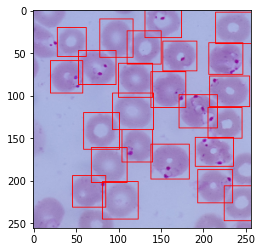

In [78]:
img = cv2.imread(imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]], cv2.IMREAD_COLOR)
list_bbxs = dict_bbxs[imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]]]
img_with_box = bbv.draw_multiple_rectangles(img, [box.tolist()[:4] for box in list_bbxs], bbox_color = (255, 0, 0), thickness=1)
plt.imshow(img_with_box)

In [79]:
with open('../data/pickled/imgs_name.pkl', 'wb') as handle:
    pickle.dump(imgs_name, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/pickled/true_boxes.pkl', 'wb') as handle:
    pickle.dump(true_boxes, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/pickled/dict_bbxs.pkl', 'wb') as handle:
    pickle.dump(dict_bbxs, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/pickled/labels.pkl', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)    

## Polygon to rectangle

In [80]:
filename =  'IMG_20150621_112043'
df_file = df[df['filename'] == filename]
df_file['position'].iloc[-1]

[(4166, 1704),
 (4176, 1688),
 (4184, 1664),
 (4195, 1647),
 (4230, 1633),
 (4272, 1631),
 (4309, 1644),
 (4342, 1679),
 (4341, 1709),
 (4326, 1733),
 (4299, 1758),
 (4265, 1758),
 (4233, 1750),
 (4204, 1735),
 (4174, 1718),
 (4162, 1714)]

In [81]:
rect = df_file['bbx']

In [82]:
df_file['bbx'].tolist()

[[3575, 1304, 3727, 1432],
 [1441, 1202, 1568, 1307],
 [2856, 1398, 2960, 1541],
 [2982, 1460, 3091, 1578],
 [3043, 1651, 3169, 1788],
 [2170, 1937, 2341, 2050],
 [2073, 1836, 2218, 1965],
 [1900, 1873, 2026, 1978],
 [1942, 2102, 2059, 2227],
 [1662, 1906, 1798, 2017],
 [1555, 1781, 1680, 1936],
 [1836, 1731, 2003, 1868],
 [2180, 1712, 2317, 1838],
 [2037, 1745, 2183, 1828],
 [1972, 1613, 2122, 1762],
 [1758, 1743, 1863, 1879],
 [1631, 2139, 1762, 2279],
 [1676, 2264, 1812, 2381],
 [2105, 2169, 2248, 2266],
 [2171, 2075, 2309, 2190],
 [2314, 1846, 2472, 1983],
 [2492, 1789, 2629, 1917],
 [2443, 1567, 2564, 1682],
 [2269, 1504, 2403, 1653],
 [2104, 1636, 2228, 1738],
 [2105, 1531, 2260, 1640],
 [2005, 1454, 2120, 1564],
 [1878, 1525, 2013, 1638],
 [1779, 1612, 1903, 1723],
 [1626, 1601, 1764, 1747],
 [1681, 1476, 1829, 1601],
 [1690, 1362, 1828, 1490],
 [1783, 1320, 1913, 1467],
 [1839, 1280, 1987, 1420],
 [1965, 1267, 2104, 1410],
 [2130, 1385, 2286, 1518],
 [2259, 1309, 2388, 1429],
 

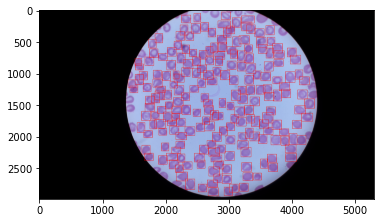

In [83]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
img_with_box = bbv.draw_multiple_rectangles(img, df_file['bbx'].tolist(), bbox_color = (255, 0, 0), thickness=3)
plt.imshow(img_with_box)

# Convert to YOLO format

In [84]:
with open('../data/pickled/true_boxes.pkl', 'rb') as handle:
    true_boxes = pickle.load(handle)
with open('../data/pickled/dict_bbxs.pkl', 'rb') as handle:
    dict_bbxs = pickle.load(handle)
with open('../data/pickled/labels.pkl', 'rb') as handle:
    df = pickle.load(handle)    

### Test train split patient level

In [85]:
df.reset_index(drop=True, inplace = True)
df

Patient no - Cell no        cell     comment annotation_type  \
0                       3-1  Uninfected  No_comment         Polygon   
1                       3-2  Uninfected  No_comment         Polygon   
2                       3-3  Uninfected  No_comment         Polygon   
3                       3-4  Uninfected  No_comment         Polygon   
4                       3-5  Uninfected  No_comment         Polygon   
...                     ...         ...         ...             ...   
196929                5-200  Uninfected  No_Comment           Point   
196930                5-201  Uninfected  No_Comment           Point   
196931                5-202  Uninfected  No_Comment           Point   
196932                5-203  Uninfected  No_Comment           Point   
196933                5-204  Uninfected  No_Comment           Point   

       Number of points                                           position  \
0                    14  [(2934, 38), (2955, 33), (2992, 35), (3015, 44...   
1                    15  [(3013, 141), (2993, 144), (2972, 157), (2956,...   
2                    14  [(2730, 135), (2704, 144), (2672, 165), (2661,...   
3                    14  [(2379, 137), (2353, 149), (2334, 169), (2332,...   
4                    14  [(2575, 140), (2548, 145), (2522, 161), (2500,...   
...                 ...                                                ...   
196929                1                                      [(2080, 643)]   
196930                1                                      [(1790, 606)]   
196931                1                                      [(1757, 756)]   
196932                1                                      [(1860, 856)]   
196933                1                                      [(1623, 683)]   

                   filename  \
0       IMG_20150817_103139   
1       IMG_20150817_103139   
2       IMG_20150817_103139   
3       IMG_20150817_103139   
4       IMG_20150817_103139   
...                     ...   
196929  IMG_20151115_181859   
196930  IMG_20151115_181859   
196931  IMG_20151115_181859   
196932  IMG_20151115_181859   
196933  IMG_20151115_181859   

                                                 txt_path  \
0       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
...                                                   ...   
196929  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196930  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196931  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196932  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196933  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                                                 img_path  \
0       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
...                                                   ...   
196929  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196930  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196931  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196932  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196933  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                           bbx  patient_n_path  \
0        [2905, 33, 3033, 131]              40   
1       [2951, 141, 3071, 272]              40   
2       [2658, 135, 2801, 276]              40   
3       [2332, 137, 2454, 265]              40   
4       [2499, 140, 2631, 272]              40   
...                        ...             ...   
196929  [2010, 573, 2150, 71

In [86]:
np.random.seed(2)
train_index = []
for patient_n in df['patient_n_path'].unique():
    df_patient = df.loc[df['patient_n_path'] == patient_n]
    mask = np.random.rand(len(df_patient)) < 0.8
    train_index.extend(df_patient[mask].index)
    print('patient: ', patient_n, ' length train_index: ', len(train_index), len(np.unique(train_index)))

patient:  40  length train_index:  618 618
patient:  13  length train_index:  1348 1348
patient:  89  length train_index:  2028 2028
patient:  201  length train_index:  3072 3072
patient:  202  length train_index:  3964 3964
patient:  47  length train_index:  4954 4954
patient:  148  length train_index:  5586 5586
patient:  16  length train_index:  6302 6302
patient:  87  length train_index:  6839 6839
patient:  203  length train_index:  7857 7857
patient:  121  length train_index:  8452 8452
patient:  50  length train_index:  9314 9314
patient:  138  length train_index:  10129 10129
patient:  60  length train_index:  10806 10806
patient:  204  length train_index:  11856 11856
patient:  3  length train_index:  12663 12663
patient:  10  length train_index:  13575 13575
patient:  205  length train_index:  14702 14702
patient:  206  length train_index:  15909 15909
patient:  83  length train_index:  16562 16562
patient:  207  length train_index:  17634 17634
patient:  95  length train_ind

patient:  84  length train_index:  145993 145993
patient:  91  length train_index:  146622 146622
patient:  57  length train_index:  147496 147496
patient:  85  length train_index:  148193 148193
patient:  109  length train_index:  149157 149157
patient:  107  length train_index:  150083 150083
patient:  23  length train_index:  150890 150890
patient:  117  length train_index:  152004 152004
patient:  244  length train_index:  153001 153001
patient:  61  length train_index:  153713 153713
patient:  43  length train_index:  154612 154612
patient:  128  length train_index:  155597 155597
patient:  11  length train_index:  156335 156335
patient:  17  length train_index:  156832 156832
patient:  119  length train_index:  157636 157636


In [87]:
df['train_test'] = 'test'
df.at[train_index, 'train_test'] = 'train'
df['train_test'].value_counts()

train    157636
test      39298
Name: train_test, dtype: int64

In [88]:
#sanity check
print('percentage train: ', len(df[df['train_test'] == 'train']) / len(df))

percentage train:  0.8004509124884479


In [89]:
#sanity check patient level
for patient_n in df['patient_n_path'].unique():
    df_patient = df.loc[df['patient_n_path'] == patient_n]
    percent_train = len(df_patient[df_patient['train_test'] == 'train']) / len(df_patient)
    print('patient: ', patient_n, ' percentage train: ', percent_train)

patient:  40  percentage train:  0.8015564202334631
patient:  13  percentage train:  0.7969432314410481
patient:  89  percentage train:  0.8095238095238095
patient:  201  percentage train:  0.7963386727688787
patient:  202  percentage train:  0.8221198156682028
patient:  47  percentage train:  0.7983870967741935
patient:  148  percentage train:  0.7959697732997482
patient:  16  percentage train:  0.798216276477146
patient:  87  percentage train:  0.7660485021398002
patient:  203  percentage train:  0.8085782366957903
patient:  121  percentage train:  0.7870370370370371
patient:  50  percentage train:  0.7959372114496768
patient:  138  percentage train:  0.8117529880478087
patient:  60  percentage train:  0.7974087161366313
patient:  204  percentage train:  0.8045977011494253
patient:  3  percentage train:  0.8037848605577689
patient:  10  percentage train:  0.792354474370113
patient:  205  percentage train:  0.7970297029702971
patient:  206  percentage train:  0.7940789473684211
patien

### Test train split patient & img_level

In [90]:
seed_n = 2
random.seed(seed_n)
train_index = []
for patient_n in df['patient_n_path'].unique():
    list_filenames = df.loc[df['patient_n_path'] == patient_n, 'filename'].unique().tolist()
    perct_total = round(len(list_filenames) * 0.8)
    list_filenames_masked = random.sample(list_filenames, perct_total)
    train_index.extend(df.loc[(df['patient_n_path'] == patient_n) & (df['filename'].isin(list_filenames_masked))].index)
    perc_train = len(df.loc[(df['patient_n_path'] == patient_n) & (df['filename'].isin(list_filenames_masked))]) / len(df.loc[(df['patient_n_path'] == patient_n)])
    print('patient: ', patient_n, ' percentage train cells: ', str(perc_train))

patient:  40  percentage train cells:  0.7600518806744487
patient:  13  percentage train cells:  0.8187772925764192
patient:  89  percentage train cells:  0.8023809523809524
patient:  201  percentage train cells:  0.7879481311975591
patient:  202  percentage train cells:  0.7963133640552995
patient:  47  percentage train cells:  0.8032258064516129
patient:  148  percentage train cells:  0.8312342569269522
patient:  16  percentage train cells:  0.7692307692307693
patient:  87  percentage train cells:  0.7617689015691869
patient:  203  percentage train cells:  0.8093725178713265
patient:  121  percentage train cells:  0.8029100529100529
patient:  50  percentage train cells:  0.7839335180055401
patient:  138  percentage train cells:  0.8067729083665338
patient:  60  percentage train cells:  0.7879858657243817
patient:  204  percentage train cells:  0.8022988505747126
patient:  3  percentage train cells:  0.8057768924302788
patient:  10  percentage train cells:  0.8297132927888793
patient:

patient:  238  percentage train cells:  0.8110355253212396
patient:  46  percentage train cells:  0.8009188361408882
patient:  35  percentage train cells:  0.8193891102257637
patient:  5  percentage train cells:  0.8043087971274686
patient:  102  percentage train cells:  0.8226059654631083
patient:  146  percentage train cells:  0.8119935170178282
patient:  129  percentage train cells:  0.8077777777777778
patient:  9  percentage train cells:  0.7528089887640449
patient:  137  percentage train cells:  0.8074277854195323
patient:  115  percentage train cells:  0.804945054945055
patient:  66  percentage train cells:  0.8169014084507042
patient:  42  percentage train cells:  0.7718780727630286
patient:  70  percentage train cells:  0.8104008667388949
patient:  36  percentage train cells:  0.816350710900474
patient:  105  percentage train cells:  0.7936404931862427
patient:  12  percentage train cells:  0.7365269461077845
patient:  120  percentage train cells:  0.8256130790190735
patient:  

In [91]:
df['train_test'] = 'test'
df.at[train_index, 'train_test'] = 'train'
df['train_test'].value_counts()

train    157849
test      39085
Name: train_test, dtype: int64

In [92]:
#sanity check
print('percentage train: ', len(df[df['train_test'] == 'train']) / len(df))

percentage train:  0.8015324931195222


In [93]:
#sanity check patient level
for patient_n in df['patient_n_path'].unique():
    df_patient = df.loc[df['patient_n_path'] == patient_n]
    percent_train = len(df_patient[df_patient['train_test'] == 'train']) / len(df_patient)
    print('patient: ', patient_n, ' percentage train: ', percent_train)

patient:  40  percentage train:  0.7600518806744487
patient:  13  percentage train:  0.8187772925764192
patient:  89  percentage train:  0.8023809523809524
patient:  201  percentage train:  0.7879481311975591
patient:  202  percentage train:  0.7963133640552995
patient:  47  percentage train:  0.8032258064516129
patient:  148  percentage train:  0.8312342569269522
patient:  16  percentage train:  0.7692307692307693
patient:  87  percentage train:  0.7617689015691869
patient:  203  percentage train:  0.8093725178713265
patient:  121  percentage train:  0.8029100529100529
patient:  50  percentage train:  0.7839335180055401
patient:  138  percentage train:  0.8067729083665338
patient:  60  percentage train:  0.7879858657243817
patient:  204  percentage train:  0.8022988505747126
patient:  3  percentage train:  0.8057768924302788
patient:  10  percentage train:  0.8297132927888793
patient:  205  percentage train:  0.804101838755304
patient:  206  percentage train:  0.8111842105263158
patie

In [94]:
df.head()

Patient no - Cell no        cell     comment annotation_type  \
0                  3-1  Uninfected  No_comment         Polygon   
1                  3-2  Uninfected  No_comment         Polygon   
2                  3-3  Uninfected  No_comment         Polygon   
3                  3-4  Uninfected  No_comment         Polygon   
4                  3-5  Uninfected  No_comment         Polygon   

  Number of points                                           position  \
0               14  [(2934, 38), (2955, 33), (2992, 35), (3015, 44...   
1               15  [(3013, 141), (2993, 144), (2972, 157), (2956,...   
2               14  [(2730, 135), (2704, 144), (2672, 165), (2661,...   
3               14  [(2379, 137), (2353, 149), (2334, 169), (2332,...   
4               14  [(2575, 140), (2548, 145), (2522, 161), (2500,...   

              filename                                           txt_path  \
0  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                                            img_path                     bbx  \
0  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   [2905, 33, 3033, 131]   
1  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2951, 141, 3071, 272]   
2  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2658, 135, 2801, 276]   
3  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2332, 137, 2454, 265]   
4  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2499, 140, 2631, 272]   

   patient_n_path                                  adjusted_position  \
0              40  [(1652, 29), (1673, 24), (1710, 26), (1733, 35...   
1              40  [(1731, 132), (1711, 135), (1690, 148), (1674,...   
2              40  [(1448, 126), (1422, 135), (1390, 156), (1379,...   
3              40  [(1097, 128), (1071, 140), (1052, 160), (1050,...   
4              40  [(1293, 131), (1266, 136), (1240, 152), (1218,...   

                                 img_path_fit2circle  \
0  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
1  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
2  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
3  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
4  ../data/fit_to_circle/cropped_P40_IMG_20150817...   

                                mask_path_fit2circle            adjusted_bbx  \
0  ../data/fit_to_circle/masks_cropped_P40_IMG_20...   [1623, 24, 1751, 122]   
1  ../data/fit_to_circle/masks_cropped_P40_IMG_20...  [1669, 132, 1789, 263]   
2  ../data/fit_to_circle/masks_cropped_P40_IMG_20...  [1376, 126, 1519, 267]   
3  ../data/fit_to_circle/masks_cropped_P40_IMG_20...  [1050, 128, 1172, 256]   
4  ../data/fit_to_circle/masks_cropped_P40_IMG_20...  [1217, 131, 1349, 263]   

                                    mask_path train_test  
0  ../data/masks/mask_IMG_20150817_103139.png      train  
1  ../data/masks/mask_IMG_20150817_103139.png      train  
2  ../data/masks/mask_IMG_20150817_103139.png      train  
3  ../data/masks/mask_IMG_20150817_103139.png      train  
4  ../data/masks/mask_IMG_20150817_103139.png      train

### Create test and train folders fit to circle

../data/fit_to_circle/cropped_P206_IMG_20151112_164625_masks.png


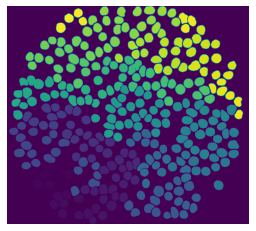

In [127]:
mask_path_fit2circle = df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path_fit2circle'] == '../data/fit_to_circle/cropped_P206_IMG_20151112_164625.png') , 'mask_path_fit2circle'][19612]
print(mask_path_fit2circle)
masks_f2c = plt.imread(mask_path_fit2circle, cv2.IMREAD_COLOR)
plt.imshow(masks_f2c)
plt.axis('off')
plt.show()

copy img to training:  IMG_20150817_103139
copy mask to training:  IMG_20150817_103139
copy img to training:  IMG_20150817_103303
copy mask to training:  IMG_20150817_103303
copy img to test:  IMG_20150817_102702
copy mask to test:  IMG_20150817_102702
../data/fit_to_circle/test/cropped_P40_IMG_20150817_102702_masks.png
<class 'numpy.ndarray'> (1024, 1024)


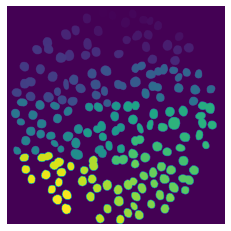

copy img to training:  IMG_20150817_102823
copy mask to training:  IMG_20150817_102823
copy img to training:  IMG_20150817_103901
copy mask to training:  IMG_20150817_103901
copy img to training:  IMG_20150725_123938
copy mask to training:  IMG_20150725_123938
copy img to training:  IMG_20150725_125213
copy mask to training:  IMG_20150725_125213
copy img to training:  IMG_20150725_125847
copy mask to training:  IMG_20150725_125847
copy img to test:  IMG_20150725_124606
copy mask to test:  IMG_20150725_124606
../data/fit_to_circle/test/cropped_P13_IMG_20150725_124606_masks.png
<class 'numpy.ndarray'> (1024, 1024)


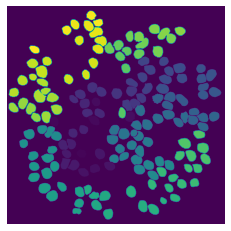

copy img to training:  IMG_20150725_124830
copy mask to training:  IMG_20150725_124830
copy img to training:  IMG_20151004_130810
copy mask to training:  IMG_20151004_130810
copy img to test:  IMG_20151004_130408
copy mask to test:  IMG_20151004_130408
../data/fit_to_circle/test/cropped_P89_IMG_20151004_130408_masks.png
<class 'numpy.ndarray'> (1024, 1024)


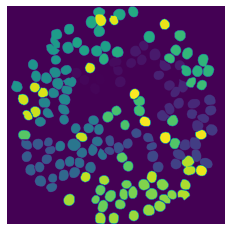

copy img to training:  IMG_20151004_130549
copy mask to training:  IMG_20151004_130549
copy img to training:  IMG_20151004_131030
copy mask to training:  IMG_20151004_131030
copy img to training:  IMG_20151004_131129
copy mask to training:  IMG_20151004_131129
copy img to test:  IMG_20151029_162934
copy mask to test:  IMG_20151029_162934
../data/fit_to_circle/test/cropped_P201_IMG_20151029_162934_masks.png
<class 'numpy.ndarray'> (1024, 1024)


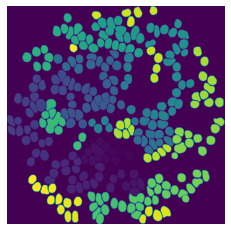

copy img to training:  IMG_20151029_162357
copy mask to training:  IMG_20151029_162357
copy img to training:  IMG_20151029_162605
copy mask to training:  IMG_20151029_162605
copy img to training:  IMG_20151029_162439
copy mask to training:  IMG_20151029_162439
copy img to training:  IMG_20151029_162834
copy mask to training:  IMG_20151029_162834
copy img to test:  IMG_20151112_153246
copy mask to test:  IMG_20151112_153246
../data/fit_to_circle/test/cropped_P202_IMG_20151112_153246_masks.png
<class 'numpy.ndarray'> (1024, 1024)


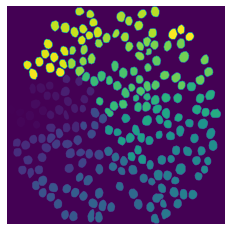

copy img to training:  IMG_20151112_153041
copy mask to training:  IMG_20151112_153041
copy img to training:  IMG_20151112_153106
copy mask to training:  IMG_20151112_153106
copy img to training:  IMG_20151112_153147
copy mask to training:  IMG_20151112_153147
copy img to training:  IMG_20151112_152234
copy mask to training:  IMG_20151112_152234
copy img to training:  IMG_20150820_124943
copy mask to training:  IMG_20150820_124943
copy img to training:  IMG_20150820_125057
copy mask to training:  IMG_20150820_125057
copy img to training:  IMG_20150820_124025
copy mask to training:  IMG_20150820_124025
copy img to test:  IMG_20150820_123717
copy mask to test:  IMG_20150820_123717
../data/fit_to_circle/test/cropped_P47_IMG_20150820_123717_masks.png
<class 'numpy.ndarray'> (1024, 1024)


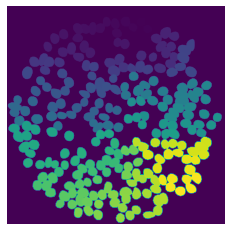

copy img to training:  IMG_20150820_124259
copy mask to training:  IMG_20150820_124259
copy img to training:  IMG_20151203_153036
copy mask to training:  IMG_20151203_153036
copy img to training:  IMG_20151203_153713
copy mask to training:  IMG_20151203_153713
copy img to training:  IMG_20151203_153410
copy mask to training:  IMG_20151203_153410
copy img to training:  IMG_20151203_152841
copy mask to training:  IMG_20151203_152841
copy img to test:  IMG_20151203_154111
copy mask to test:  IMG_20151203_154111
../data/fit_to_circle/test/cropped_P148_IMG_20151203_154111_masks.png
<class 'numpy.ndarray'> (1024, 1024)


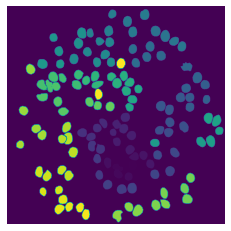

copy img to training:  IMG_20150728_123154
copy mask to training:  IMG_20150728_123154
copy img to training:  IMG_20150728_121151
copy mask to training:  IMG_20150728_121151
copy img to training:  IMG_20150728_121350
copy mask to training:  IMG_20150728_121350
copy img to test:  IMG_20150728_123237
copy mask to test:  IMG_20150728_123237
../data/fit_to_circle/test/cropped_P16_IMG_20150728_123237_masks.png
<class 'numpy.ndarray'> (1024, 1024)


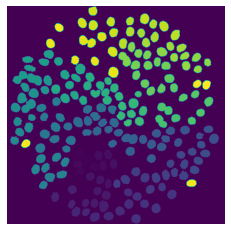

copy img to training:  IMG_20150728_123510
copy mask to training:  IMG_20150728_123510
copy img to training:  IMG_20151004_104623
copy mask to training:  IMG_20151004_104623
copy img to training:  IMG_20151004_104728
copy mask to training:  IMG_20151004_104728
copy img to test:  IMG_20151004_104408
copy mask to test:  IMG_20151004_104408
../data/fit_to_circle/test/cropped_P87_IMG_20151004_104408_masks.png
<class 'numpy.ndarray'> (1024, 1024)


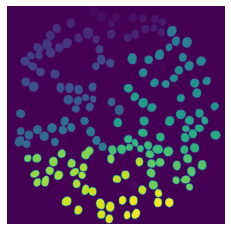

copy img to training:  IMG_20151004_104813
copy mask to training:  IMG_20151004_104813
copy img to training:  IMG_20151004_104441
copy mask to training:  IMG_20151004_104441
copy img to training:  IMG_20151106_135337
copy mask to training:  IMG_20151106_135337
copy img to training:  IMG_20151106_134931
copy mask to training:  IMG_20151106_134931
copy img to training:  IMG_20151106_135228
copy mask to training:  IMG_20151106_135228
copy img to training:  IMG_20151106_135653
copy mask to training:  IMG_20151106_135653
copy img to test:  IMG_20151106_134733
copy mask to test:  IMG_20151106_134733
../data/fit_to_circle/test/cropped_P203_IMG_20151106_134733_masks.png
<class 'numpy.ndarray'> (1024, 1024)


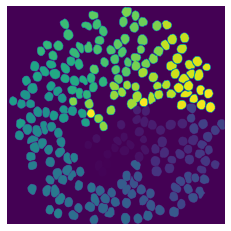

copy img to test:  IMG_20151116_093109
copy mask to test:  IMG_20151116_093109
../data/fit_to_circle/test/cropped_P121_IMG_20151116_093109_masks.png
<class 'numpy.ndarray'> (1024, 1024)


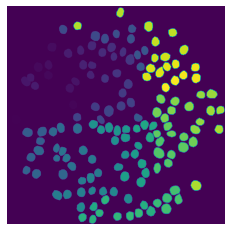

copy img to training:  IMG_20151116_092925
copy mask to training:  IMG_20151116_092925
copy img to training:  IMG_20151116_093748
copy mask to training:  IMG_20151116_093748
copy img to training:  IMG_20151116_093704
copy mask to training:  IMG_20151116_093704
copy img to training:  IMG_20151116_093629
copy mask to training:  IMG_20151116_093629
copy img to test:  IMG_20150820_162813
copy mask to test:  IMG_20150820_162813
../data/fit_to_circle/test/cropped_P50_IMG_20150820_162813_masks.png
<class 'numpy.ndarray'> (1024, 1024)


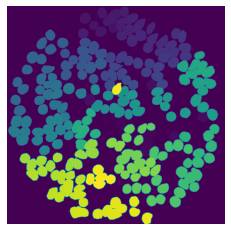

copy img to training:  IMG_20150820_162153
copy mask to training:  IMG_20150820_162153
copy img to training:  IMG_20150820_163347
copy mask to training:  IMG_20150820_163347
copy img to training:  IMG_20150820_162504
copy mask to training:  IMG_20150820_162504
copy img to training:  IMG_20150820_162300
copy mask to training:  IMG_20150820_162300
copy img to test:  IMG_20151201_142942
copy mask to test:  IMG_20151201_142942
../data/fit_to_circle/test/cropped_P138_IMG_20151201_142942_masks.png
<class 'numpy.ndarray'> (1024, 1024)


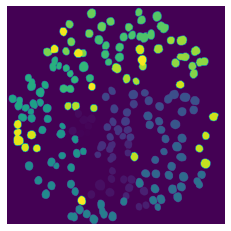

copy img to training:  IMG_20151201_143025
copy mask to training:  IMG_20151201_143025
copy img to training:  IMG_20151201_141604
copy mask to training:  IMG_20151201_141604
copy img to training:  IMG_20151201_142846
copy mask to training:  IMG_20151201_142846
copy img to training:  IMG_20151201_142514
copy mask to training:  IMG_20151201_142514
copy img to test:  IMG_20150918_141001
copy mask to test:  IMG_20150918_141001
../data/fit_to_circle/test/cropped_P60_IMG_20150918_141001_masks.png
<class 'numpy.ndarray'> (1024, 1024)


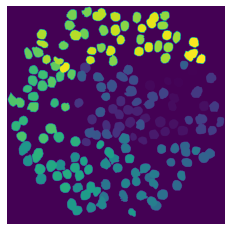

copy img to training:  IMG_20150918_141129
copy mask to training:  IMG_20150918_141129
copy img to training:  IMG_20150918_141351
copy mask to training:  IMG_20150918_141351
copy img to training:  IMG_20150918_140900
copy mask to training:  IMG_20150918_140900
copy img to training:  IMG_20150918_141314
copy mask to training:  IMG_20150918_141314
copy img to test:  IMG_20151106_112422
copy mask to test:  IMG_20151106_112422
../data/fit_to_circle/test/cropped_P204_IMG_20151106_112422_masks.png
<class 'numpy.ndarray'> (1024, 1024)


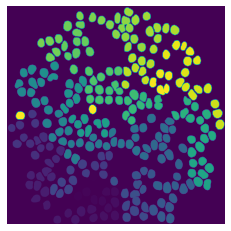

copy img to training:  IMG_20151106_112603
copy mask to training:  IMG_20151106_112603
copy img to training:  IMG_20151106_112853
copy mask to training:  IMG_20151106_112853
copy img to training:  IMG_20151106_112252
copy mask to training:  IMG_20151106_112252
copy img to training:  IMG_20151106_112759
copy mask to training:  IMG_20151106_112759
copy img to test:  IMG_20150621_112138
copy mask to test:  IMG_20150621_112138
../data/fit_to_circle/test/cropped_P3_IMG_20150621_112138_masks.png
<class 'numpy.ndarray'> (1024, 1024)


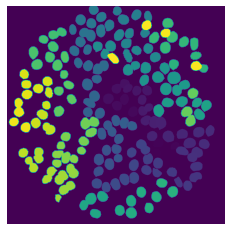

copy img to training:  IMG_20150621_112023
copy mask to training:  IMG_20150621_112023
copy img to training:  IMG_20150621_112043
copy mask to training:  IMG_20150621_112043
copy img to training:  IMG_20150621_112227
copy mask to training:  IMG_20150621_112227
copy img to training:  IMG_20150621_112116
copy mask to training:  IMG_20150621_112116
copy img to training:  IMG_20150724_102330
copy mask to training:  IMG_20150724_102330
copy img to training:  IMG_20150724_103233
copy mask to training:  IMG_20150724_103233
copy img to test:  IMG_20150724_102843
copy mask to test:  IMG_20150724_102843
../data/fit_to_circle/test/cropped_P10_IMG_20150724_102843_masks.png
<class 'numpy.ndarray'> (1024, 1024)


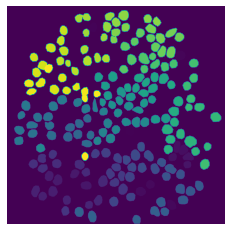

copy img to training:  IMG_20150724_102951
copy mask to training:  IMG_20150724_102951
copy img to training:  IMG_20150724_103054
copy mask to training:  IMG_20150724_103054
copy img to test:  IMG_20151106_110230
copy mask to test:  IMG_20151106_110230
../data/fit_to_circle/test/cropped_P205_IMG_20151106_110230_masks.png
<class 'numpy.ndarray'> (1024, 1024)


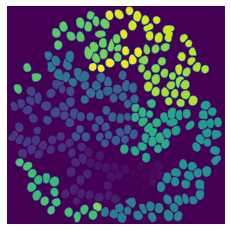

copy img to training:  IMG_20151106_105834
copy mask to training:  IMG_20151106_105834
copy img to training:  IMG_20151106_105437
copy mask to training:  IMG_20151106_105437
copy img to training:  IMG_20151106_110411
copy mask to training:  IMG_20151106_110411
copy img to training:  IMG_20151106_105941
copy mask to training:  IMG_20151106_105941
copy img to training:  IMG_20151112_164723
copy mask to training:  IMG_20151112_164723
copy img to training:  IMG_20151112_165055
copy mask to training:  IMG_20151112_165055
copy img to training:  IMG_20151112_164834
copy mask to training:  IMG_20151112_164834
copy img to training:  IMG_20151112_164625
copy mask to training:  IMG_20151112_164625
copy img to test:  IMG_20151112_164918
copy mask to test:  IMG_20151112_164918
../data/fit_to_circle/test/cropped_P206_IMG_20151112_164918_masks.png
<class 'numpy.ndarray'> (1024, 1024)


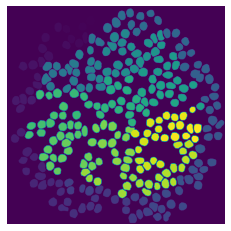

copy img to training:  IMG_20151002_144610
copy mask to training:  IMG_20151002_144610
copy img to test:  IMG_20151002_144341
copy mask to test:  IMG_20151002_144341
../data/fit_to_circle/test/cropped_P83_IMG_20151002_144341_masks.png
<class 'numpy.ndarray'> (1024, 1024)


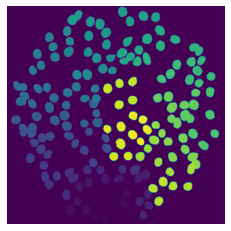

copy img to training:  IMG_20151002_144855
copy mask to training:  IMG_20151002_144855
copy img to training:  IMG_20151002_145014
copy mask to training:  IMG_20151002_145014
copy img to training:  IMG_20151002_145330
copy mask to training:  IMG_20151002_145330
copy img to training:  IMG_20151112_131255
copy mask to training:  IMG_20151112_131255
copy img to test:  IMG_20151112_131622
copy mask to test:  IMG_20151112_131622
../data/fit_to_circle/test/cropped_P207_IMG_20151112_131622_masks.png
<class 'numpy.ndarray'> (1024, 1024)


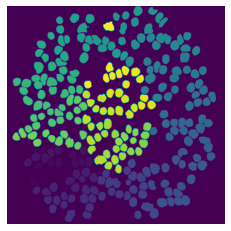

copy img to training:  IMG_20151112_131546
copy mask to training:  IMG_20151112_131546
copy img to training:  IMG_20151112_131408
copy mask to training:  IMG_20151112_131408
copy img to training:  IMG_20151112_131731
copy mask to training:  IMG_20151112_131731
copy img to training:  IMG_20151005_121656
copy mask to training:  IMG_20151005_121656
copy img to training:  IMG_20151005_121425
copy mask to training:  IMG_20151005_121425
copy img to test:  IMG_20151005_121554
copy mask to test:  IMG_20151005_121554
../data/fit_to_circle/test/cropped_P95_IMG_20151005_121554_masks.png
<class 'numpy.ndarray'> (1024, 1024)


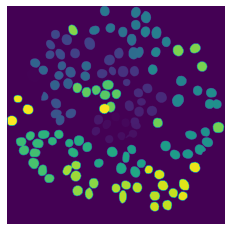

copy img to training:  IMG_20151005_121343
copy mask to training:  IMG_20151005_121343
copy img to training:  IMG_20151005_121048
copy mask to training:  IMG_20151005_121048
copy img to training:  IMG_20150819_133447
copy mask to training:  IMG_20150819_133447
copy img to training:  IMG_20150819_134326
copy mask to training:  IMG_20150819_134326
copy img to test:  IMG_20150819_133236
copy mask to test:  IMG_20150819_133236
../data/fit_to_circle/test/cropped_P29_IMG_20150819_133236_masks.png
<class 'numpy.ndarray'> (1024, 1024)


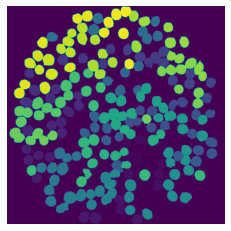

copy img to training:  IMG_20150819_133350
copy mask to training:  IMG_20150819_133350
copy img to training:  IMG_20150819_134112
copy mask to training:  IMG_20150819_134112
copy img to training:  IMG_20150930_162315
copy mask to training:  IMG_20150930_162315
copy img to training:  IMG_20150930_161825
copy mask to training:  IMG_20150930_161825
copy img to test:  IMG_20150930_163018
copy mask to test:  IMG_20150930_163018
../data/fit_to_circle/test/cropped_P76_IMG_20150930_163018_masks.png
<class 'numpy.ndarray'> (1024, 1024)


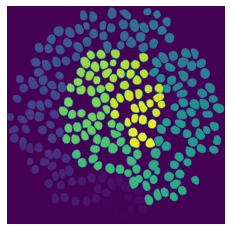

copy img to training:  IMG_20150930_163156
copy mask to training:  IMG_20150930_163156
copy img to training:  IMG_20150930_162038
copy mask to training:  IMG_20150930_162038
copy img to training:  IMG_20150819_121456
copy mask to training:  IMG_20150819_121456
copy img to training:  IMG_20150819_115417
copy mask to training:  IMG_20150819_115417
copy img to training:  IMG_20150819_121240
copy mask to training:  IMG_20150819_121240
copy img to test:  IMG_20150819_121053
copy mask to test:  IMG_20150819_121053
../data/fit_to_circle/test/cropped_P28_IMG_20150819_121053_masks.png
<class 'numpy.ndarray'> (1024, 1024)


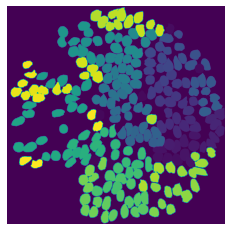

copy img to training:  IMG_20150819_115955
copy mask to training:  IMG_20150819_115955
copy img to training:  IMG_20150611_104609
copy mask to training:  IMG_20150611_104609
copy img to training:  IMG_20150611_104510
copy mask to training:  IMG_20150611_104510
copy img to training:  IMG_20150611_104404
copy mask to training:  IMG_20150611_104404
copy img to training:  IMG_20150611_104753
copy mask to training:  IMG_20150611_104753
copy img to test:  IMG_20150611_104824
copy mask to test:  IMG_20150611_104824
../data/fit_to_circle/test/cropped_P208_IMG_20150611_104824_masks.png
<class 'numpy.ndarray'> (1024, 1024)


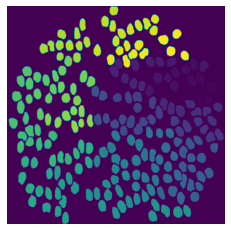

copy img to training:  IMG_20151207_114605
copy mask to training:  IMG_20151207_114605
copy img to test:  IMG_20151207_114345
copy mask to test:  IMG_20151207_114345
../data/fit_to_circle/test/cropped_P209_IMG_20151207_114345_masks.png
<class 'numpy.ndarray'> (1024, 1024)


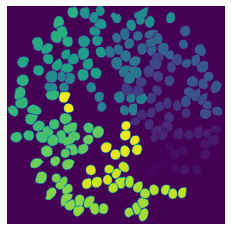

copy img to training:  IMG_20151207_114038
copy mask to training:  IMG_20151207_114038
copy img to training:  IMG_20151207_114653
copy mask to training:  IMG_20151207_114653
copy img to training:  IMG_20151207_114444
copy mask to training:  IMG_20151207_114444
copy img to training:  IMG_20150714_093636
copy mask to training:  IMG_20150714_093636
copy img to training:  IMG_20150714_093600
copy mask to training:  IMG_20150714_093600
copy img to training:  IMG_20150714_093806
copy mask to training:  IMG_20150714_093806
copy img to test:  IMG_20150714_093715
copy mask to test:  IMG_20150714_093715
../data/fit_to_circle/test/cropped_P8_IMG_20150714_093715_masks.png
<class 'numpy.ndarray'> (1024, 1024)


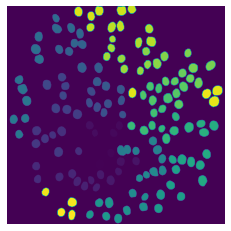

copy img to training:  IMG_20150714_093512
copy mask to training:  IMG_20150714_093512
copy img to training:  IMG_20150813_131330
copy mask to training:  IMG_20150813_131330
copy img to test:  IMG_20150813_130332
copy mask to test:  IMG_20150813_130332
../data/fit_to_circle/test/cropped_P31_IMG_20150813_130332_masks.png
<class 'numpy.ndarray'> (1024, 1024)


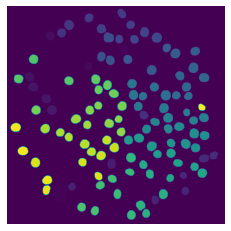

copy img to training:  IMG_20150813_130849
copy mask to training:  IMG_20150813_130849
copy img to training:  IMG_20150813_130510
copy mask to training:  IMG_20150813_130510
copy img to training:  IMG_20150813_131022
copy mask to training:  IMG_20150813_131022
copy img to training:  IMG_20150821_165118
copy mask to training:  IMG_20150821_165118
copy img to training:  IMG_20150821_170403
copy mask to training:  IMG_20150821_170403
copy img to test:  IMG_20150821_170021
copy mask to test:  IMG_20150821_170021
../data/fit_to_circle/test/cropped_P55_IMG_20150821_170021_masks.png
<class 'numpy.ndarray'> (1024, 1024)


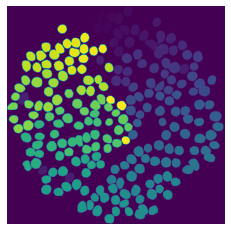

copy img to training:  IMG_20150821_170249
copy mask to training:  IMG_20150821_170249
copy img to training:  IMG_20150821_165519
copy mask to training:  IMG_20150821_165519
copy img to training:  IMG_20150729_104027
copy mask to training:  IMG_20150729_104027
copy img to training:  IMG_20150729_110134
copy mask to training:  IMG_20150729_110134
copy img to training:  IMG_20150729_110305
copy mask to training:  IMG_20150729_110305
copy img to test:  IMG_20150729_111518
copy mask to test:  IMG_20150729_111518
../data/fit_to_circle/test/cropped_P18_IMG_20150729_111518_masks.png
<class 'numpy.ndarray'> (1024, 1024)


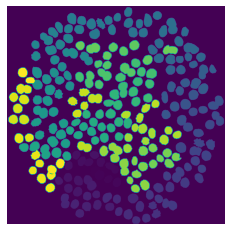

copy img to training:  IMG_20150729_110457
copy mask to training:  IMG_20150729_110457
copy img to training:  IMG_20150813_162016
copy mask to training:  IMG_20150813_162016
copy img to test:  IMG_20150813_163120
copy mask to test:  IMG_20150813_163120
../data/fit_to_circle/test/cropped_P32_IMG_20150813_163120_masks.png
<class 'numpy.ndarray'> (1024, 1024)


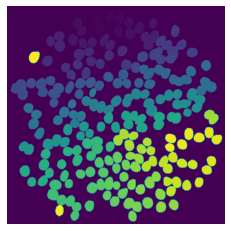

copy img to training:  IMG_20150813_161634
copy mask to training:  IMG_20150813_161634
copy img to training:  IMG_20150813_162554
copy mask to training:  IMG_20150813_162554
copy img to training:  IMG_20150813_162146
copy mask to training:  IMG_20150813_162146
copy img to training:  IMG_20151119_143039
copy mask to training:  IMG_20151119_143039
copy img to test:  IMG_20151118_163539
copy mask to test:  IMG_20151118_163539
../data/fit_to_circle/test/cropped_P130_IMG_20151118_163539_masks.png
<class 'numpy.ndarray'> (1024, 1024)


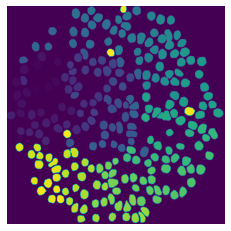

copy img to training:  IMG_20151119_143212
copy mask to training:  IMG_20151119_143212
copy img to training:  IMG_20151118_172913
copy mask to training:  IMG_20151118_172913
copy img to training:  IMG_20151118_173039
copy mask to training:  IMG_20151118_173039
len counter:  165
len counter_train:  132
len counter_test:  33


In [139]:
dict_img_path_fit2circle = dict(zip(df['img_path'], df['img_path_fit2circle']))
dict_mask_path_fit2circle = dict(zip(df['img_path'], df['mask_path_fit2circle']))
dict_patient_n = dict(zip(df['img_path'], df['patient_n_path']))
dict_filename = dict(zip(df['img_path'], df['filename']))

counter = 0
counter_train = 0
counter_test = 0
resize = 1024

outdir_test = f'../data/fit_to_circle/test'
outdir_train = f'../data/fit_to_circle/train'
check_if_outdir_test = os.path.isdir(outdir_test)
check_if_outdir_train = os.path.isdir(outdir_train)
if not check_if_outdir_test:
    os.makedirs(outdir_test)
if not check_if_outdir_train:
    os.makedirs(outdir_train)

for img_path in df.loc[(df['annotation_type'] == 'Polygon'), 'img_path'].unique():
    counter += 1

    patient_n_path = dict_patient_n[img_path]
    filename = dict_filename[img_path]
    img_path_fit2circle = dict_img_path_fit2circle[img_path]
    mask_path_fit2circle = dict_mask_path_fit2circle[img_path]
    
    # copy to train folder
    if not df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path) & (df['train_test'] == 'train'), 'img_path'].empty:
        counter_train += 1
        print('copy img to training: ', filename)
        img = cv2.imread(img_path_fit2circle, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (resize, resize))
        outname_img = os.path.join(outdir_train + '/cropped_P' +  str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_img, img)
        print('copy mask to training: ', filename)
        mask = cv2.imread(mask_path_fit2circle, cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (resize, resize))
        outname_mask = os.path.join(outdir_train + '/cropped_P' +  str(patient_n_path) + '_' + filename + '_masks.png')
        cv2.imwrite(outname_mask, mask)
        
    # copy to test folder
    if not df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path) & (df['train_test'] == 'test'), 'img_path'].empty:
        counter_test +=1
        print('copy img to test: ', filename)
        img = cv2.imread(img_path_fit2circle, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (resize, resize))
        outname_img = os.path.join(outdir_test + '/cropped_P' +   str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_img, img)
        print('copy mask to test: ', filename)
        mask = cv2.imread(mask_path_fit2circle,cv2.IMREAD_UNCHANGED )
        mask = cv2.resize(mask, (resize, resize))
        outname_mask = os.path.join(outdir_test + '/cropped_P' +   str(patient_n_path) + '_' + filename + '_masks.png')
        cv2.imwrite(outname_mask, mask)

        
print('len counter: ', counter)
print('len counter_train: ', counter_train)
print('len counter_test: ', counter_test)


In [97]:
dict_img_path_fit2circle = dict(zip(df['img_path'], df['img_path_fit2circle']))
dict_mask_path_fit2circle = dict(zip(df['img_path'], df['mask_path_fit2circle']))
dict_patient_n = dict(zip(df['img_path'], df['patient_n_path']))
dict_filename = dict(zip(df['img_path'], df['filename']))

counter = 0
counter_train = 0
counter_test = 0
resize = 512

outdir_test_img = f'../data/fit_to_circle/test_img'
outdir_train_img = f'../data/fit_to_circle/train_img'
outdir_test_mask = f'../data/fit_to_circle/test_mask'
outdir_train_mask = f'../data/fit_to_circle/train_mask'
check_if_outdir_test_img = os.path.isdir(outdir_test_img)
check_if_outdir_train_img = os.path.isdir(outdir_train_img)
check_if_outdir_test_mask = os.path.isdir(outdir_test_mask)
check_if_outdir_train_mask = os.path.isdir(outdir_train_mask)
if not check_if_outdir_test_img:
    os.makedirs(outdir_test_img)
if not check_if_outdir_train_img:
    os.makedirs(outdir_train_img)
if not check_if_outdir_test_mask:
    os.makedirs(outdir_test_mask)
if not check_if_outdir_train_mask:
    os.makedirs(outdir_train_mask)
    

for img_path in df.loc[(df['annotation_type'] == 'Polygon'), 'img_path'].unique():
    counter += 1

    patient_n_path = dict_patient_n[img_path]
    filename = dict_filename[img_path]
    img_path_fit2circle = dict_img_path_fit2circle[img_path]
    mask_path_fit2circle = dict_mask_path_fit2circle[img_path]
    
    # copy to train folder
    if not df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path) & (df['train_test'] == 'train'), 'img_path'].empty:
        counter_train += 1
        print('copy img to training: ', filename)
        img = cv2.imread(img_path_fit2circle, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (resize, resize))
        outname_img_train = os.path.join(outdir_train_img + '/cropped_P' + str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_img_train, img)
        print('copy mask to training: ', filename)
        mask = plt.imread(mask_path_fit2circle)
        mask = cv2.resize(mask, (resize, resize))
        outname_mask_train = os.path.join(outdir_train_mask + '/cropped_P' + str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_mask_train, mask)
        
    # copy to test folder
    if not df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path) & (df['train_test'] == 'test'), 'img_path'].empty:
        counter_test +=1
        print('copy img to test: ', filename)
        img = cv2.imread(img_path_fit2circle, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (resize, resize))
        outname_img_test = os.path.join(outdir_test_img + '/cropped_P' + str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_img_test, img)
        print('copy mask to test: ', filename)
        mask = plt.imread(mask_path_fit2circle)
        mask = cv2.resize(mask, (resize, resize))
        outname_mask_test = os.path.join(outdir_test_mask + '/cropped_P' + str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_mask_test, mask)
        
print('len counter: ', counter)
print('len counter_train: ', counter_train)
print('len counter_test: ', counter_test)


copy img to training:  IMG_20150817_103139
copy mask to training:  IMG_20150817_103139
copy img to training:  IMG_20150817_103303
copy mask to training:  IMG_20150817_103303
copy img to test:  IMG_20150817_102702
copy mask to test:  IMG_20150817_102702
copy img to training:  IMG_20150817_102823
copy mask to training:  IMG_20150817_102823
copy img to training:  IMG_20150817_103901
copy mask to training:  IMG_20150817_103901
copy img to training:  IMG_20150725_123938
copy mask to training:  IMG_20150725_123938
copy img to training:  IMG_20150725_125213
copy mask to training:  IMG_20150725_125213
copy img to training:  IMG_20150725_125847
copy mask to training:  IMG_20150725_125847
copy img to test:  IMG_20150725_124606
copy mask to test:  IMG_20150725_124606
copy img to training:  IMG_20150725_124830
copy mask to training:  IMG_20150725_124830
copy img to training:  IMG_20151004_130810
copy mask to training:  IMG_20151004_130810
copy img to test:  IMG_20151004_130408
copy mask to test:  

copy img to test:  IMG_20151002_144341
copy mask to test:  IMG_20151002_144341
copy img to training:  IMG_20151002_144855
copy mask to training:  IMG_20151002_144855
copy img to training:  IMG_20151002_145014
copy mask to training:  IMG_20151002_145014
copy img to training:  IMG_20151002_145330
copy mask to training:  IMG_20151002_145330
copy img to training:  IMG_20151112_131255
copy mask to training:  IMG_20151112_131255
copy img to test:  IMG_20151112_131622
copy mask to test:  IMG_20151112_131622
copy img to training:  IMG_20151112_131546
copy mask to training:  IMG_20151112_131546
copy img to training:  IMG_20151112_131408
copy mask to training:  IMG_20151112_131408
copy img to training:  IMG_20151112_131731
copy mask to training:  IMG_20151112_131731
copy img to training:  IMG_20151005_121656
copy mask to training:  IMG_20151005_121656
copy img to training:  IMG_20151005_121425
copy mask to training:  IMG_20151005_121425
copy img to test:  IMG_20151005_121554
copy mask to test:  

### Save Polygon to YOLO for Poly Yolo

In [21]:
# produce textfiles for all elements in the train and validation dataset
# FORMAT:
# path_to\image1.jpg x1,y1,x2,y2,class,p1x,p1y,pnx,pny x1,y1,x2,y2,class,p1x,p1y,pnx,pny
previous_row = '1'
file = open('../data/fit_to_circle/poly_yolo_train.txt',"w+")
for img_path_fit_to_circle in df.loc[(df['annotation_type'] == 'Polygon') &  
                                        (df['train_test'] == 'train'), 'img_path_fit2circle'].unique():
    #print(img_path_fit_to_circle)
    file.write(str(img_path_fit_to_circle) + ' ')
    for index, row in df[df['img_path_fit2circle'] == img_path_fit_to_circle].iterrows():
        if row is not previous_row:
            file.write(str(row['adjusted_bbx'][0]) + ',' +
                       str(row['adjusted_bbx'][1]) + ',' +
                       str(row['adjusted_bbx'][2]) + ',' +
                       str(row['adjusted_bbx'][3]) + ',' +
                       str(row['cell']) + ','  +
                        ''.join(str(str(poly[0]) + ',' + str(poly[1]) + ',') for poly in row['adjusted_position'])                        + ' ')
    file.write('\n')
    previous_row = row
file.close()

In [22]:
# produce textfiles for all elements in the train and validation dataset
# FORMAT:
# path_to\image1.jpg x1,y1,x2,y2,class,p1x,p1y,pnx,pny x1,y1,x2,y2,class,p1x,p1y,pnx,pny
previous_row = '1'
file = open('../data/fit_to_circle/poly_yolo_test.txt',"w+")
for img_path_fit_to_circle in df.loc[(df['annotation_type'] == 'Polygon') &  
                                        (df['train_test'] == 'test'), 'img_path_fit2circle'].unique():
    #print(img_path_fit_to_circle)
    file.write(str(img_path_fit_to_circle) + ' ')
    for index, row in df[df['img_path_fit2circle'] == img_path_fit_to_circle].iterrows():
        if row is not previous_row:
            file.write(str(row['adjusted_bbx'][0]) + ',' +
                       str(row['adjusted_bbx'][1]) + ',' +
                       str(row['adjusted_bbx'][2]) + ',' +
                       str(row['adjusted_bbx'][3]) + ',' +
                       str(row['cell']) + ','  +
                        ''.join(str(str(poly[0]) + ',' + str(poly[1]) + ',') for poly in row['adjusted_position'])                        + ' ')
    file.write('\n')
    previous_row = row
file.close()